# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import seaborn as sns
from textstat import flesch_reading_ease
from sklearn.metrics import r2_score
from scipy.stats import mannwhitneyu,chisquare,ks_2samp
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

sns.set_theme()

%matplotlib inline

# Modifica file dati

In [ ]:
multi = pd.read_csv("../Dati/multidimensional.csv")
dims = pd.read_csv("../Dati/dimensions_analysis.csv")
urls = pd.read_csv("../Dati/url_analysis_paid.csv")

dims=dims.loc[dims.selection_index==0]

# print(len(dims.unit_id.unique()))
# print(len(dims.worker_id.unique()))
# print(len(multi.unit_id.unique()))
# print(len(urls.worker_id.unique()))

# x=[k for k in dims.worker_id.unique() if k not in urls.worker_id.unique()]
# print(x)

#PER I worker_id ['A1BR0UC2ZG8BH7', 'A39N2R47D03TZD'] CHE CORRISPONDONO A unit_id ['unit_62','unit_38'], NON SONO PRESENTI I DATI DI LOG DEI URL

urls=urls.merge(dims[['worker_id','unit_id']].drop_duplicates(['worker_id']), how='inner', on='worker_id')
urls.current_try=urls.current_try.apply(lambda x: x+1)
urls.query_index=urls.query_index.apply(lambda x: x+1)
urls.index_selected=urls.index_selected.apply(lambda x: x+1)
urls.response_index=urls.response_index.apply(lambda x: x+1)
multi = pd.merge(multi, dims[['unit_id', 'current_try', 'document_name', 'selection_timestamp']], how='inner', left_on=['unit_id', 'current_try', 'doc_name'] , right_on=['unit_id', 'current_try', 'document_name']).drop(columns = ['document_name'])
multi = pd.merge(multi, urls.sort_values('query_index')[['unit_id', 'current_try', 'document_name', 'query_timestamp']].drop_duplicates(['unit_id', 'current_try', 'document_name']), how='left', left_on=['unit_id', 'current_try', 'doc_name'] , right_on=['unit_id', 'current_try', 'document_name']).drop(columns = ['document_name'])

#ALCUNI url_time_choice SONO NEGATIVI, CHE DOVREBBE ESSERE UN ERRORE (significherebbe che i worker non hanno fatto prima la ricerca e poi dato i giudizi,
# quindi per questi non si può sapere quanto tempo hanno impiegato nella ricerca/scelta della giustificazione)
multi['url_time_choice']=multi['selection_timestamp']-multi['query_timestamp']
multi=multi.drop(['selection_timestamp', 'query_timestamp'], axis=1)

idx = urls.groupby(['unit_id', 'current_try', 'document_name'])['query_index'].transform(max) == urls['query_index']
urls_max_query = urls[idx].copy().rename(columns={'query_index':'query_amount'}).drop_duplicates(['unit_id', 'current_try', 'document_name'])
urls=pd.merge(urls, urls_max_query[['unit_id', 'current_try', 'document_name','query_amount']], how='left', left_on=['unit_id', 'current_try', 'document_name'] , right_on=['unit_id', 'current_try', 'document_name'])

idx= urls.groupby(['unit_id', 'current_try', 'document_name'])['index_selected'].transform(max) == urls['index_selected']
urls = urls[idx].drop_duplicates(['unit_id', 'current_try', 'document_name'])

multi = pd.merge(multi, urls[['unit_id', 'current_try', 'document_name', 'query_amount','response_index', 'index_selected', 'query_text','response_name', 'response_snippet']], how='left', left_on=['unit_id', 'current_try', 'doc_name'] , right_on=['unit_id', 'current_try', 'document_name']).drop(columns = ['document_name']).rename(columns={"response_index": "response_position", "index_selected":"selected_amount"})
multi.to_csv('../Dati/multidimensional.csv', index=False)

In [ ]:
import textdistance
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

multi = pd.read_csv("../Dati/multidimensional.csv")

stop=set(stopwords.words('english'))
lem=WordNetLemmatizer()
def preprocess_text(text):
        words=[w for w in word_tokenize(text) if (w not in stop)]
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        return words
    
aux=multi[['doc_statement','query_text','response_name','response_snippet']].copy()

def statem_query_jac_over(k):
    if pd.isna(k.query_text):
        return pd.NA
    
    x=preprocess_text(k.doc_statement.lower())
    y=preprocess_text(k.query_text.lower())
    
    #per ricerche 'buone' mi aspetto valori bassi di jaccard con valori alti di overlap
    #tuttavia, questo non basta a dire che la query possa fornire una giustificazione corretta per il proprio giudizio
    #(può essere anche solamente che i risultati riportino comunque ciò che dice lo statement)
    #però indica che il worker non ha semplicemente copiato lo statement (jaccard basso) e che fa una ricerca riguardante lo statement (overlap alto)
    #nel caso in cui entrambi i valori siano bassi significa che il worker ha fatto una ricerca che ha poco a che fare con lo statement, 
    #ma questo non significa che questo sia sbagliato, dato che si potrebbe giustificare il proprio giudizio anche senza riferirsi minimamente allo statement (overlap basso)
    #servono entrambe perchè seppur a jaccard alto corrisponde per forza overlap alto, quando jaccard è basso potrebbe essere overlap sia basso che alto
    #facendo la media si ha che: se il valore medio è alto, allora entrambi sono alti; se è medio, allora overlap è alto e jaccard è basso (oppure entrambi medi); se è basso, allora entrambi sono bassi
    #le fasce "basso", "medio", "alto", potrebbero essere, rispettivamente: [0, 0.33], [0.34, 0.66], [0.67, 1]
    
    return (textdistance.jaccard(x , y)+textdistance.overlap(x , y))/2
    
    
def statem_resname_over(k):
    if pd.isna(k.response_name):
        return pd.NA
    
    x=preprocess_text(k.doc_statement.lower())
    y=preprocess_text(k.response_name.lower())
    
    return textdistance.overlap(x , y)
    
def statem_ressnip_over(k):
    if pd.isna(k.response_snippet):
        return pd.NA
    
    x=preprocess_text(k.doc_statement.lower())
    y=preprocess_text(k.response_snippet.lower())
    
    return textdistance.overlap(x , y)
    

multi['sim_statem_query']=aux.apply(statem_query_jac_over, axis=1)
multi['sim_statem_resname']=aux.apply(statem_resname_over, axis=1)
multi['sim_statem_ressnip']=aux.apply(statem_ressnip_over, axis=1)

multi.to_csv('../Dati/multidimensional.csv', index=False)

# Caricamento dati

In [ ]:
dataf = pd.read_csv("../Dati/multidimensional.csv")
dataf

# Elimina colonne che non servono all'analisi

In [ ]:
print([col for col in dataf])

In [2]:
def shorten_school(x):
    if x.startswith('F'):
        return '4 year college/bachelor degree'
    elif x.startswith('H'):
        return 'High school graduate or GED (etc.)'
    elif x.startswith('P'):
        return 'Postgrad. or professional degree (etc.)'
    elif x.startswith('Some c'):
        return 'Some college (etc.)'
    elif x.startswith('Some p'):
        return 'Postgrad. or professional schooling, no degree'

In [ ]:
data=dataf[[col for col in dataf if 
            col=='unit_id' or
            col=='current_try' or
            (col.startswith('q_0') and col.endswith('answer')) or
            (col.startswith(('q_1','q_2','q_3')) and col.endswith(('question','value'))) or
            col.endswith('elapsed') or
            (col.startswith('doc_') and (col.endswith(('politifact_label','abc_label','accesses','doc_overall-truthfulness_url')) or not col.endswith(('label','justification','url')))) or
            col=='query_amount' or
            col=='response_position' or
            col=='selected_amount' or
            col.startswith('sim')
             ]]
data=data.loc[data['doc_name']!='DEM_BARELYTRUE_doc7']

data['q_1_farmers_value']=data['q_1_farmers_value'].map(lambda x: 'correct value' if x==3 else 'wrong value')
data['q_2_marks_value']=data['q_2_marks_value'].map(lambda x: 'correct value' if x==9 else 'wrong value')
data['q_3_athletics_value']=data['q_3_athletics_value'].map(lambda x: 'correct value' if x==4 else 'wrong value')
    
data['q_0_school_answer']=data['q_0_school_answer'].map(shorten_school)
data

# Creazione file rows

In [3]:
columns=['current_try' ,'q_0_age_answer', 'q_0_school_answer', 'q_0_taxes_answer',
 'q_0_political_views_answer' ,'q_0_consideration_answer',
 'q_0_southern_border_answer', 'q_0_environment_answer', 'q_1_farmers_value',
 'q_2_marks_value' ,'q_3_athletics_value' ,'doc_index', 'doc_name',
 'doc_claimant', 'doc_date' ,'doc_source' ,'doc_overall-truthfulness_value',
 'doc_confidence_value', 'doc_correctness_value' ,'doc_neutrality_value',
 'doc_comprehensibility_value' ,'doc_precision_value',
 'doc_completeness_value' ,"doc_speaker's-trustworthiness_value",
 'doc_informativeness_value', 'doc_accesses','doc_overall-truthfulness_url']

columns_other=['doc_time_elapsed','query_amount','response_position','selected_amount','sim_statem_query','sim_statem_resname','sim_statem_ressnip']


In [ ]:
def create_rows_file(data, wrong_correct, false_true, false_true_labels, source, mean_col, col_list):
#false_true_labels: lista con 1 elemento se source != 'all', altrimenti 2 elementi ['label_abc', 'label_politifact']
    source=source.lower()
    if(source=='all'):
        data_rows=data.loc[(data['doc_ground_truth_abc_label']==false_true_labels[0]) | (data['doc_ground_truth_politifact_label']==false_true_labels[1])]
    else:
        data_rows=data.loc[data[f"doc_ground_truth_{source}_label"]==false_true_labels[0]]
    
    r=data_rows.copy()
    length=len(r)
    
    df=pd.DataFrame(columns=['type','value','rate'])
    for col in col_list:
        if(col=='doc_overall-truthfulness_url'):
            r['doc_overall-truthfulness_url']=r['doc_overall-truthfulness_url'].map(lambda x: x.split("/")[2])
        if(col=='doc_name'):
            r['doc_name']=r['doc_name'].map(lambda x: x.split('_')[0])
            
        d=r.groupby(col,as_index = False).size().rename(columns={'size':'rate', col:'value'})
        d['rate']/=length
    
        d.insert(loc=0, column='type', value=col)
        df=pd.concat([df, d])
            
    pathlib.Path(f"../Dati/ratio_data").mkdir(parents=True, exist_ok=True) 
    df.to_csv(f"../Dati/ratio_data/ratio_{false_true}_{source}.csv", index=False)
    
    val= 2 if((wrong_correct=='wrong' and false_true=='false') or (wrong_correct=='correct' and false_true=='true')) else -2
    rows=data_rows.loc[data_rows[mean_col]==val]
    
    pathlib.Path(f"../Dati/rows").mkdir(parents=True, exist_ok=True) 
    rows.to_csv(f"../Dati/rows/{wrong_correct}_{false_true}_{source}.csv", index=False)

## Wrong

### Wrong all

#### Wrong all false

Selezione wrong con ground truth = negative per statement *ABC* e ground truth = pants-on-fire per statement *POLITIFACT*

In [ ]:
create_rows_file(data,'wrong','false',['negative', 'pants-on-fire'],'all','doc_overall-truthfulness_value', columns+['query_amount','response_position','selected_amount'])

#### Wrong all true

Selezione wrong con ground truth = positive per statement *ABC* e ground truth = true per statement *POLITIFACT*

In [ ]:
create_rows_file(data,'wrong','true',['positive', 'true'],'all','doc_overall-truthfulness_value', columns+['query_amount','response_position','selected_amount'])

### Wrong POLITIFACT

#### Wrong POLITIFACT false

Selezione wrong con ground truth = pants-on-fire per statement *POLITIFACT*

In [ ]:
create_rows_file(data,'wrong','false',['pants-on-fire'],'POLITIFACT','doc_overall-truthfulness_value', columns+['query_amount','response_position','selected_amount'])

#### Wrong POLITIFACT true

Selezione wrong con ground truth = true per statement *POLITIFACT*

In [ ]:
create_rows_file(data,'wrong','true',['true'],'POLITIFACT','doc_overall-truthfulness_value', columns+['query_amount','response_position','selected_amount'])

### Wrong ABC

#### Wrong ABC false

Selezione wrong con ground truth = negative per statement *ABC*

In [ ]:
create_rows_file(data,'wrong','false',['negative'],'ABC','doc_overall-truthfulness_value',columns+['query_amount','response_position','selected_amount'])

#### Wrong ABC true

Selezione wrong con ground truth = positive per statement *ABC*

In [ ]:
create_rows_file(data,'wrong','true',['positive'],'ABC','doc_overall-truthfulness_value',columns+['query_amount','response_position','selected_amount'])

## Correct

### Correct all

#### Correct all false

Selezione correct con ground truth = negative per statement *ABC* e ground truth = pants-on-fire per statement *POLITIFACT*

In [ ]:
create_rows_file(data,'correct','false',['negative','pants-on-fire'],'all','doc_overall-truthfulness_value', columns+['query_amount','response_position','selected_amount'])

#### Correct all true

Selezione correct con ground truth = positive per statement *ABC* e ground truth = true per statement *POLITIFACT*

In [ ]:
create_rows_file(data,'correct','true',['positive','true'],'all','doc_overall-truthfulness_value', columns+['query_amount','response_position','selected_amount'])

### Correct POLITIFACT

#### Correct POLITIFACT false

Selezione correct con ground truth = pants-on-fire per statement *POLITIFACT*

In [ ]:
create_rows_file(data,'correct','false',['pants-on-fire'],'POLITIFACT','doc_overall-truthfulness_value',columns+['query_amount','response_position','selected_amount'])

#### Correct POLITIFACT true

Selezione correct con ground truth = true per statement *POLITIFACT*

In [ ]:
create_rows_file(data,'correct','true',['true'],'POLITIFACT','doc_overall-truthfulness_value', columns+['query_amount','response_position','selected_amount'])

### Correct ABC

#### Correct ABC false

Selezione correct con ground truth = negative per statement *ABC*

In [ ]:
create_rows_file(data,'correct','false',['negative'],'ABC','doc_overall-truthfulness_value', columns+['query_amount','response_position','selected_amount'])

#### Correct ABC true

Selezione correct con ground truth = positive per statement *ABC*

In [ ]:
create_rows_file(data,'correct','true',['positive'],'ABC','doc_overall-truthfulness_value', columns+['query_amount','response_position','selected_amount'])

## File unici

In [ ]:
filenames_rows = next(os.walk("../Dati/rows"), (None, None, []))[2]
df=pd.DataFrame()

for f in filenames_rows:
    r=pd.read_csv(f"../Dati/rows/{f}")
    r.insert(0, 'type', f.split(".")[0])
    df=pd.concat([df,r])
    df.to_csv(f"../Dati/all_rows.csv",index=False)
    os.remove(f"../Dati/rows/{f}")
os.rmdir(f"../Dati/rows") 

In [ ]:
filenames_ratio = next(os.walk("../Dati/ratio_data"), (None, None, []))[2]
df=pd.DataFrame()

for f in filenames_ratio:
    r=pd.read_csv(f"../Dati/ratio_data/{f}")
    r.insert(0, 'file', f.split(".")[0][6:])
    df=pd.concat([df,r])
    df.to_csv(f"../Dati/all_ratio.csv",index=False)
    os.remove(f"../Dati/ratio_data/{f}")
os.rmdir(f"../Dati/ratio_data") 

# Analisi groupby

## Creazione file groupby

In [ ]:
df_col=pd.DataFrame()
d=pd.read_csv(f"../Dati/all_rows.csv")
d['doc_overall-truthfulness_url']=d['doc_overall-truthfulness_url'].map(lambda x: x.split("/")[2])

for col in columns+['unit_id','query_amount','response_position','selected_amount']:  
    for fname in d.type.unique():
        if(col=='doc_name'):
            count=pd.DataFrame({'value': [x.split('_')[0] for x in d[d['type']==fname]['doc_name'].values]}).groupby('value',as_index = False).size().rename(columns={'size':'rate'})
        else:
            count=d[d['type']==fname].groupby(col,as_index = False).size().rename(columns={'size':'rate', col:'value'})

        count['rate']/=len(d.loc[d.type==fname])
            
        count.insert(0, 'type', col)
        count.insert(0, 'file', fname)
        df_col=pd.concat([df_col, count])
        
df_col.to_csv(f"../Dati/groupby.csv",index=False)

## Creazione grafici groupby

In [4]:
from PIL import Image

def create_collage(width, height, cols, rows, listofimages, savename):
    thumbnail_width = width//cols
    thumbnail_height = height//rows
    size = thumbnail_width, thumbnail_height
    new_im = Image.new('RGB', (width, height))
    ims = []
    for p in listofimages:
        im = Image.open(p)
        im.thumbnail(size)
        ims.append(im)
    i = 0
    x = 0
    y = 0
    for col in range(cols):
        for row in range(rows):
            print(i, x, y)
            new_im.paste(ims[i], (x, y))
            i += 1
            y += thumbnail_height+2
        x += thumbnail_width+2
        y = 0

    new_im.save(savename)

In [ ]:
import circlify

def circle_graph(data,savename):
  circles = circlify.circlify(
      data, 
      show_enclosure=False, 
      target_enclosure=circlify.Circle(x=0, y=0, r=1)
  )

  co=sns.color_palette('tab10',len(types))
  colors={}
  for t,c in zip(types, co):
    colors[t]=c
    
  fig, ax = plt.subplots(figsize=(100,100))

  # Remove axes
  ax.axis('off')

  # Find axis boundaries
  lim = max(
      max(
          abs(circle.x) + circle.r,
          abs(circle.y) + circle.r,
      )
      for circle in circles
  )
  plt.xlim(-lim, lim)
  plt.ylim(-lim, lim)

  #correct_worng level
  for circle in circles:
      if circle.level == 2:
        x, y, r = circle
        ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#37cced" if(circle.ex["id"]=='correct') else '#f7a334' ))


  for circle in circles:
      if circle.level == 2:
        x, y, r = circle
        label = f"{circle.ex['id']}\n({circle.ex['datum']:.2f})"
        plt.annotate(label, (x,y-r) , fontsize=50, ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))
      
  #true_false level
  for circle in circles:
      if circle.level == 3:
        x, y, r = circle
        label = f"{circle.ex['id']}\n({circle.ex['datum']:.2f})"
        ax.add_patch( plt.Circle((x, y), r,  linewidth=2, color='#eb604d' if(circle.ex["id"]=='false') else '#72db8e'))
        plt.annotate(label, (x,y-r),   fontsize=50, ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))

  #type level
  for circle in circles:
      if circle.level == 4:
        x, y, r = circle
        label = f"{circle.ex['id']}\n({circle.ex['datum']:.2f})"
        ax.add_patch( plt.Circle((x, y), r,  linewidth=2, color=colors[circle.ex["id"]]))
        plt.annotate(label, (x,y-r),  fontsize=15,ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))
      
  #value level
  for circle in circles:
      if circle.level == 5:
        x, y, r = circle
        label = f"{circle.ex['id']}\n({circle.ex['datum']:.2f})"
        ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="yellow"))
        plt.annotate(label, (x,y ), ha='center', color="black")

  fig.tight_layout()
  fig.savefig(savename, bbox_inches='tight')


In [ ]:
def create_data_circles(groupby, types):
    child_c_w=[]
    for c_w in groupby['judgement'].unique():
        child_f_t=[]
        
        for f_t in groupby.loc[groupby.judgement==c_w,'ground truth'].unique():
            child_type=[]
            
            for typ in types:
                child_value=[]
                
                for value in groupby.loc[(groupby.judgement==c_w) & (groupby['ground truth']==f_t) & (groupby.type==typ),'value'].values:
                    child_value.append({'id': value, 'datum': groupby.loc[(groupby.judgement==c_w) & (groupby['ground truth']==f_t) & (groupby.type==typ) & (groupby.value==value), 'rate'].sum()})
                
                child_type.append({'id': typ, 'datum': groupby.loc[(groupby.judgement==c_w) & (groupby['ground truth']==f_t) & (groupby.type==typ), 'rate'].sum(), 'children':child_value})
            
            child_f_t.append({'id': f_t, 'datum': groupby.loc[(groupby.judgement==c_w) & (groupby['ground truth']==f_t), 'rate'].sum(), 'children':child_type})
            
        child_c_w.append({'id': c_w, 'datum': groupby.loc[groupby.judgement==c_w, 'rate'].sum(), 'children':child_f_t})

    return [{'id':'Total', 'datum': groupby['rate'].sum(), 'children':child_c_w}]


In [ ]:
groupby=pd.read_csv("../Dati/groupby.csv")

suffix='_all'

groupby=groupby[groupby['file'].apply(lambda x: x.endswith(suffix))]
groupby['value']=groupby['value'].apply(lambda x: x[:-2] if x.endswith('.0') else x)

types=groupby.loc[~groupby.type.isin(['unit_id']), 'type'].unique()

files=groupby.loc[:,'file'].unique()

for col in columns+['query_amount','response_position','selected_amount']:
    ratio=pd.read_csv(f"../Dati/all_ratio.csv")
    ratio=ratio[ratio['file'].apply(lambda x: x.endswith(suffix))]
    ratio['value']=ratio['value'].apply(lambda x: x[:-2] if x.endswith('.0') else x)
    # ratio[col]=ratio[col].astype('int64', errors='ignore')
    ratio.value=ratio.value.astype(str)

    def sum_ratio(x):
        x.rate=  x.rate / ratio.loc[(ratio.file=='_'.join(x.file.split('_')[1:])) & (ratio.type==x.type) & (ratio.value==x.value) , 'rate'].values[0] if x.value in ratio.loc[(ratio.file=='_'.join(x.file.split('_')[1:])) & (ratio.type==x.type),'value'].values  else 0
        return x
    
    for f in files:
        mask=((groupby.file==f) & (groupby.type==col))
        groupby.loc[mask]=groupby.loc[mask].apply(sum_ratio, axis=1)

groupby=groupby.loc[groupby.rate>0]

groupby['judgement']=groupby['file'].apply(lambda x: x.split('_')[0])
groupby['ground truth']=groupby['file'].apply(lambda x: x.split('_')[1])


transf={
        -2:'completely-disagree',
        -1:'disagree',
        0:'neither-agree-nor-disagree',
        1:'agree',
        2:'completely-agree'
        }

pathlib.Path(f"../Dati/pics").mkdir(parents=True, exist_ok=True) 
circle_graph(create_data_circles(groupby[groupby.type!='doc_overall-truthfulness_url'], types[~np.isin(types, 'doc_overall-truthfulness_url')]), f"../Dati/pics/groupby_circles.png")

multi = pd.read_csv("../Dati/multidimensional.csv")
multi['q_1_farmers_value']=multi['q_1_farmers_value'].map(lambda x: 'correct value' if x==3 else 'wrong value')
multi['q_2_marks_value']=multi['q_2_marks_value'].map(lambda x: 'correct value' if x==9 else 'wrong value')
multi['q_3_athletics_value']=multi['q_3_athletics_value'].map(lambda x: 'correct value' if x==4 else 'wrong value')
    
multi['q_0_school_answer']=multi['q_0_school_answer'].map(shorten_school)
for t in types:
    if(t=='doc_overall-truthfulness_url'):
        amount=50
        fig, axs = plt.subplots(2,2,figsize=(15,20))
        for f, ax in zip(files,axs.flatten()): 
            urls=groupby[(groupby.type=='doc_overall-truthfulness_url') & (groupby.file == f)].sort_values('rate').head(amount)
            ax.hlines(y=urls['value'], xmin=0, xmax=urls['rate'], color='skyblue')
            ax.plot(urls['rate'], urls['value'], "o")
            ax.set_title('_'.join(f.split('_')[:-2])+f" (top {amount})")
            ax.set_xlabel('rate')
            ax.set_ylabel('value')
            
        fig.suptitle(t+' (ratio)', y=1)
        fig.tight_layout()
        pathlib.Path(f"../Dati/urls_analysis").mkdir(parents=True, exist_ok=True) 
        fig.savefig('../Dati/urls_analysis/urls_rate_ratio.png',  bbox_inches='tight')
    else:
        d=groupby[groupby.type==t].copy()
        if t.endswith('_answer'):
            sort_col='_'.join(t.split('_')[:-1]+['value'])
            sort_arr=[x for x in multi.drop_duplicates(t)[[t,sort_col]].sort_values(sort_col)[t].values if x in d.value.unique()]
            d['value']=pd.Categorical(d['value'], sort_arr[::-1])
        elif (t.endswith('_value') and t.startswith('doc_')):
            d.value=d.value.astype('int64')
            d=d.sort_values('value', ascending=False)
            d['value']=d['value'].map(lambda x: transf[int(x)])
        else:
            if t in ['doc_date', 'doc_index', 'current_try', 'doc_accesses','query_amount','response_position','selected_amount']:
                d.value=d.value.astype('int64')
                d=d.sort_values('value')
                d.value=d.value.astype('string')
            d=d[::-1]
        
        grid1=sns.catplot(x="rate", y='value', row="judgement",
                    col='ground truth', data=d,kind ='bar', ci=None, row_order=['correct','wrong'], col_order=['false', 'true'])
        
        for ax in grid1.axes.ravel():
            # annotations
            for c in ax.containers:
                labels = [f' {v.get_width():.2f}' for v in c]
                ax.bar_label(c, labels=labels, label_type='edge')
            ax.margins(x=0.2)
        
        # if(t.startswith('doc_') and t.endswith('_value')):
        #     for f,ax in zip(files,grid.axes.flatten()):
        #         k=groupby.loc[(groupby.file==f) & (groupby.type==t),['value', 'rate']]
        #         mean_line=sum(k.value.astype('int64')*k.rate)+2
        #         ax.axhline(mean_line, ls='--', c='black', label=f"mean = {mean_line:.2f}")
        #         ax.legend(loc='lower right')
    
        grid1.figure.subplots_adjust(top=0.9)
        grid1.figure.suptitle(t)
        pathlib.Path(f"../Dati/groupby_plots_v1").mkdir(parents=True, exist_ok=True) 
        plt.savefig(f"../Dati/groupby_plots_v1/{t}_v1.png", bbox_inches='tight')
        plt.show()
        
        fig = plt.gcf()
        fig.set_size_inches(6, 8)
        
        palette ={"false": "red", "true": "green"}
        markers = {"correct": "o", "wrong": "X"}
        grid2=sns.scatterplot(data=d, x="rate", y="value", hue='ground truth', style="judgement", markers=markers, palette=palette, s=200, alpha=0.7)
        grid2.figure.subplots_adjust(top=0.9)
        grid2.figure.suptitle(t)     

        pathlib.Path(f"../Dati/groupby_plots_v2").mkdir(parents=True, exist_ok=True) 
        plt.savefig(f"../Dati/groupby_plots_v2/{t}_v2.png", bbox_inches='tight')
        
        plt.show()

In [ ]:
create_collage(21000, 1200, 29,1, [f"../Dati/groupby_plots_v1/{t}_v1.png" for t in  types[~np.isin(types, 'doc_overall-truthfulness_url')]], '../Dati/pics/groupby_collage_v1.png')
create_collage(16000, 700, 29,1, [f"../Dati/groupby_plots_v2/{t}_v2.png" for t in  types[~np.isin(types, 'doc_overall-truthfulness_url')]], '../Dati/pics/groupby_collage_v2.png')

# Analisi URL

## Parte 1

In [ ]:
groupby=pd.read_csv(f"../Dati/groupby.csv")
groupby=groupby[groupby['file'].apply(lambda x: x.endswith('_all'))]
files=groupby.loc[:,'file'].unique()

amount=50
fig, axs = plt.subplots(2,2,figsize=(15,20))

for f, ax in zip(files,axs.flatten()): 
    urls=groupby[(groupby.type=='doc_overall-truthfulness_url') & (groupby.file == f)].sort_values('rate').tail(amount)
    ax.hlines(y=urls['value'], xmin=0, xmax=urls['rate'], color='skyblue')
    ax.plot(urls['rate'], urls['value'], "o")
    ax.set_title('_'.join(f.split('_')[:-2])+f" (top {amount})")
    ax.set_xlabel('rate')
    ax.set_ylabel('value')
    
fig.suptitle(t, y=1)
fig.tight_layout()
pathlib.Path(f"../Dati/urls_analysis").mkdir(parents=True, exist_ok=True) 
fig.savefig('../Dati/urls_analysis/urls_rate.png',  bbox_inches='tight')


In [ ]:
rows=pd.read_csv(f"../Dati/all_rows.csv")
urls=pd.read_csv(f"../Dati/urls_analysis/url_correctness.csv")
rows['url_speaksabout']=np.nan
def assign_url_val(x):
    x['url_speaksabout']=urls.loc[(urls['type']==x['type']) & (urls['doc_statement']==x['doc_statement']) & (urls['doc_overall-truthfulness_url']==x['doc_overall-truthfulness_url']),'url_speaksabout'].head(1).values[0].astype('int8')
    return x
rows=rows.apply(assign_url_val, axis=1)
rows.to_csv('../Dati/all_rows.csv', index=False)

In [ ]:
df_col=pd.DataFrame()

d=pd.read_csv(f"../Dati/all_rows.csv")
d=d[d['type'].apply(lambda x: x.endswith('_all'))]

col='doc_overall-truthfulness_url'
d[col]=d[col].map(lambda x: x.split("/")[2])
 
 
for f in d.type.unique():
    mean_speak=d[d['type']==f].groupby(col,as_index = False)['url_speaksabout'].agg({'url_speaksabout_mean':'mean'}).rename(columns={col:'value'}).sort_values(by='url_speaksabout_mean', ascending=False)
    mean_speak.insert(0, 'file', f)
    df_col=pd.concat([df_col, mean_speak])

amount=50
fig, axs = plt.subplots(2,2,figsize=(15,20))

for f, ax in zip(files,axs.flatten()): 
    urls=df_col[(df_col.file == f)].sort_values('url_speaksabout_mean').tail(amount)
    ax.hlines(y=urls['value'], xmin=0, xmax=urls['url_speaksabout_mean'], color='skyblue')
    ax.plot(urls['url_speaksabout_mean'], urls['value'], "o")
    ax.set_title('_'.join(f.split('_')[:-2])+f" (top {amount})")
    ax.set_xlabel('url_speaksabout_mean')
    ax.set_ylabel('value')
    
fig.suptitle(t+' (url_speaksabout_mean)', y=1)
fig.tight_layout()
pathlib.Path(f"../Dati/urls_analysis").mkdir(parents=True, exist_ok=True) 
fig.savefig('../Dati/urls_analysis/urls_rate_speaksabout.png',  bbox_inches='tight')

In [ ]:
create_collage(3500, 1500, 3,1, ['../Dati/urls_analysis/urls_rate.png','../Dati/urls_analysis/urls_rate_ratio.png', '../Dati/urls_analysis/urls_rate_speaksabout.png'], '../Dati/pics/urls_collage.png')

## Parte 2

In [ ]:
rows=pd.read_csv("../Dati/all_rows.csv")
rows['doc_name']=rows['doc_name'].map(lambda x: x.split('_')[0])
rows=rows.loc[rows['type'].map(lambda x: x.endswith('_all'))]

def get_fre_mean(x):
       return rows.loc[rows[x['col']]==x['value'], 'doc_statement'].apply(lambda x : flesch_reading_ease(x)).mean()

def get_fre_size(x):
       return len(rows.loc[rows[x['col']]==x['value'], 'doc_statement'].unique())

df=pd.DataFrame(columns=['col', 'value', 'url_speaksabout_mean', 'url_speaksabout_median', 'fre_mean'])
typs=columns.copy()
typs.remove('doc_overall-truthfulness_url')
for t in typs+['type', 'doc_statement', 'query_amount','response_position','selected_amount']:
       url_group=rows.groupby(t,as_index = False)['url_speaksabout'].agg({'url_speaksabout_mean':'mean', 'url_speaksabout_median':'median', 'size_speak':'count'}).sort_values(by='url_speaksabout_mean')
       url_group=url_group.rename(columns={t:'value'})
       url_group.insert(loc=0, column='col', value=t)
       
       url_group['fre_mean']=url_group.apply(get_fre_mean, axis=1)
       url_group['size_fre']=url_group.apply(get_fre_size, axis=1)
       
       url_group[['url_speaksabout_mean', 'fre_mean']]=url_group[['url_speaksabout_mean', 'fre_mean']].round(decimals=2)
       
       df=pd.concat([df, url_group])
       
df['value']=df['value'].astype('string').apply(lambda x: x[:-2] if x.endswith('.0') else x)
df.to_csv('../Dati/urls_analysis/all_speakabout.csv', index=False)

In [ ]:
import matplotlib

speakabout=pd.read_csv("../Dati/urls_analysis/all_speakabout.csv")
speakabout=speakabout.loc[speakabout.col!='doc_statement']

rows=pd.read_csv("../Dati/all_rows.csv")
rows=rows.loc[rows['type'].map(lambda x: x.endswith('_all'))]

cmap_speak = plt.get_cmap('jet', len(rows))
cmap_fre = plt.get_cmap('jet', len(rows.doc_statement.unique()))



transf={
        -2:'completely-disagree',
        -1:'disagree',
        0:'neither-agree-nor-disagree',
        1:'agree',
        2:'completely-agree'
        }

multi = pd.read_csv("../Dati/multidimensional.csv")
multi['q_1_farmers_value']=multi['q_1_farmers_value'].map(lambda x: 'correct value' if x==3 else 'wrong value')
multi['q_2_marks_value']=multi['q_2_marks_value'].map(lambda x: 'correct value' if x==9 else 'wrong value')
multi['q_3_athletics_value']=multi['q_3_athletics_value'].map(lambda x: 'correct value' if x==4 else 'wrong value')
    
multi['q_0_school_answer']=multi['q_0_school_answer'].map(shorten_school)


for col in speakabout.col.unique():
    fig, axs = plt.subplots(2,2, figsize=(22,11))
    
    d=speakabout[speakabout.col==col].copy()
    if col.endswith('_answer'):
        sort_col='_'.join(col.split('_')[:-1]+['value'])
        sort_arr=[x for x in multi.drop_duplicates(col)[[col,sort_col]].sort_values(sort_col)[col].values if x in d.value.unique()]
        d['value']=pd.Categorical(d['value'], sort_arr[::-1])
        d=d.sort_values('value', ascending=False)
    elif (col.endswith('_value') and col.startswith('doc_')):
        d.value=d.value.astype('int64')
        d=d.sort_values('value')
        d['value']=d['value'].map(lambda x: transf[int(x)])
    elif col=='type':
        d['value']=d['value'].map(lambda x: ' '.join(x.split('_')[:2]))
    elif col in ['doc_date', 'doc_index', 'current_try','doc_accesses', 'query_amount','response_position','selected_amount']:
        d.value=d.value.astype('int64')
        d=d.sort_values('value')
        d.value=d.value.astype('string')
        
    colors_speak=[ cmap_speak(int(a)) for a in speakabout.loc[speakabout.col==col, 'size_speak'].values]
    colors_fre=[ cmap_fre(int(a)) for a in speakabout.loc[speakabout.col==col, 'size_fre'].values]

    edge_c=(0,0,0)
    
    axs[0,0].bar(d['value'], d['url_speaksabout_median'], color=colors_speak, ec=edge_c, lw=3)
    axs[0,1].bar(d['value'], d['fre_mean'], color=colors_fre, ec=edge_c, lw=3)
    axs[1,0].bar(d['value'], d['url_speaksabout_mean'],color=colors_speak, ec=edge_c, lw=3)
    
    x=d['fre_mean']
    y=d['url_speaksabout_mean']
    z = np.polyfit(x, y, 1)
    y_hat = np.poly1d(z)(x)
   
    axs[1,1].scatter(x, y, s=[ a+20 for  a in d['size_speak'].values], c=colors_fre, edgecolors=edge_c )
    text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
    axs[1,1].plot(x, y_hat, c="gray", lw=1, label=text, linestyle='dashed')
    axs[1,1].legend(loc='lower right', fontsize=7)
    
    if col!='doc_claimant':
        for ax in axs.ravel()[:3]:
            # annotations
            for c in ax.containers:
                labels = [f'{v.get_height():.2f}\n' if v.get_height()>=0  else f'\n{v.get_height():.2f}' for v in c]
                ax.bar_label(c, labels=labels, label_type='edge')
            ax.margins(y=0.2)
    
    axs[0,0].set_ylabel("url_speaksabout_median")
    axs[0,1].set_ylabel("fre_mean")
    axs[1,0].set_ylabel("url_speaksabout_mean")
    
    axs[1,1].set_xlabel("fre_mean")
    axs[1,1].set_ylabel("url_speaksabout_mean")
    
    for i, txt in enumerate(d['value'].values):
        axs[1,1].annotate(txt, (d['fre_mean'].values[i], d['url_speaksabout_mean'].values[i]))

    rot=10
    if(col=='doc_claimant'):
        rot=90
    if(col=='q_0_taxes_answer'):
        rot=20
    for ax in axs.flatten():
        plt.setp(ax.get_xticklabels(), rotation=rot, horizontalalignment='right',  fontsize=15, color='black')
    
    # mean_inf_fre=speakabout.loc[(speakabout.col==col) & (speakabout.url_speaksabout_mean<0), 'fre_mean'].mean()
    # mean_sup_fre=speakabout.loc[(speakabout.col==col) & (speakabout.url_speaksabout_mean>0), 'fre_mean'].mean()
    # if not pd.isna(mean_inf_fre):
    #     mean_inf_fre=mean_inf_fre
    # if not pd.isna(mean_sup_fre):
    #     mean_sup_fre=mean_sup_fre
    # axs[0,1].axhline(mean_inf_fre, c='red',linestyle='dashed', label=f"mean fre for url_speaksabout_mean < 0 = {mean_inf_fre:.2f}")
    # axs[0,1].axhline(mean_sup_fre, c='black', linestyle='dotted', label=f"mean fre for url_speaksabout_mean > 0 = {mean_sup_fre:.2f}")
    # axs[0,1].legend(loc='lower right')
    # mean_speakabout=speakabout.loc[speakabout.col==col, 'url_speaksabout_mean'].mean()
    # axs[1,0].axhline(mean_speakabout, c='r', label=f"mean url_speaksabout_mean = {mean_speakabout:.2f}")
    # axs[1,0].legend(loc='lower right')

    fig.suptitle(col,y=1)
    fig.tight_layout()
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap_speak, norm=norm)
    sm.set_array([])
    
    fig.colorbar(sm, ticks=np.linspace(0, 1, 10), label="considered samples % of total",ax=axs.ravel().tolist(), shrink=0.7)
    
    pathlib.Path(f"../Dati/urls_analysis/urls_plots").mkdir(parents=True, exist_ok=True) 
    fig.savefig(f"../Dati/urls_analysis/urls_plots/url_plot_{col}.png", bbox_inches='tight')


In [ ]:
create_collage(9000, 4000, 6,5, [f"../Dati/urls_analysis/urls_plots/url_plot_{t}.png" for t in speakabout.col.unique()], '../Dati/pics/urls_analysis_collage.png')

# Analisi NLP statements

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#UNCOMMENT TO DOWNLOAD IF NOT PRESENT
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('vader_lexicon')

statements=pd.read_csv('../Dati/all_rows.csv')
statements=statements.loc[statements['type'].map(lambda x: x.endswith('_all')), ['type', 'doc_statement']].drop_duplicates()
statements

type                                      doc_statement
27   correct_false_all  Says the Wisconsin Republican Party tweeted Ha...
31   correct_false_all  Austin mayoral candidate Mike Martinez takes c...
32   correct_false_all  The Labor Party has repeatedly claimed the Coa...
33   correct_false_all  Says Barack Obama sold Chrysler to Italians wh...
36   correct_false_all  Were very prepared to put out a statement befo...
..                 ...                                                ...
472     wrong_true_all  Queensland Opposition Leader Annastacia Palasz...
473     wrong_true_all  Says hes proposed the largest employer contrib...
474     wrong_true_all  Because St Paul said in the New Testament slav...
475     wrong_true_all  Ilana Shafran Mandels stake in Forest City Ent...
476     wrong_true_all  Industry Minister Ian Macfarlane says Australi...

[114 rows x 2 columns]

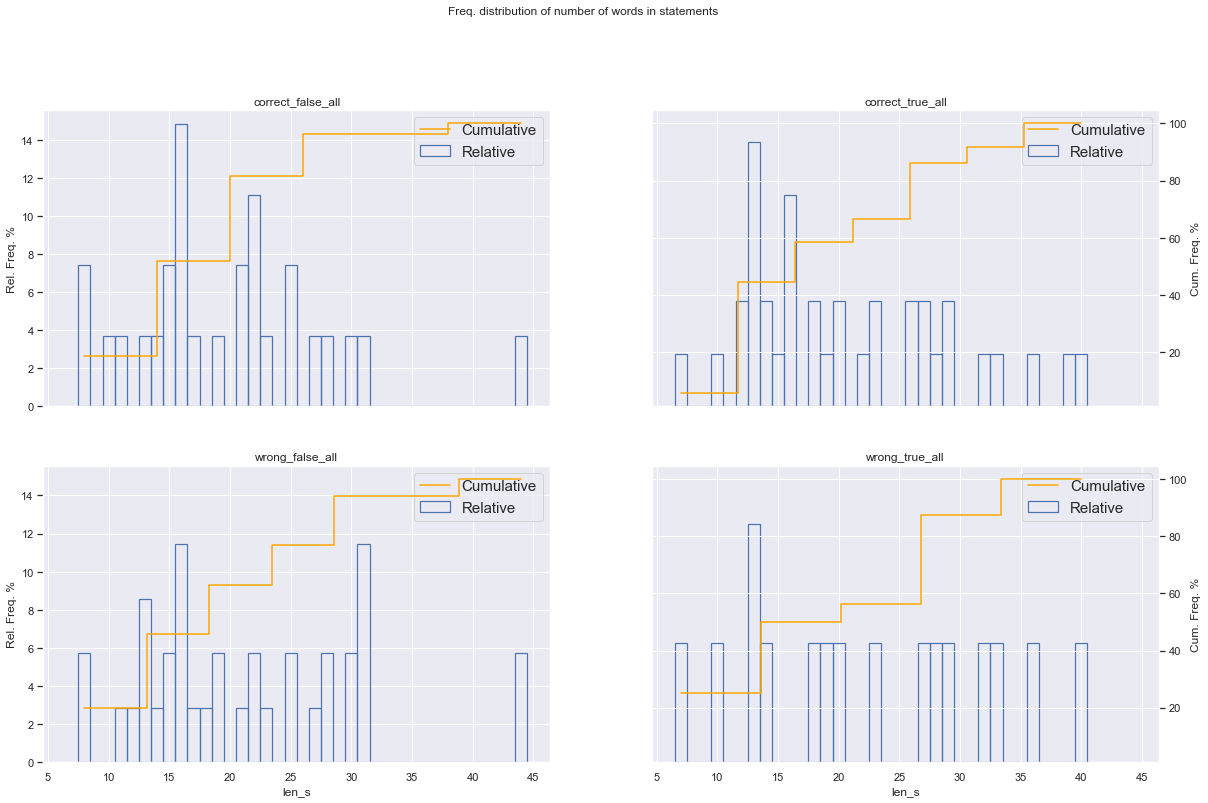

In [9]:
statements['len_s']=statements['doc_statement'].str.split().map(lambda x: len(x))

fig, axs = plt.subplots(2,2,figsize=(20, 12),sharey=True, sharex=True)
twins=[ax.twinx() for ax in axs.flatten()]
twins[0].get_shared_y_axes().join(twins[0], twins[1],twins[2],twins[3])
twins[0].get_yaxis().set_visible(False)
twins[2].get_yaxis().set_visible(False)
axs.ravel()[1].get_yaxis().set_visible(False)
axs.ravel()[3].get_yaxis().set_visible(False)
for t,ax, ax2 in zip(statements.type.unique(), axs.flatten(), twins):
    
    sns.histplot(data=statements.loc[statements.type==t], x='len_s',  stat='percent', ax=ax, label='Relative', fill=False, discrete=True)
    sns.histplot(
        data=statements.loc[statements.type==t], x='len_s',  stat='percent', fill=False, element='step',
        cumulative=True, ax=ax2, color='orange'
    )
    ax.set_ylabel("Rel. Freq. %")
    ax2.set_ylabel("Cum. Freq. %")
    
    ax.plot(np.nan, color='orange', label = 'Cumulative')
    ax.legend(loc=1, prop={'size': 15})
    ax.set_title(t)

fig.suptitle("Freq. distribution of number of words in statements",y=1)
pathlib.Path(f"../Dati/statem_nlp").mkdir(parents=True, exist_ok=True) 
fig.savefig("../Dati/statem_nlp/freq_nwords.png", bbox_inches='tight')

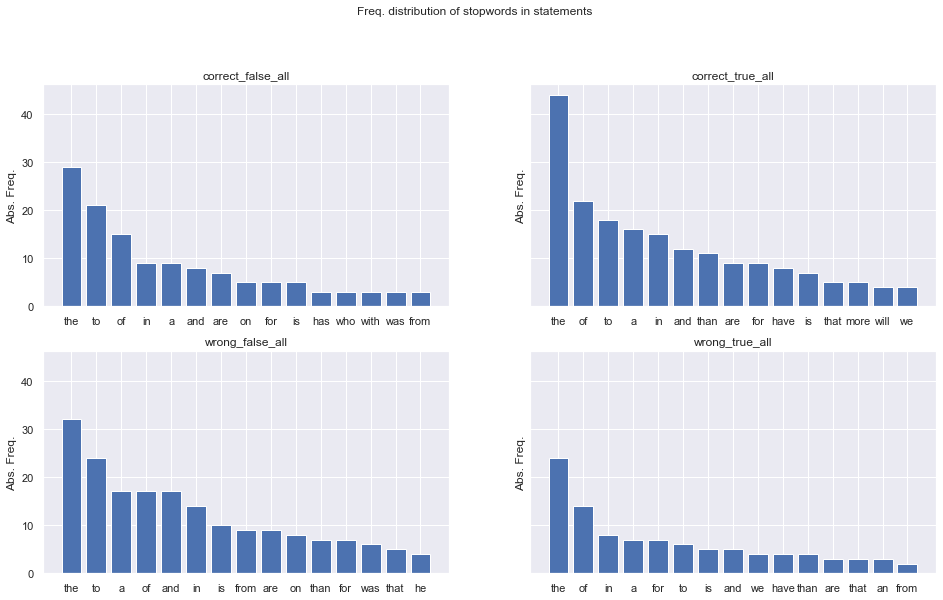

In [10]:
from collections import defaultdict

stop=set(stopwords.words('english'))
fig, axs = plt.subplots(2,2, figsize=(16,9),sharey=True)
for ax,f in zip(axs.flatten(),statements.type.unique()):
    corpus=[]
    statem= statements.loc[statements.type==f,'doc_statement'].str.split()
    statem=statem.values.tolist()
    corpus=[word for i in statem for word in i]
    corpus
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
    x,y=zip(*top)
    ax.bar(x,y)
    ax.set_ylabel("Abs. Freq.")
    ax.set_title(f)
    
fig.suptitle("Freq. distribution of stopwords in statements",y=1)
fig.savefig("../Dati/statem_nlp/freq_stopwords.png", bbox_inches='tight')


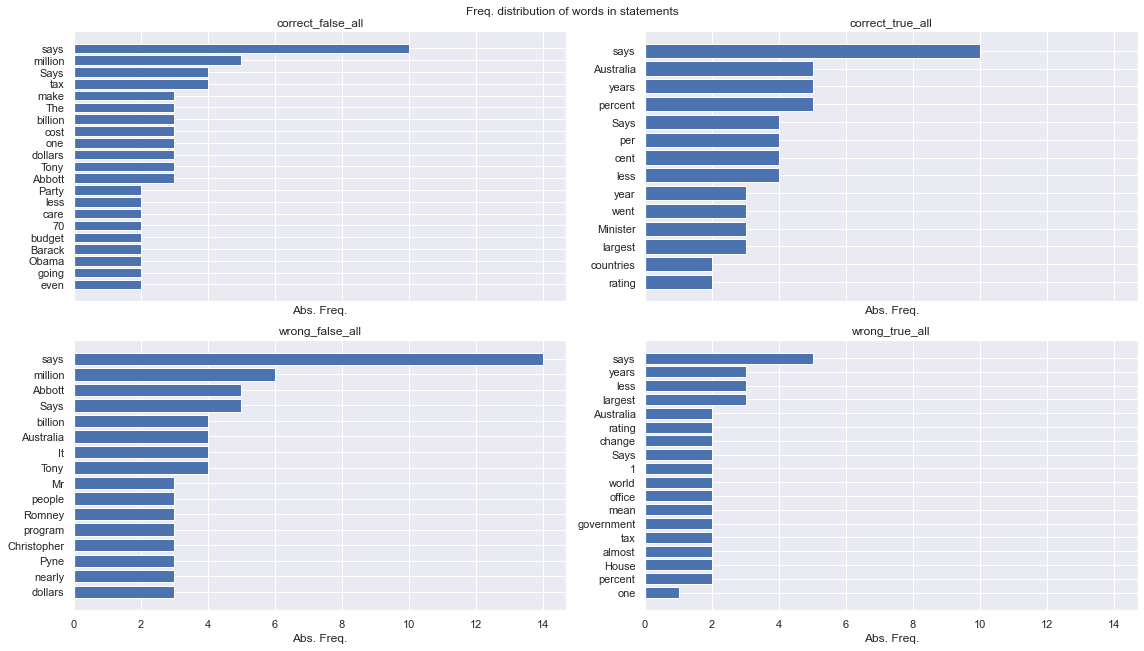

In [11]:
from collections import Counter
stop=set(stopwords.words('english'))
fig, axs = plt.subplots(2,2, figsize=(16,9),sharex=True)
for ax,f in zip(axs.flatten(),statements.type.unique()):
    
    statem= statements.loc[statements.type==f,'doc_statement'].str.split()
    statem=statem.values.tolist()
    corpus=[word for i in statem for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    ax.barh(x[::-1],y[::-1])
    ax.set_xlabel("Abs. Freq.")
    ax.set_title(f)
    
fig.tight_layout() 
fig.suptitle("Freq. distribution of words in statements",y=1)
fig.savefig("../Dati/statem_nlp/freq_words.png", bbox_inches='tight')

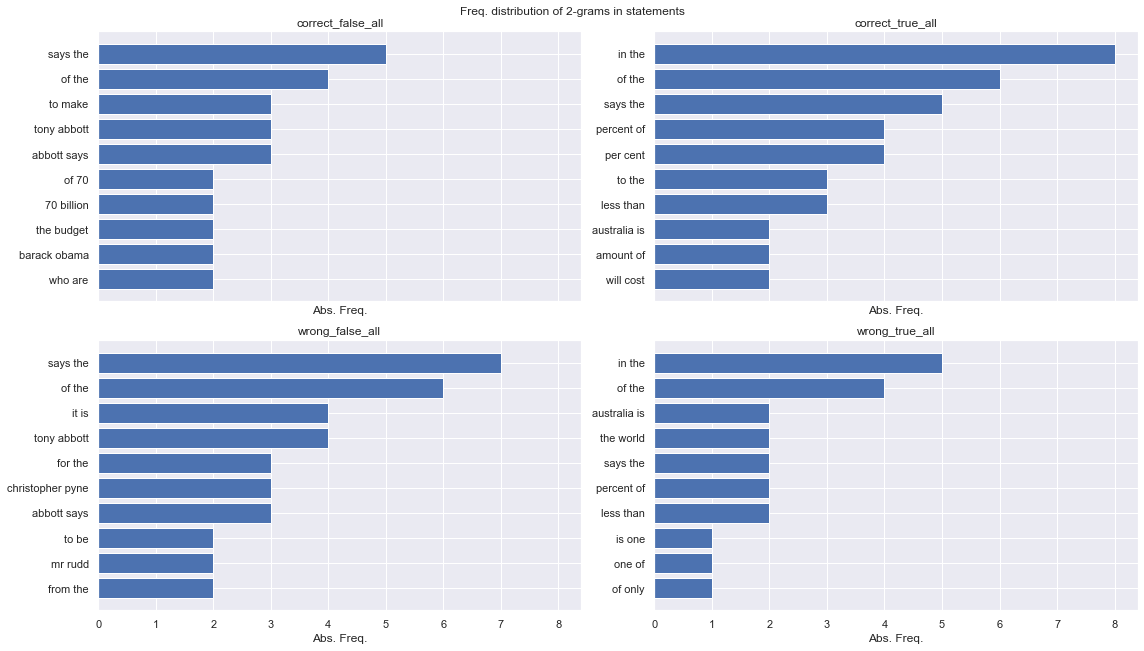

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def _get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

def plot_top_ngrams_barchart(statements, n=2):
    fig, axs = plt.subplots(2,2, figsize=(16,9),sharex=True)
    for ax,f in zip(axs.flatten(),statements.type.unique()):
        statem= statements.loc[statements.type==f,'doc_statement'].str.split()
        statem=statem.values.tolist()

        top_n_bigrams=_get_top_ngram(statements.loc[statements.type==f,'doc_statement'],n)[:10]
        x,y=map(list,zip(*top_n_bigrams))
        ax.barh(x[::-1],y[::-1])
        ax.set_xlabel("Abs. Freq.")
        ax.set_title(f)
        
    fig.tight_layout() 
    fig.suptitle("Freq. distribution of 2-grams in statements",y=1)
    fig.savefig(f"../Dati/statem_nlp/freq_{n}grams.png", bbox_inches='tight')

plot_top_ngrams_barchart(statements,2)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim
from nltk.stem import WordNetLemmatizer

def get_lda_objects(text):
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        lem=WordNetLemmatizer()
        for stat in text:
            words=[w for w in word_tokenize(stat) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, bow_corpus, dic)
    return vis

for f in statements.type.unique():
    lda_model, bow_corpus, dic = get_lda_objects(statements.loc[statements.type==f,'doc_statement'])
    lda_model.show_topics()
    vis=plot_lda_vis(lda_model, bow_corpus, dic)
    pyLDAvis.save_html(vis, f"../Dati/statem_nlp/lda_{f}.html")


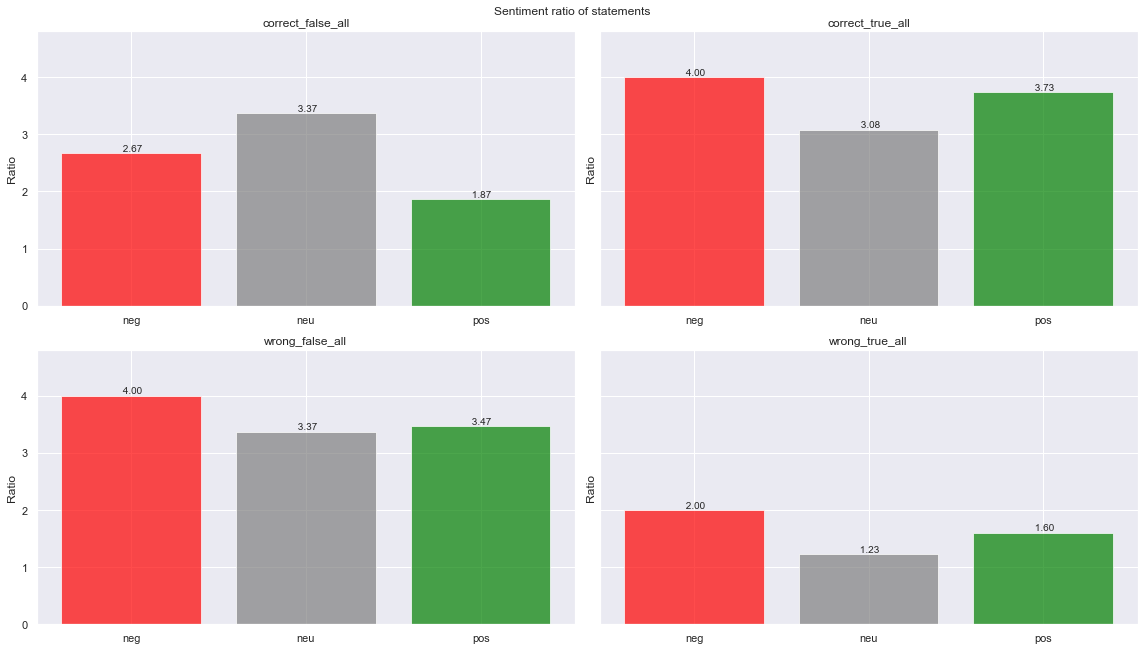

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    data=pd.read_csv('../Dati/multidimensional.csv')
    false_labs=['negative','pants-on-fire']
    true_labs=['positive','true']

    data=data.loc[data['doc_name']!='DEM_BARELYTRUE_doc7']


    data=data.loc[(data['doc_ground_truth_abc_label']==false_labs[0]) | 
            (data['doc_ground_truth_abc_label']==true_labs[0]) |
            (data['doc_ground_truth_politifact_label']==false_labs[1])|
            (data['doc_ground_truth_politifact_label']==true_labs[1])]

    data.loc[(data['doc_ground_truth_abc_label']==false_labs[0]) | (data['doc_ground_truth_politifact_label']==false_labs[1]),'type']='false'
    data.loc[(data['doc_ground_truth_abc_label']==true_labs[0]) | (data['doc_ground_truth_politifact_label']==true_labs[1]),'type']='true'
    data=data[['type', 'doc_statement']].drop_duplicates()
    
    fig, axs = plt.subplots(2,2, figsize=(16,9),sharey=True)
    for ax,f in zip(axs.flatten(),text.type.unique()):
        if method == 'TextBlob':
            sentiment = text.loc[text.type==f,'doc_statement'].map(lambda x: sentiment_textblob(x))
            all_sent= data.loc[data.type==f.split('_')[1],'doc_statement'].map(lambda x: sentiment_textblob(x))
        elif method == 'Vader':
            sid = SentimentIntensityAnalyzer()
            sentiment = text.loc[text.type==f,'doc_statement'].map(lambda x: sentiment_vader(x, sid=sid))
            all_sent= data.loc[data.type==f.split('_')[1],'doc_statement'].map(lambda x: sentiment_vader(x, sid=sid))
        else:
            raise ValueError('Textblob or Vader')
        

        sent=(sentiment.value_counts().sort_index()/10)/(all_sent.value_counts().sort_index().values/40)

        ax.bar(sent.index, sent, color=['red', 'grey', 'green'], alpha=0.7)
        ax.set_ylabel("Ratio")
        ax.set_title(f)

        for c in ax.containers:
            labels = [f' {v.get_height():.2f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        ax.margins(y=0.2)
        
    fig.tight_layout()
    fig.suptitle("Sentiment ratio of statements",y=1)
    fig.savefig(f"../Dati/statem_nlp/sentiments_{method}.png", bbox_inches='tight')
    
plot_sentiment_barchart(statements, method='TextBlob')
# plot_sentiment_barchart(statements, method='Vader')

low            0.450
medium         0.300
medium low     0.125
medium high    0.075
high           0.050
Name: doc_statement, dtype: float64
low            0.40
medium         0.25
medium low     0.25
high           0.05
medium high    0.05
Name: doc_statement, dtype: float64
low            0.450
medium         0.300
medium low     0.125
medium high    0.075
high           0.050
Name: doc_statement, dtype: float64
low            0.40
medium         0.25
medium low     0.25
high           0.05
medium high    0.05
Name: doc_statement, dtype: float64


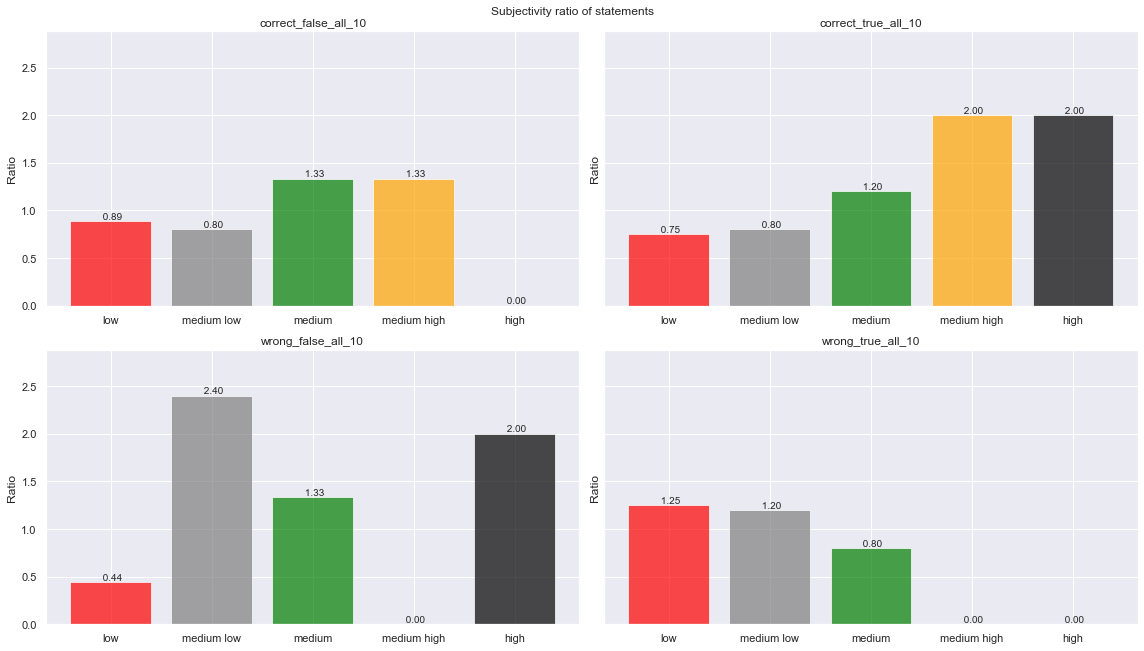

In [ ]:
from textblob import TextBlob

def subj_textblob(text):
        x=TextBlob(text).sentiment.subjectivity
    
        if x<.20:
            return 'low'
        elif x<.40:
            return 'medium low'
        elif x<.60:
            return 'medium'
        elif x<.80:
            return 'medium high'
        else:
            return 'high'

def plot_subj_barchart(text):
    data=pd.read_csv('../Dati/multidimensional.csv')
    false_labs=['negative','pants-on-fire']
    true_labs=['positive','true']

    data=data.loc[data['doc_name']!='DEM_BARELYTRUE_doc7']


    data=data.loc[(data['doc_ground_truth_abc_label']==false_labs[0]) | 
            (data['doc_ground_truth_abc_label']==true_labs[0]) |
            (data['doc_ground_truth_politifact_label']==false_labs[1])|
            (data['doc_ground_truth_politifact_label']==true_labs[1])]

    data.loc[(data['doc_ground_truth_abc_label']==false_labs[0]) | (data['doc_ground_truth_politifact_label']==false_labs[1]),'type']='false'
    data.loc[(data['doc_ground_truth_abc_label']==true_labs[0]) | (data['doc_ground_truth_politifact_label']==true_labs[1]),'type']='true'
    data=data[['type', 'doc_statement']].drop_duplicates()
    
    fig, axs = plt.subplots(2,2, figsize=(16,9),sharey=True)
    for ax,f in zip(axs.flatten(),text.type.unique()):

        subjectivity = text.loc[text.type==f,'doc_statement'].map(lambda x: subj_textblob(x))
        all_subj= data.loc[data.type==f.split('_')[1],'doc_statement'].map(lambda x: subj_textblob(x))

        
        subj_part=subjectivity.value_counts()/10
        subj_all=all_subj.value_counts()/40
        
        subj=subj_part.divide(subj_all, fill_value=0)
        subj=subj.reindex(index=['low', 'medium low', 'medium', 'medium high', 'high'])
        ax.bar(subj.index, subj, color=['red', 'grey', 'green','orange', 'black'], alpha=0.7)
        ax.set_ylabel("Ratio")
        ax.set_title(f)
        
        for c in ax.containers:
            labels = [f' {v.get_height():.2f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        ax.margins(y=0.2)

    fig.tight_layout()
    fig.suptitle("Subjectivity ratio of statements",y=1)
    fig.savefig(f"../Dati/statem_nlp/subjectivity.png", bbox_inches='tight')
    
plot_subj_barchart(statements)


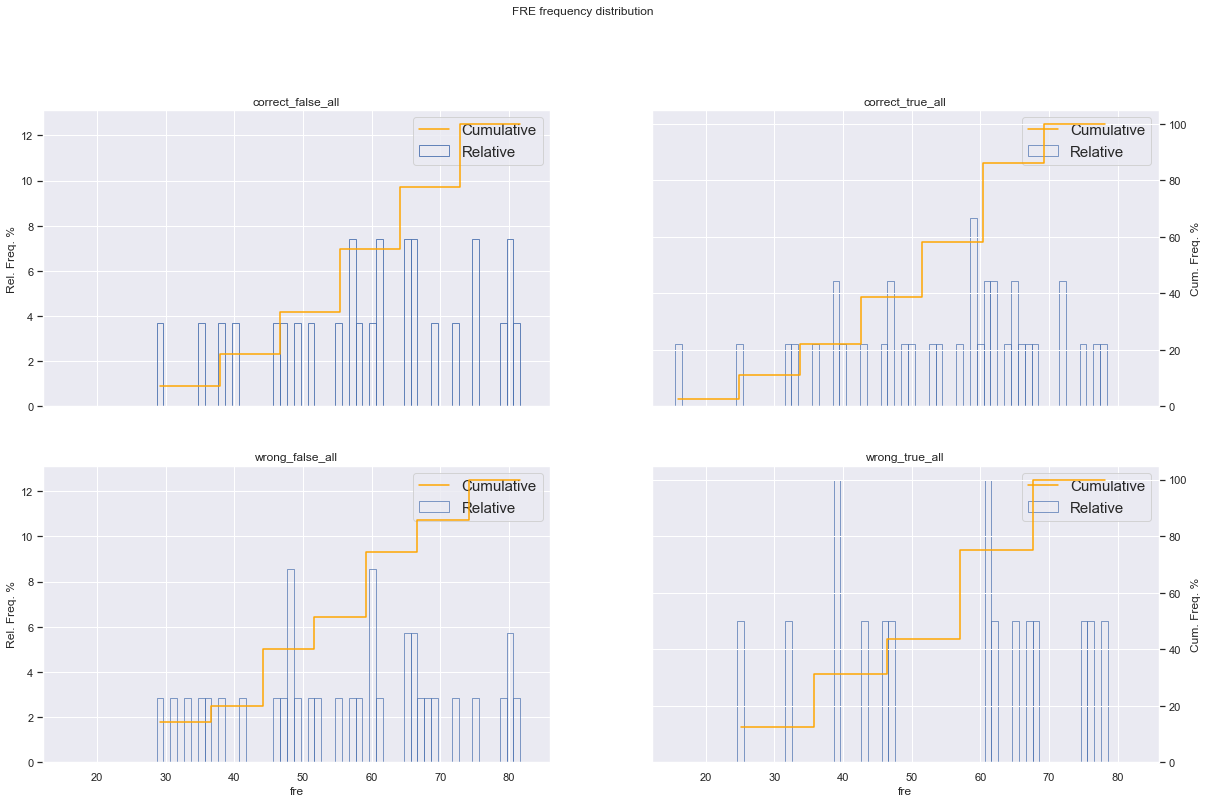

In [15]:
statements['fre']=statements['doc_statement'].apply(lambda x : flesch_reading_ease(x))

fig, axs = plt.subplots(2,2,figsize=(20, 12),sharey=True, sharex=True)
twins=[ax.twinx() for ax in axs.flatten()]
twins[0].get_shared_y_axes().join(twins[0], twins[1],twins[2],twins[3])
twins[0].get_yaxis().set_visible(False)
twins[2].get_yaxis().set_visible(False)
axs.ravel()[1].get_yaxis().set_visible(False)
axs.ravel()[3].get_yaxis().set_visible(False)

for t,ax,ax2 in zip(statements.type.unique(), axs.flatten(), twins):
    
    sns.histplot(data=statements.loc[statements.type==t], x='fre',  stat='percent', ax=ax, label='Relative', fill=False, discrete=True)
    sns.histplot(
        data=statements.loc[statements.type==t], x='fre',  stat='percent', fill=False, element='step',
        cumulative=True, ax=ax2, color='orange'
    )
    ax.set_ylabel("Rel. Freq. %")
    ax2.set_ylabel("Cum. Freq. %")
    
    ax.plot(np.nan, color='orange', label = 'Cumulative')
    ax.legend(loc=1, prop={'size': 15})
    ax.set_title(t)
    
fig.suptitle("FRE frequency distribution",y=1)
fig.savefig(f"../Dati/statem_nlp/read_complexity.png", bbox_inches='tight')

In [16]:
filenames = next(os.walk("../Dati/statem_nlp"), (None, None, []))[2]
filenames= [x for x in filenames if x.endswith('.png')]
create_collage(4000, 2000, 3,2, [f"../Dati/statem_nlp/{f}" for f in filenames], '../Dati/pics/nlp_collage.png'),

0 0 0
1 0 1002
2 1335 0
3 1335 1002
4 2670 0
5 2670 1002


(None,)

# Altre analisi

## Varie

In [ ]:
import plotly.express as px

df= pd.read_csv("../Dati/all_rows.csv")
df=df[df['type'].apply(lambda x: x.endswith('_all'))]

fig = px.parallel_categories(df, dimensions=['q_0_age_answer', 'q_0_school_answer'],
                color=(df.q_0_age_answer.astype('category').cat.codes)/4,
                labels={'q_0_age_answer':'q_0_age_answer', 'q_0_school_answer':'q_0_school_answer'})
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
df= pd.read_csv("../Dati/all_rows.csv")
df=df[df['type'].apply(lambda x: x.endswith('_all'))]
df["q_0_age_answer"]=pd.Categorical(df["q_0_age_answer"], categories = ['19-25', '26-35', '36-50', '50-80'], ordered = True)
df["q_0_school_answer"]=pd.Categorical(df["q_0_school_answer"], categories = ['High school graduate or GED (etc.)', 'Some college (etc.)', '4 year college/bachelor degree', 'Postgrad. or professional schooling, no degree', 'Postgrad. or professional degree (etc.)'][::-1], ordered = True)
ax = ax1= sns.histplot(
    df, x="q_0_age_answer", y="q_0_school_answer",  stat="percent",legend=False, cbar=True, cbar_kws=dict(shrink=.75, label='Rel. Freq. %')
)

In [ ]:
df["q_0_taxes_answer"]=pd.Categorical(df["q_0_taxes_answer"], categories = ['Less than 10,000','10,000 to less than 20,000','20,000 to less than 30,000','30,000 to less than 40,000','40,000 to less than 50,000','50,000 to less than 75,000','75,000 to less than 100,000','100,000 to less than 150,000','150,000 or more'][::-1], ordered = True)
ax=sns.histplot(
    df, x="q_0_age_answer", y="q_0_taxes_answer",  stat="percent",legend=False, cbar=True, cbar_kws=dict(shrink=.75, label='Rel. Freq. %')
)

## Matrici correlazione

In [17]:
transf_cols={
    'q_0_age_answer':['19-25', '26-35', '36-50', '50-80'],
    'q_0_school_answer': ['High school graduate or GED (etc.)', 'Some college (etc.)', '4 year college/bachelor degree', 'Postgrad. or professional schooling, no degree', 'Postgrad. or professional degree (etc.)'],
    'q_0_taxes_answer': ['Less than 10,000','10,000 to less than 20,000','20,000 to less than 30,000','30,000 to less than 40,000','40,000 to less than 50,000','50,000 to less than 75,000','75,000 to less than 100,000','100,000 to less than 150,000','150,000 or more'],
    'q_0_political_views_answer':['Very conservative', 'Conservative', 'Moderate', 'Liberal', 'Very liberal'],
    'q_0_consideration_answer':['Republican','Democrat','Independent','Something else'],
    'q_0_southern_border_answer':['Disagree','No opinion either way','Agree'],
    'q_0_environment_answer':['Disagree','No opinion either way','Agree'],
    'q_1_farmers_value':['wrong value','correct value'],
    'q_2_marks_value':['wrong value','correct value'],
    'q_3_athletics_value':['wrong value','correct value'],
    'doc_name': ['REP','Liberal','DEM','Labor'],
    'doc_source': ['abc','politifact']
}

def transf_data(rows, tr_dict):
    rows['doc_name']=rows['doc_name'].map(lambda x: x.split('_')[0])
    rows['fre']=rows['doc_statement'].apply(lambda x : flesch_reading_ease(x))
    for k,v in tr_dict.items():
        rows[k]=pd.Categorical(rows[k], categories = v, ordered = True).codes

def corr_matrix(df,method,typ):
    x=1 if typ=='all' else 2
    
    fig, axs = plt.subplots(x,2,figsize=(50, 30))

    for t,ax in zip(df.type.unique(), axs.flatten()):

        corr = df.loc[df.type==t].corr(method=method)

        mask = np.triu(np.ones_like(corr, dtype=bool))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, ax=ax)
        ax.set_title(t)
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=30,
            horizontalalignment='right'
        )

    fig.suptitle(f"correlation heatmap {typ}, method={method}", y=1)
    fig.tight_layout()
    pathlib.Path(f"../Dati/corr_analysis").mkdir(parents=True, exist_ok=True) 
    fig.savefig(f'../Dati/corr_analysis/heatmap_{method}_{typ}.png',  bbox_inches='tight')


In [ ]:
r= pd.read_csv("../Dati/all_rows.csv")
r=r[r['type'].apply(lambda x: x.endswith('_all'))]
transf_data(r, transf_cols)
df=r[columns+['type','url_speaksabout','fre']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url'], axis=1)

corr_matrix(df,'kendall', 'partial')
corr_matrix(df,'spearman', 'partial')

In [ ]:
false_labs=['negative','pants-on-fire']
true_labs=['positive','true']

d = pd.read_csv("../Dati/multidimensional.csv")
d=d.loc[d['doc_name']!='DEM_BARELYTRUE_doc7']

d['q_1_farmers_value']=d['q_1_farmers_value'].map(lambda x: 'correct value' if x==3 else 'wrong value')
d['q_2_marks_value']=d['q_2_marks_value'].map(lambda x: 'correct value' if x==9 else 'wrong value')
d['q_3_athletics_value']=d['q_3_athletics_value'].map(lambda x: 'correct value' if x==4 else 'wrong value')
d['q_0_school_answer']=d['q_0_school_answer'].map(shorten_school)

d=d.loc[(d['doc_ground_truth_abc_label']==false_labs[0]) | 
        (d['doc_ground_truth_abc_label']==true_labs[0]) |
        (d['doc_ground_truth_politifact_label']==false_labs[1])|
        (d['doc_ground_truth_politifact_label']==true_labs[1])]

d.loc[(d['doc_ground_truth_abc_label']==false_labs[0]) | (d['doc_ground_truth_politifact_label']==false_labs[1]),'type']='false'
d.loc[(d['doc_ground_truth_abc_label']==true_labs[0]) | (d['doc_ground_truth_politifact_label']==true_labs[1]),'type']='true'

transf_data(d, transf_cols)
data=d[columns+['type','fre']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url'], axis=1)

corr_matrix(data,'kendall', 'all')
corr_matrix(data,'spearman', 'all')

In [ ]:
create_collage(7000, 4500, 2,2, [f"../Dati/corr_analysis/{x}" for x in next(os.walk("../Dati/corr_analysis"), (None, None, []))[2]], '../Dati/pics/corr_collage.png')

## Medie con groupby

In [ ]:
r= pd.read_csv("../Dati/all_rows.csv")
r=r[r['type'].apply(lambda x: x.endswith('_all'))]

d=r.copy()
transf_data(d, transf_cols)
df=d[columns+['doc_statement','type','url_speaksabout','fre']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url'], axis=1)


group = pd.read_csv("../Dati/groupby.csv")
group=group[group['file'].apply(lambda x: x.endswith('_all'))]
group=group.loc[group.type=='unit_id']

df_type_unit=d[columns+['unit_id','type','url_speaksabout','fre']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url'], axis=1)
df_unit=d[columns+['unit_id','url_speaksabout','fre']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url'], axis=1)

def set_type_unit(x):
    x.unit_id= group.loc[(group.file==x.type) & (group.value==x.unit_id),'rate'].values[0]
    return x

def set_unit(x):
    x.unit_id= group.loc[group.value==x.unit_id,'rate'].values[0]
    return x

df_type_unit=df_type_unit.apply(set_type_unit, axis=1)
df_unit=df_unit.apply(set_unit, axis=1)

df_type=df.groupby(['type'], as_index = False).mean().sort_values(by=['type','url_speaksabout'])
df_stat=df.groupby(['type', 'doc_statement'], as_index = False).mean().sort_values(by=['type','url_speaksabout'])
df_type_unit=df_type_unit.groupby(['type', 'unit_id'], as_index = False).mean().sort_values(by=['type','url_speaksabout'])
df_unit=df_unit.groupby(['unit_id'], as_index = False).mean().sort_values(by=['url_speaksabout'])

def transf_back(x):
    for k,v in transf_cols.items():
        x[k]=f"{v[round(float(x[k]))]} ({float(x[k]):.2f})"
    return x

df_type=df_type.apply(transf_back, axis=1)
df_stat=df_stat.apply(transf_back, axis=1)
df_type_unit=df_type_unit.apply(transf_back, axis=1)
df_unit=df_unit.apply(transf_back, axis=1)

df_type.to_csv('../Dati/groupby_type.csv', index=False)
df_stat.to_csv('../Dati/groupby_statement.csv', index=False)
df_type_unit.to_csv('../Dati/groupby_type_unit.csv', index=False)
df_unit.to_csv('../Dati/groupby_unit.csv', index=False)

## Gold / Not Gold

In [ ]:
transf_cols_2={
    'q_0_age_answer':['19-25', '26-35', '36-50', '50-80'],
    'q_0_school_answer': ['High school graduate or GED (etc.)', 'Some college (etc.)', '4 year college/bachelor degree', 'Postgrad. or professional schooling, no degree', 'Postgrad. or professional degree (etc.)'],
    'q_0_taxes_answer': ['Less than 10,000','10,000 to less than 20,000','20,000 to less than 30,000','30,000 to less than 40,000','40,000 to less than 50,000','50,000 to less than 75,000','75,000 to less than 100,000','100,000 to less than 150,000','150,000 or more'],
    'q_0_political_views_answer':['Very conservative', 'Conservative', 'Moderate', 'Liberal', 'Very liberal'],
    'q_0_consideration_answer':['Republican','Democrat','Independent','Something else'],
    'q_0_southern_border_answer':['Disagree','No opinion either way','Agree'],
    'q_0_environment_answer':['Disagree','No opinion either way','Agree'],
    'q_1_farmers_value':['wrong value','correct value'],
    'q_2_marks_value':['wrong value','correct value'],
    'q_3_athletics_value':['wrong value','correct value']
}

def transf_back_2(x):
    for k,v in transf_cols_2.items():
        x[k]=f"{v[round(float(x[k]))]} ({float(x[k]):.2f})"
    return x

In [ ]:
multi = pd.read_csv("../Dati/multidimensional.csv")
multi=multi.loc[multi['doc_name']!='DEM_BARELYTRUE_doc7']
multi['q_1_farmers_value']=multi['q_1_farmers_value'].map(lambda x: 'correct value' if x==3 else 'wrong value')
multi['q_2_marks_value']=multi['q_2_marks_value'].map(lambda x: 'correct value' if x==9 else 'wrong value')
multi['q_3_athletics_value']=multi['q_3_athletics_value'].map(lambda x: 'correct value' if x==4 else 'wrong value')
multi['q_0_school_answer']=multi['q_0_school_answer'].map(shorten_school)

group = pd.read_csv("../Dati/groupby.csv")
group=group[group['file'].apply(lambda x: x.endswith('_all'))]

def set_type_unit(x):
        x.unit_id= group.loc[(group.file==f) & (group.value==x.unit_id),'rate'].values[0]
        return x

df_type=None
df_type_unit=None
df_ng=None
df_ng_type=None
for f in group.file.unique():
    g=group.loc[(group.file==f) & (group.type=='unit_id')]
    m_g=multi.loc[(multi['unit_id'].isin(g.value.values)) & (multi.doc_source=='gold_question')]
    d_g=m_g.copy()
    
    m_ng=multi.loc[(multi['unit_id'].isin(g.value.values)) & (multi.doc_source!='gold_question')]
    d_ng=m_ng.copy()
    
    
    transf_data(d_g, transf_cols_2)
    transf_data(d_ng, transf_cols_2)
    
    
    data_type=d_g[columns+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url','doc_source'], axis=1)
    data_type_unit=d_g[columns+['unit_id']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url','doc_source'], axis=1)
    data_ng=d_ng[columns+['fre']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url','doc_source','doc_name'], axis=1)
    data_ng_type=d_ng[columns+['unit_id', 'fre']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url','doc_source','doc_name'], axis=1)
    
    data_type_unit=data_type_unit.apply(set_type_unit, axis=1)
    data_ng_type=data_ng_type.apply(set_type_unit, axis=1)
    
    data_type=data_type.groupby(['doc_name'], as_index = False).mean().sort_values(by=['doc_name'])
    data_type_unit=data_type_unit.groupby(['unit_id','doc_name'], as_index = False).mean().sort_values(by=['doc_name'])
    
    data_type=data_type.apply(transf_back_2, axis=1)
    data_type_unit=data_type_unit.apply(transf_back_2, axis=1)
    
    data_type.insert(0, 'type', f)
    data_type_unit.insert(0, 'type', f)
    data_ng.insert(0, 'type', f)
    data_ng_type.insert(0, 'type', f)
    
    
    if df_type is None:
        df_type=data_type.copy()
        df_type_unit=data_type_unit.copy()
        df_ng=data_ng.copy()
        df_ng_type=data_ng_type.copy()
    else:
        df_type=pd.concat([df_type,data_type])
        df_type_unit=pd.concat([df_type_unit,data_type_unit])
        df_ng=pd.concat([df_ng,data_ng])
        df_ng_type=pd.concat([df_ng_type,data_ng_type])
        
df_ng=df_ng.groupby(['type'], as_index = False).mean().sort_values(by=['type'])
df_ng_type=df_ng_type.groupby(['type','unit_id'], as_index = False).mean().sort_values(by=['type'])

df_ng=df_ng.apply(transf_back_2, axis=1)
df_ng_type=df_ng_type.apply(transf_back_2, axis=1)

df_ng.to_csv('../Dati/not_gold_type.csv', index=False)
df_ng_type.to_csv('../Dati/not_gold_type_unit.csv', index=False)
df_type.to_csv('../Dati/gold_type.csv', index=False)
df_type_unit.to_csv('../Dati/gold_type_unit.csv', index=False)

## Trend

<ipython-input-20-328987cde8af>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,2,figsize=(16, 5),  sharey=True)


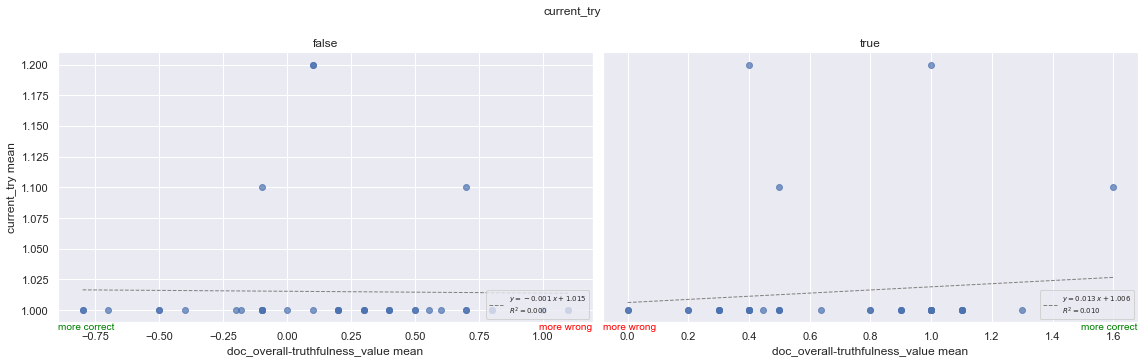

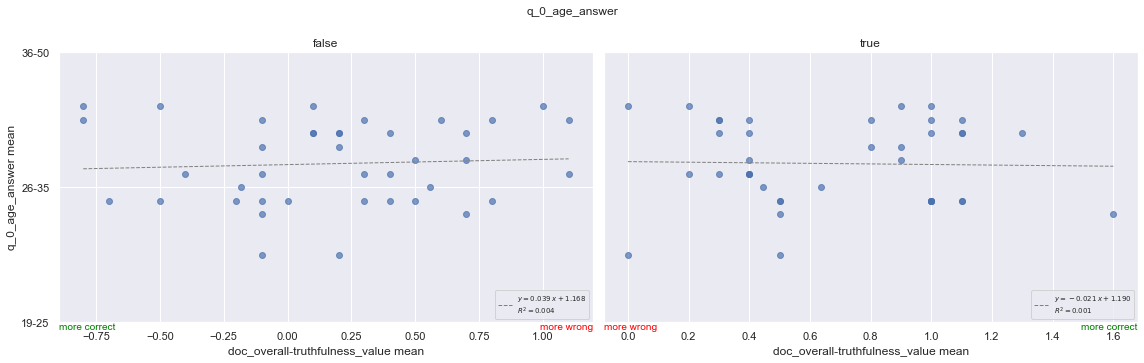

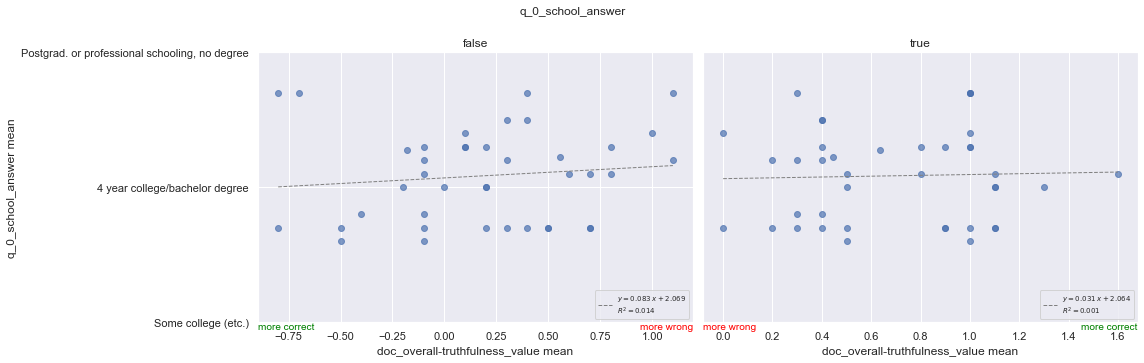

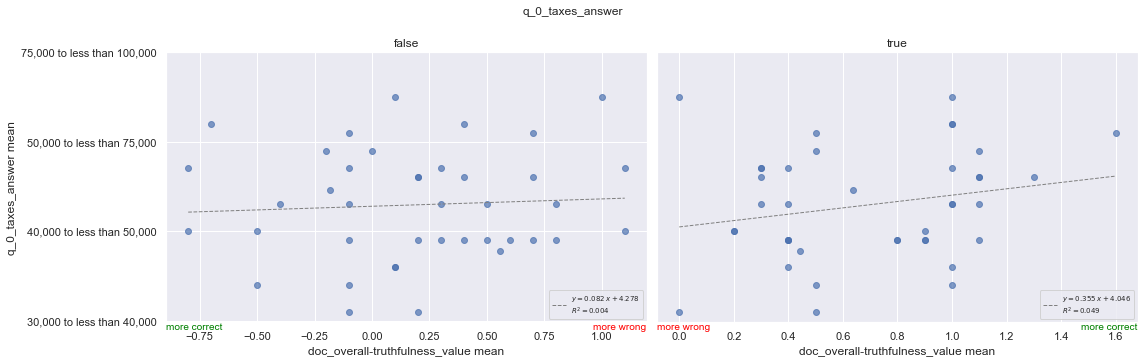

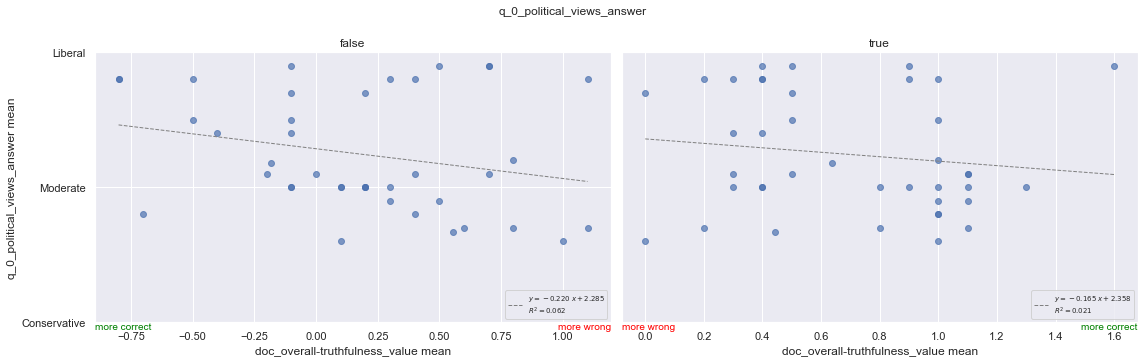

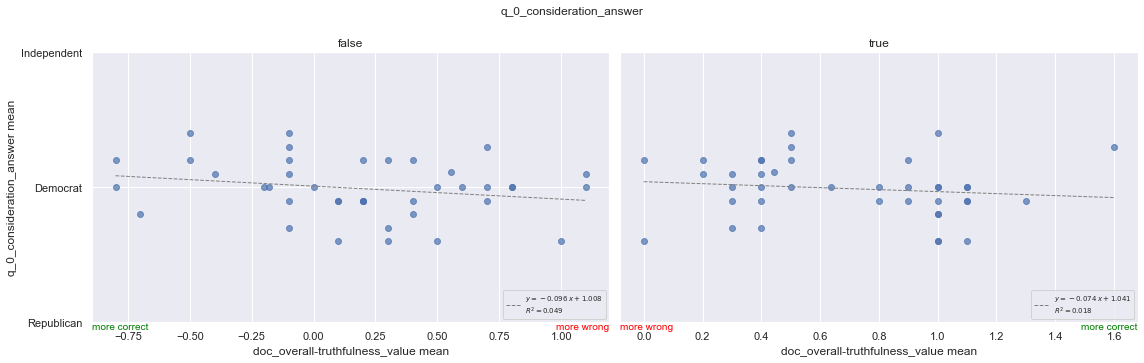

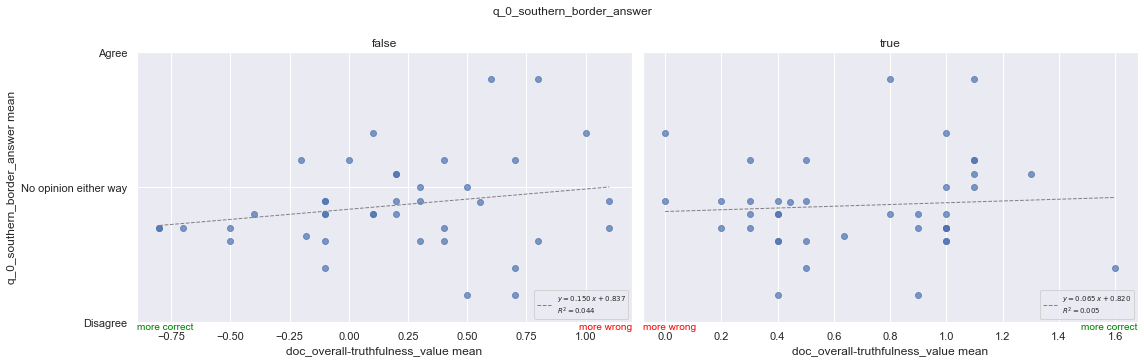

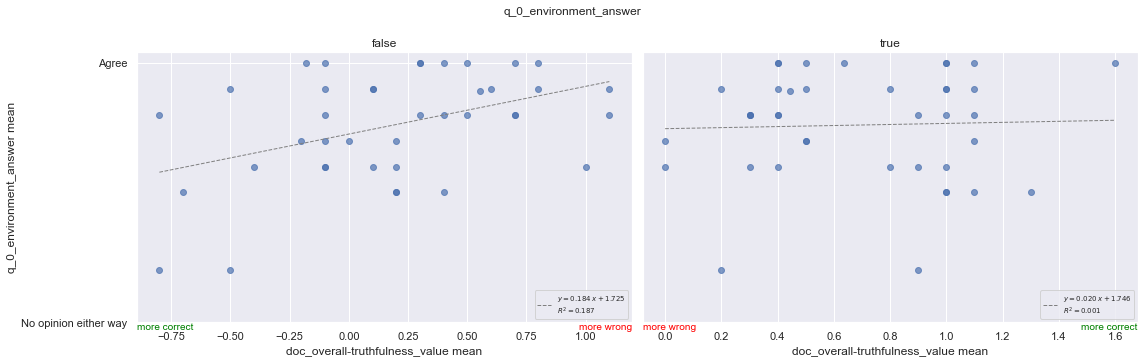

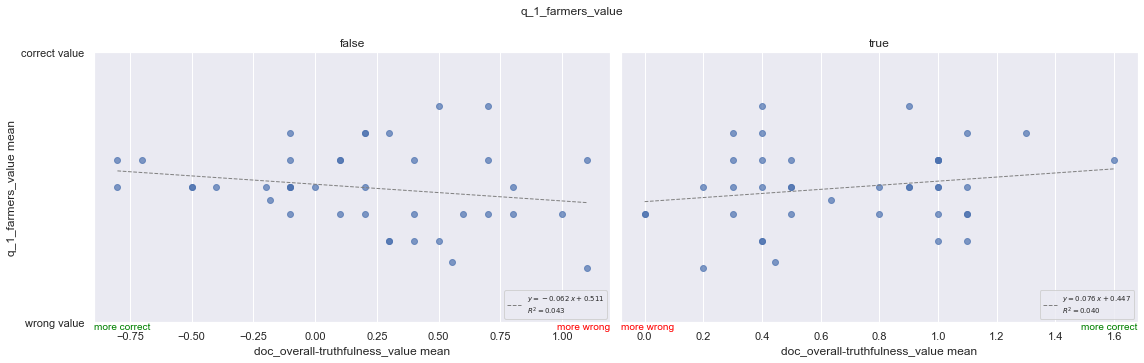

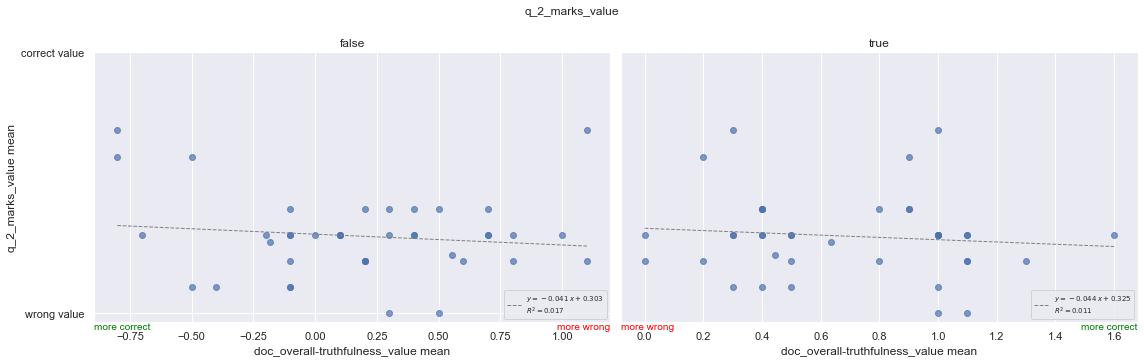

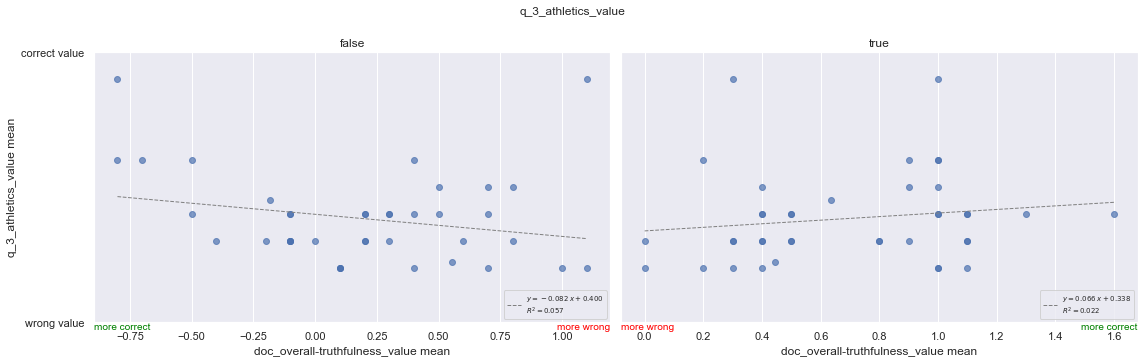

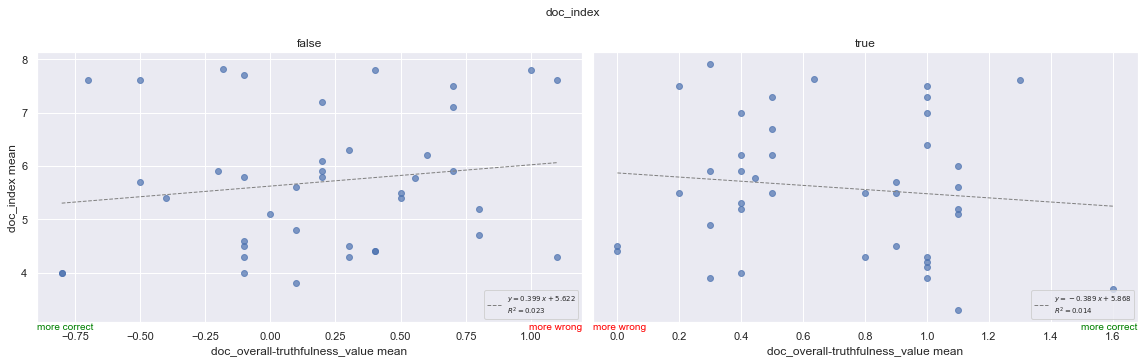

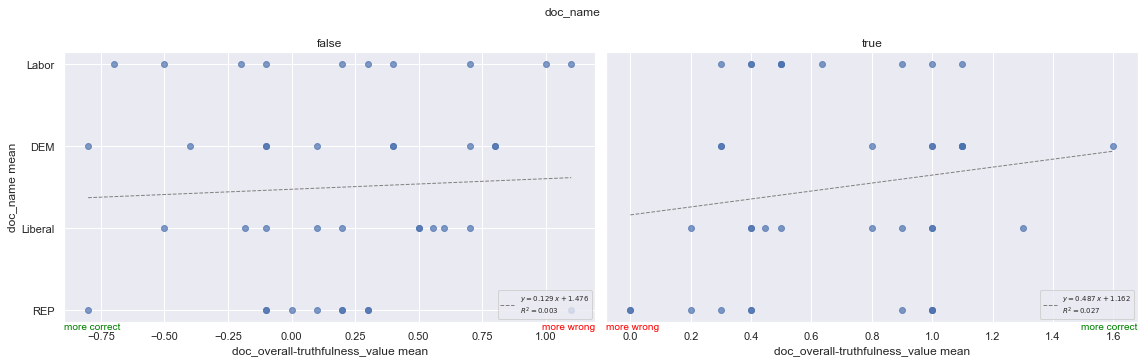

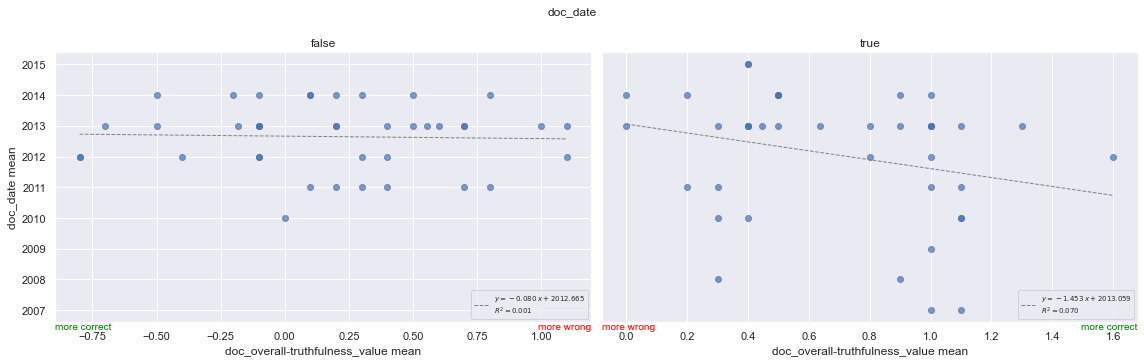

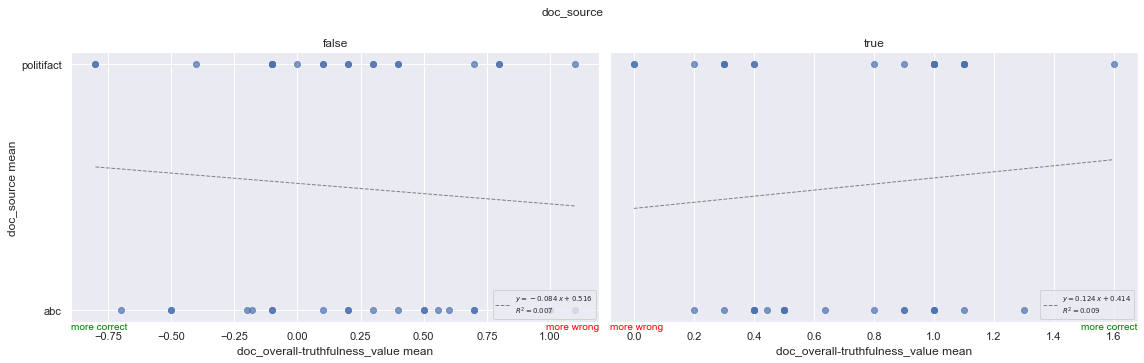

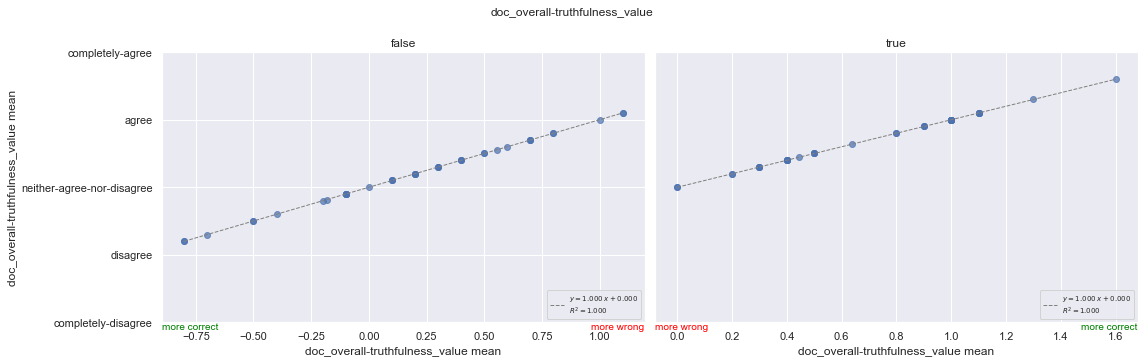

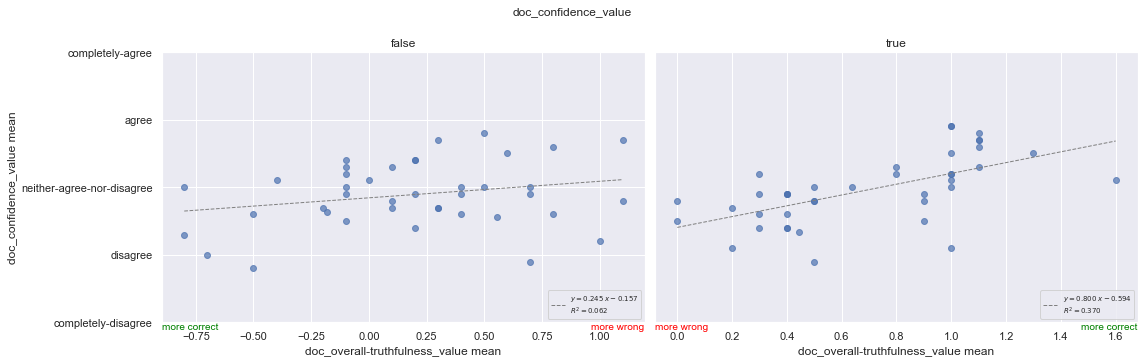

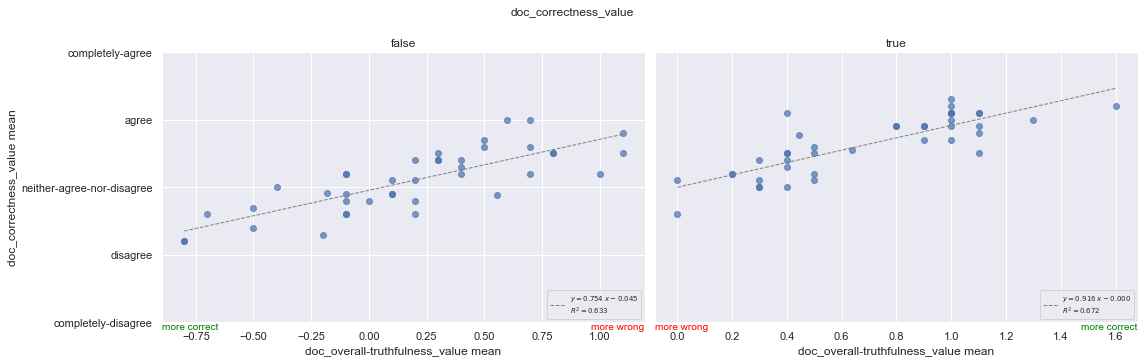

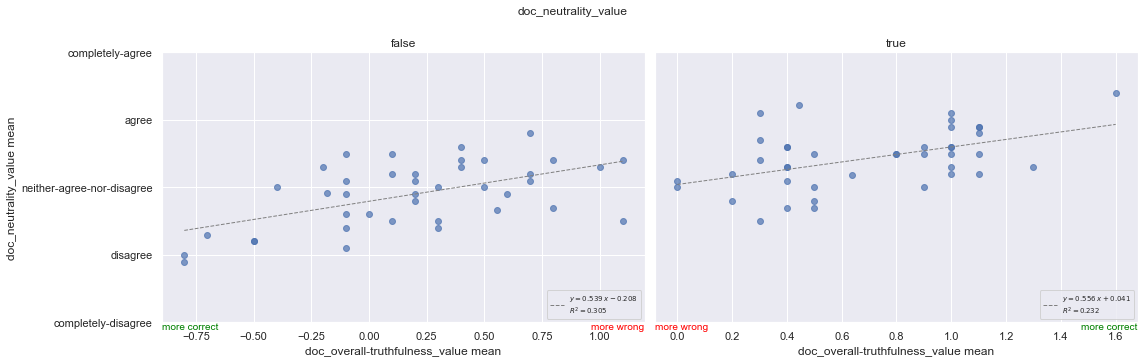

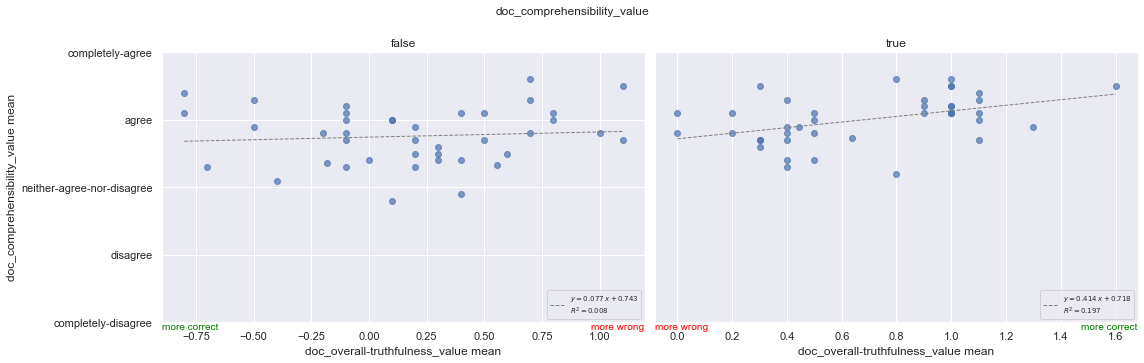

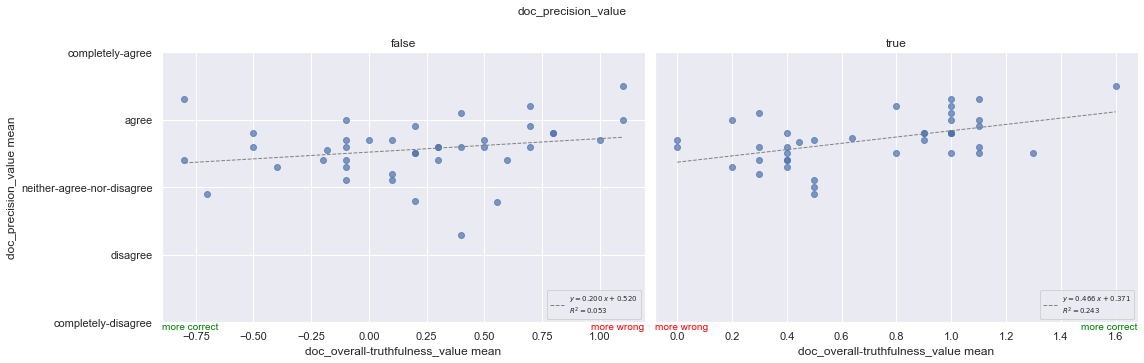

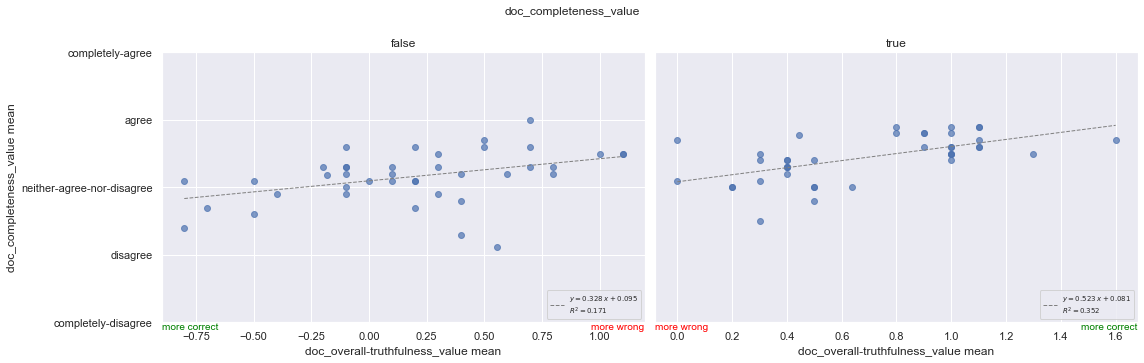

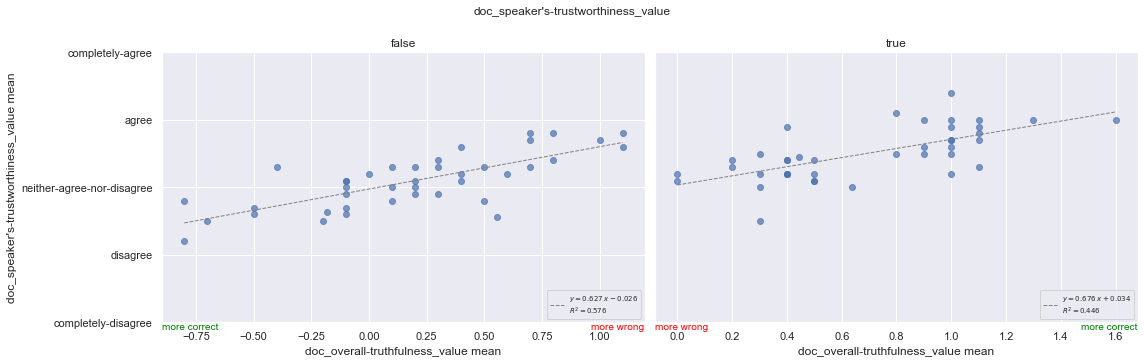

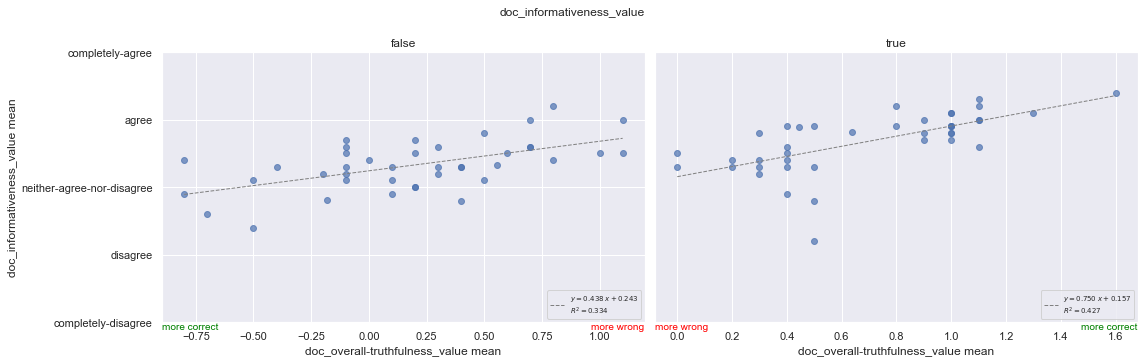

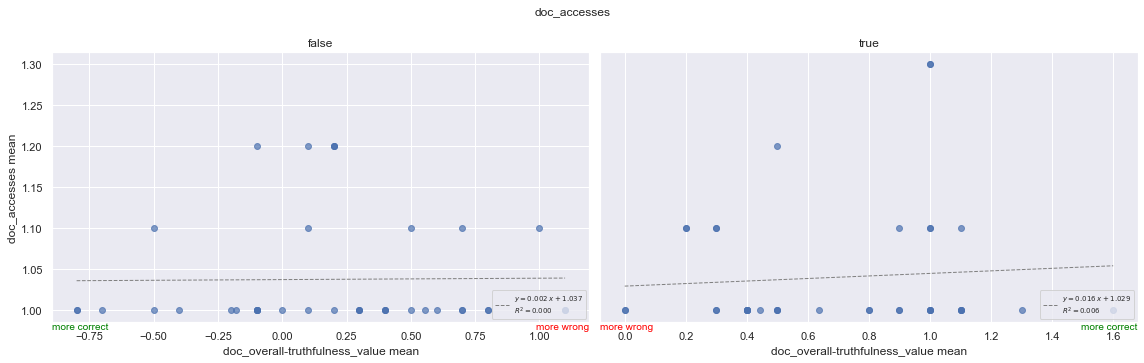

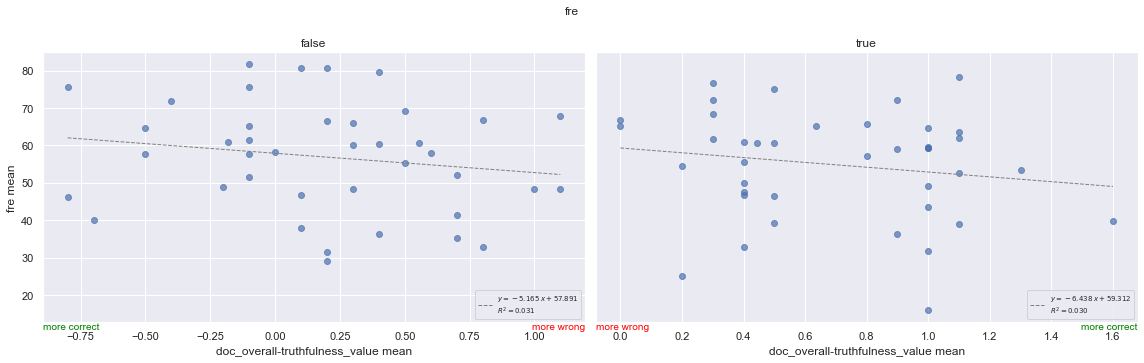

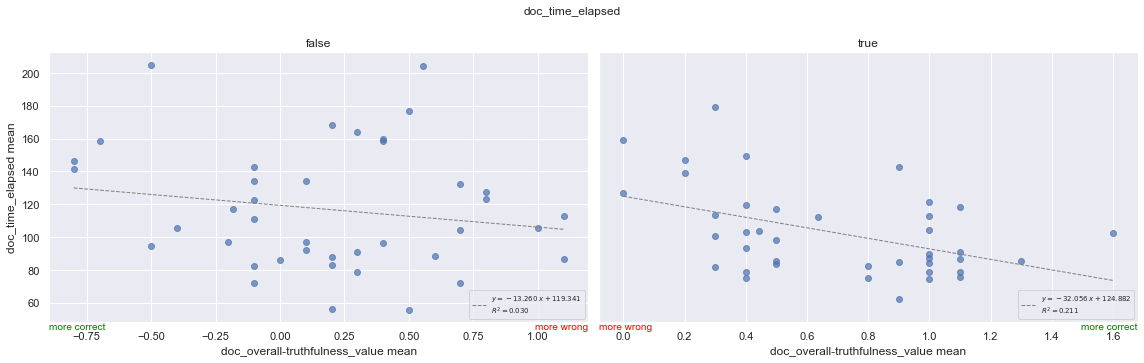

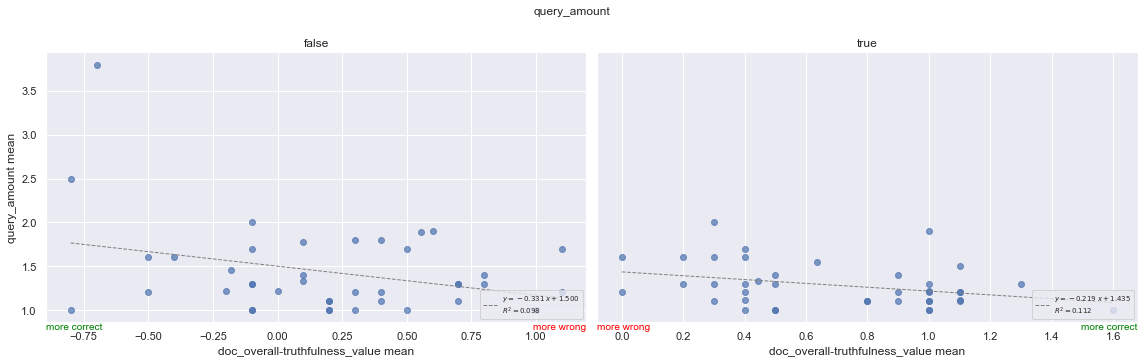

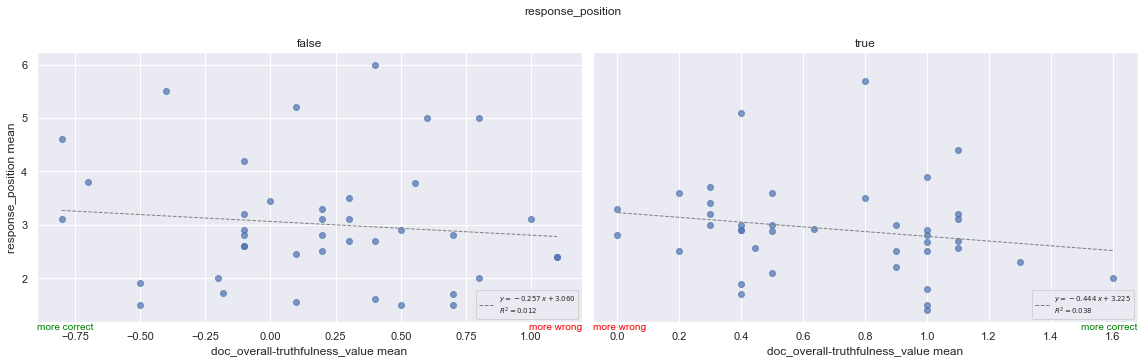

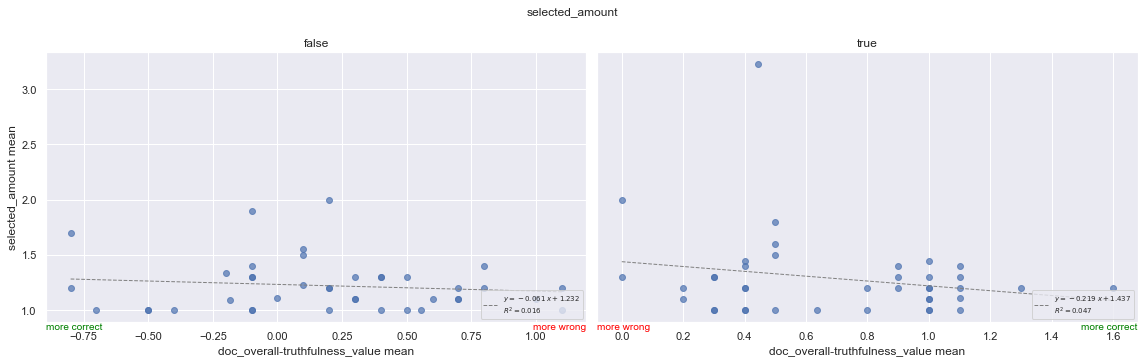

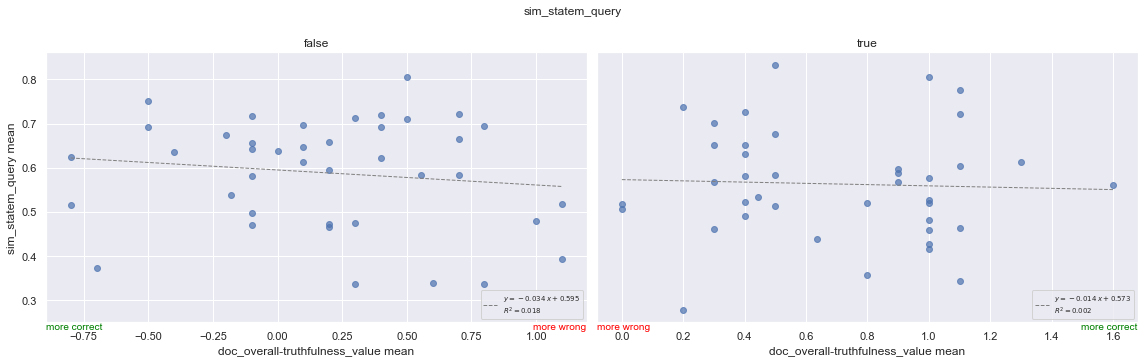

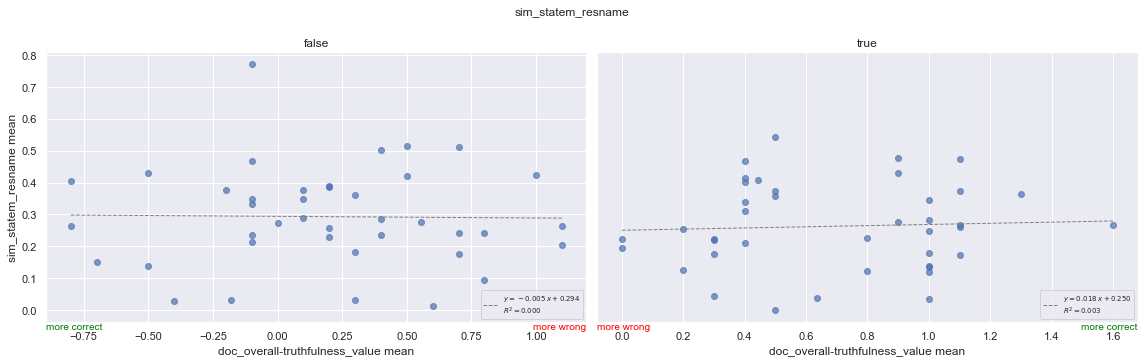

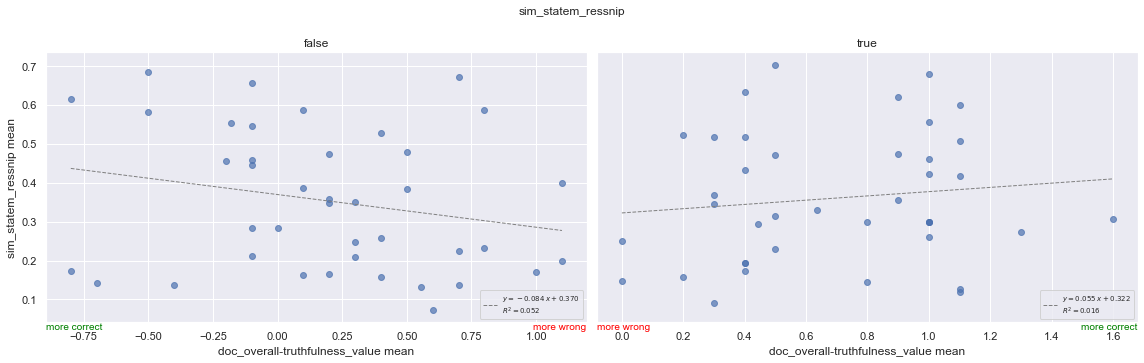

In [20]:
false_labs=['negative','pants-on-fire']
true_labs=['positive','true']

d = pd.read_csv("../Dati/multidimensional.csv")
d=d.loc[d['doc_name']!='DEM_BARELYTRUE_doc7']

d['q_1_farmers_value']=d['q_1_farmers_value'].map(lambda x: 'correct value' if x==3 else 'wrong value')
d['q_2_marks_value']=d['q_2_marks_value'].map(lambda x: 'correct value' if x==9 else 'wrong value')
d['q_3_athletics_value']=d['q_3_athletics_value'].map(lambda x: 'correct value' if x==4 else 'wrong value')
d['q_0_school_answer']=d['q_0_school_answer'].map(shorten_school)

d=d.loc[(d['doc_ground_truth_abc_label']==false_labs[0]) | 
        (d['doc_ground_truth_abc_label']==true_labs[0]) |
        (d['doc_ground_truth_politifact_label']==false_labs[1])|
        (d['doc_ground_truth_politifact_label']==true_labs[1])]

d.loc[(d['doc_ground_truth_abc_label']==false_labs[0]) | (d['doc_ground_truth_politifact_label']==false_labs[1]),'type']='false'
d.loc[(d['doc_ground_truth_abc_label']==true_labs[0]) | (d['doc_ground_truth_politifact_label']==true_labs[1]),'type']='true'

transf_data(d, transf_cols)
data=d[columns+['doc_statement','type','fre']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url'], axis=1)

data=data.groupby(['type', 'doc_statement'], as_index = False).mean().sort_values(by=['type','doc_overall-truthfulness_value'])

cols=data.columns.values
cols = cols[ ~np.isin(cols, ['type','doc_statement']) ]
left, width = 0, 1
bottom, height = 0, 1
right = left + width
top = bottom + height
for c in cols:
        fig, axs = plt.subplots(1,2,figsize=(16, 5),  sharey=True)
        axs[1].get_yaxis().set_visible(False)
        for t,ax in zip(data.type.unique(), axs.flatten()):
                x=data.loc[data.type==t,'doc_overall-truthfulness_value']
                y=data.loc[data.type==t,c]
                z = np.polyfit(x, y, 1)
                y_hat = np.poly1d(z)(x)
                
                text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
                ax.plot(x, y_hat, c="gray", lw=1, label=text, linestyle='dashed')
                ax.legend(loc='lower right', fontsize=7)
                
                ax.scatter(data.loc[data.type==t,'doc_overall-truthfulness_value'], data.loc[data.type==t,c], alpha=.7)
                ax.set_title(t)
                ax.set_xlabel('doc_overall-truthfulness_value mean')
                ax.set_ylabel(f'{c} mean')
                
                
                if c in transf_cols.keys():
                        min=int(np.trunc(data[c].min()))
                        max=int(np.ceil(data[c].max()))
                        ax.set_yticks(range(min,max+1))
                        ax.set_yticklabels(transf_cols[c][min:max+1])
                elif (c.endswith('_value') and c.startswith('doc_')):
                        min=int(np.trunc(data[c].min()))
                        max=int(np.ceil(data[c].max()))
                        ax.set_yticks(range(-2,3))
                        ax.set_yticklabels([
                                        'completely-disagree',
                                        'disagree',
                                        'neither-agree-nor-disagree',
                                        'agree',
                                        'completely-agree'
                                        ])
                        
                if t == 'false':
                        sx='more correct'
                        dx='more wrong'
                        color_sx='green'
                        color_dx='red'
                else:
                        sx='more wrong'
                        dx='more correct'
                        color_sx='red'
                        color_dx='green'
                        
                ax.text(left, bottom, sx,
                        horizontalalignment='left',
                        verticalalignment='top',
                        color=color_sx,
                        transform=ax.transAxes)
                ax.text(right, bottom, dx,
                        horizontalalignment='right',
                        verticalalignment='top',
                        color=color_dx,
                        transform=ax.transAxes)

        fig.suptitle(f"{c}", y=1)
        fig.tight_layout()
        pathlib.Path(f"../Dati/trend_plots").mkdir(parents=True, exist_ok=True) 
        fig.savefig(f'../Dati/trend_plots/trend_{c}.png',  bbox_inches='tight')

In [21]:
create_collage(13000, 1500, 11,3, [f"../Dati/trend_plots/trend_{c}.png" for c in  cols], '../Dati/pics/trends_collage.png')

0 0 0
1 0 502
2 0 1004
3 1183 0
4 1183 502
5 1183 1004
6 2366 0
7 2366 502
8 2366 1004
9 3549 0
10 3549 502
11 3549 1004
12 4732 0
13 4732 502
14 4732 1004
15 5915 0
16 5915 502
17 5915 1004
18 7098 0
19 7098 502
20 7098 1004
21 8281 0
22 8281 502
23 8281 1004
24 9464 0
25 9464 502
26 9464 1004
27 10647 0
28 10647 502
29 10647 1004
30 11830 0
31 11830 502
32 11830 1004


<ipython-input-22-fc7d35756606>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,2,figsize=(16, 5),  sharey=True)


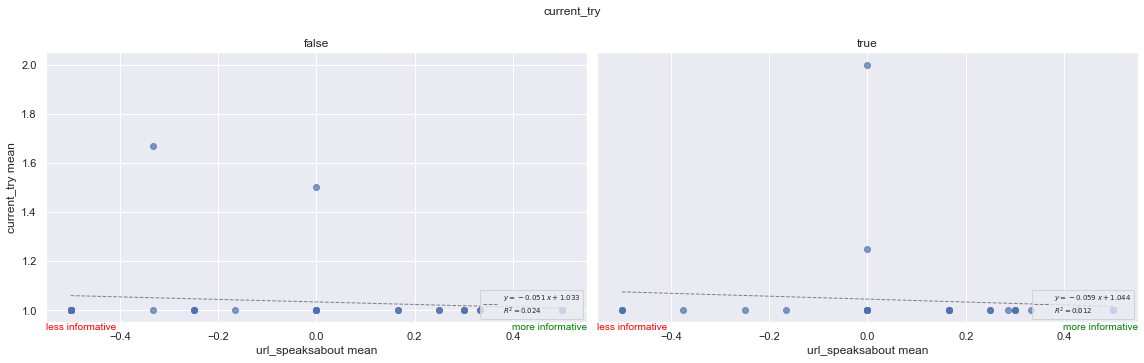

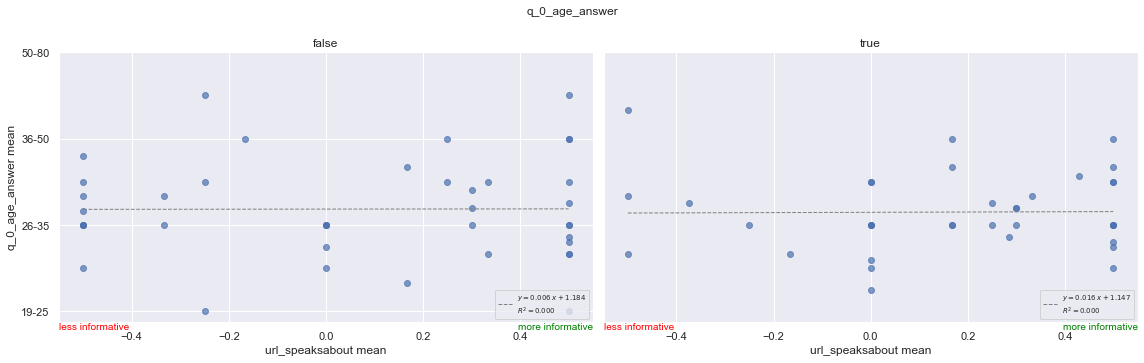

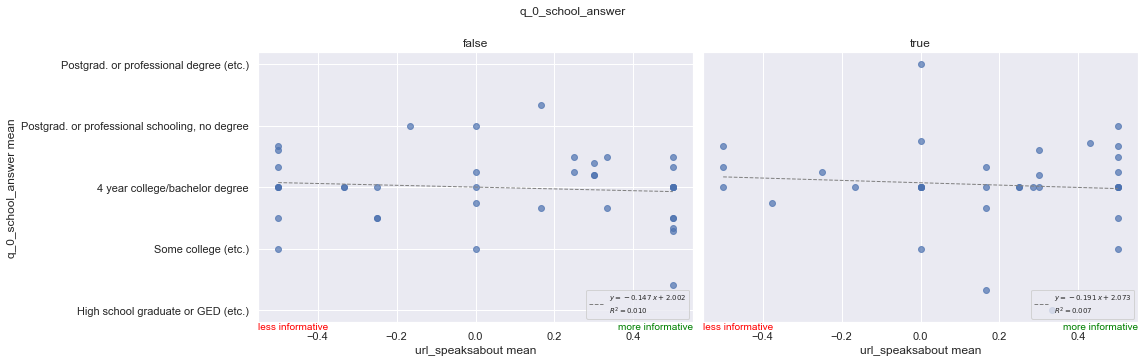

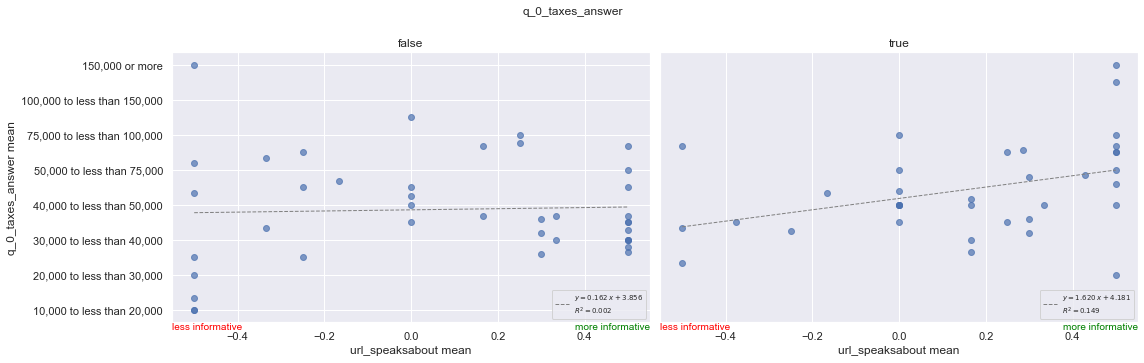

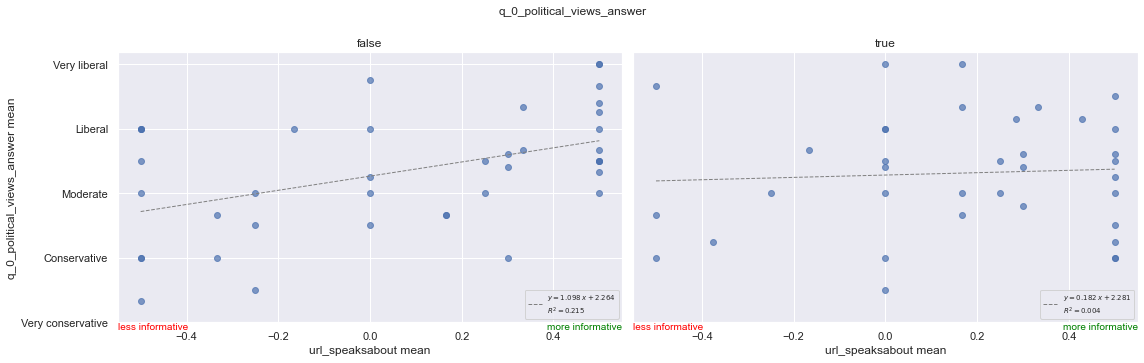

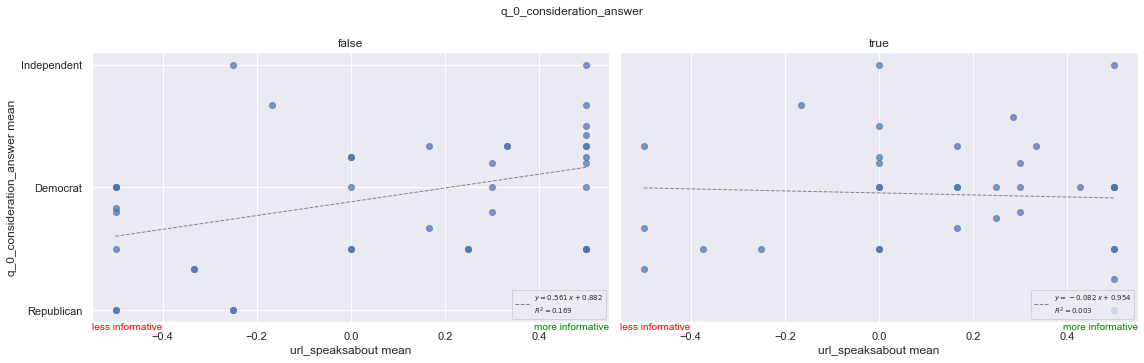

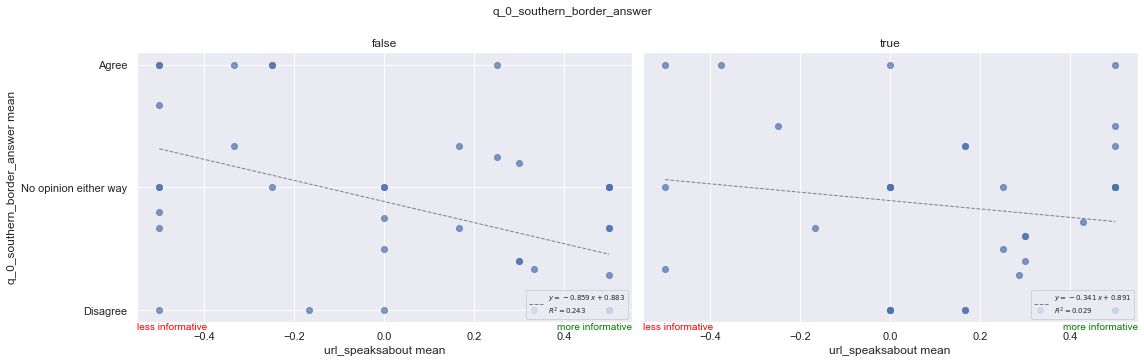

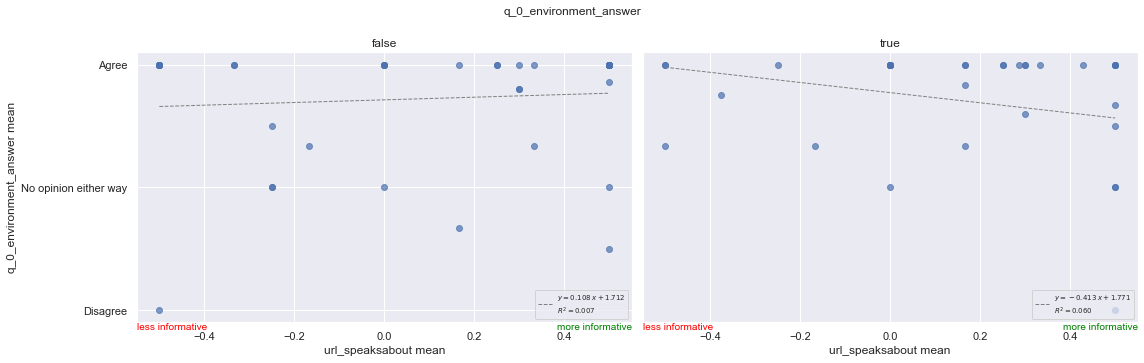

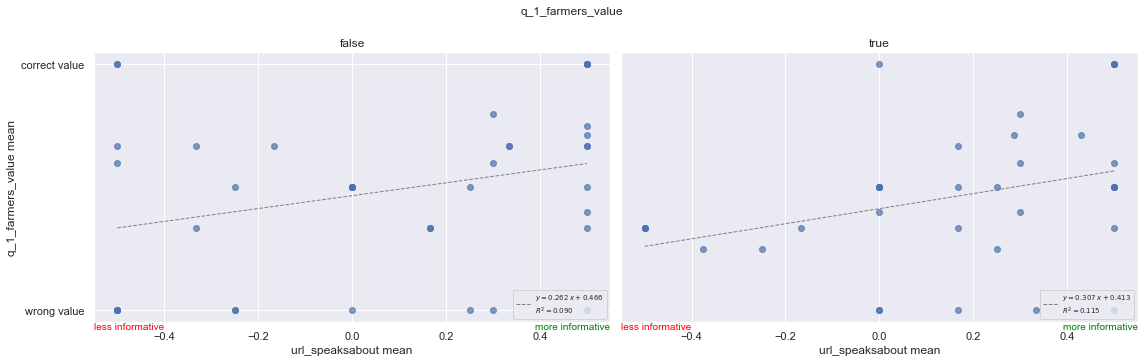

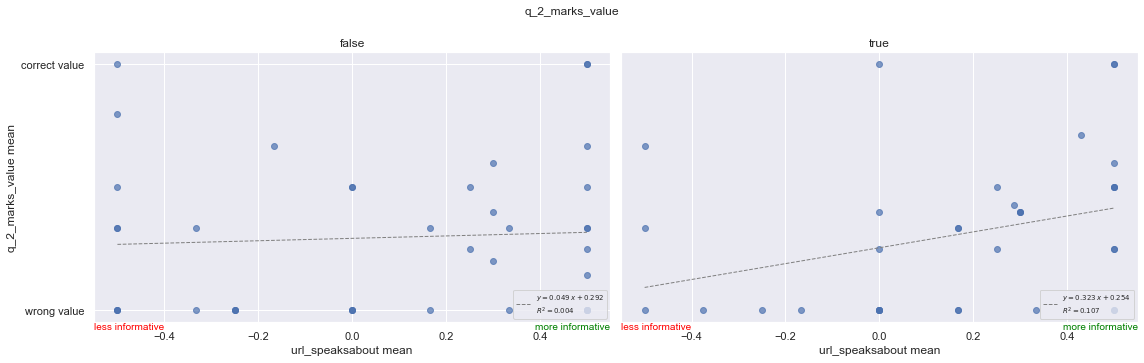

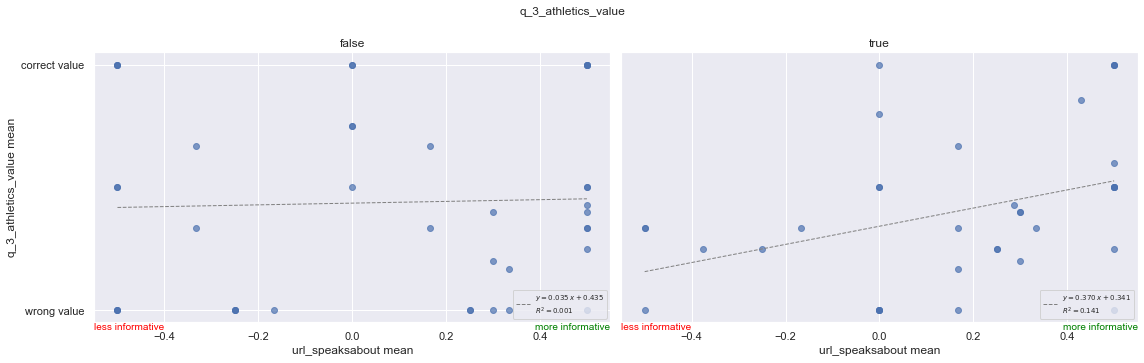

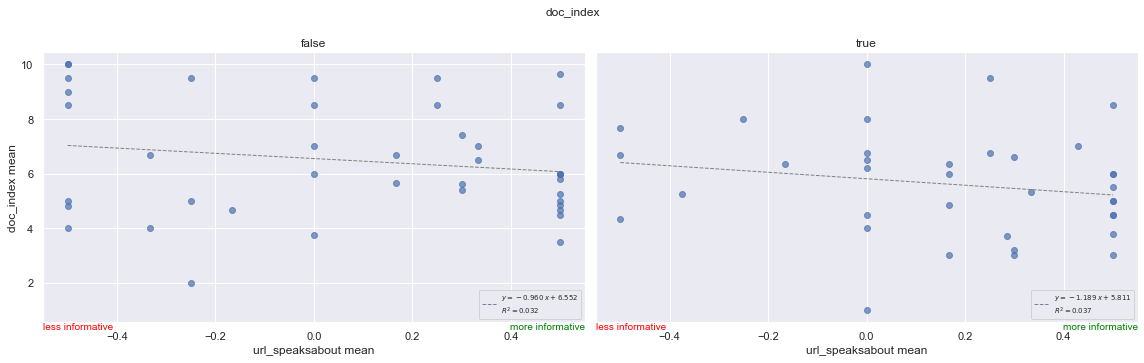

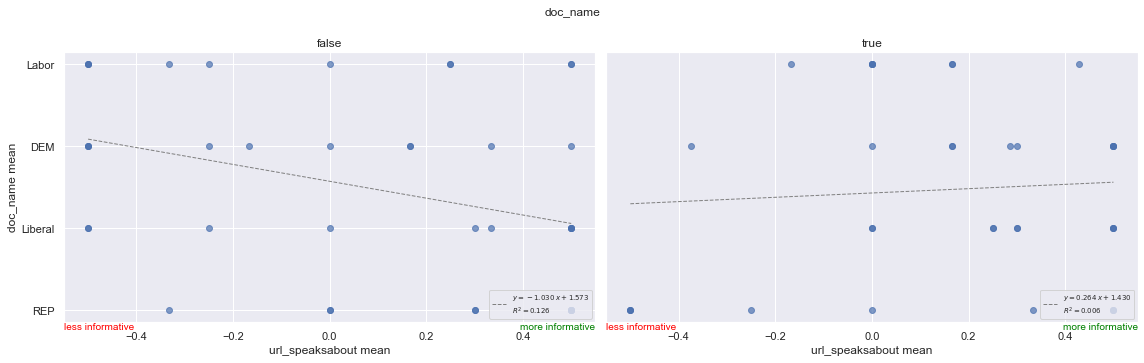

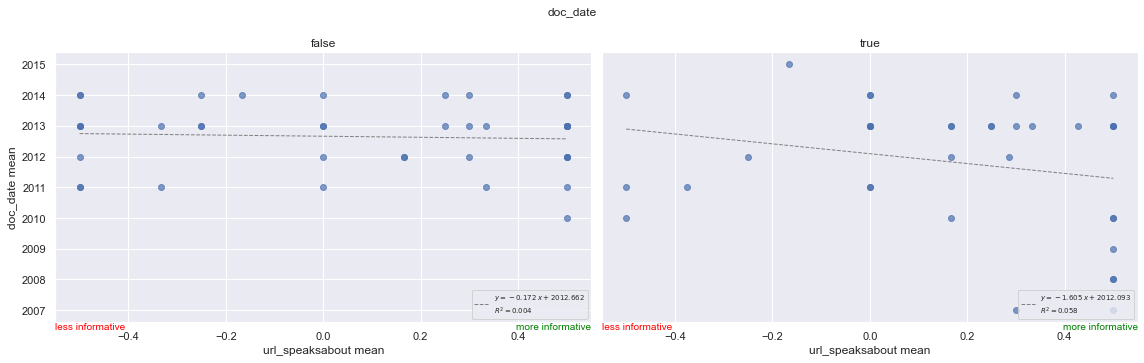

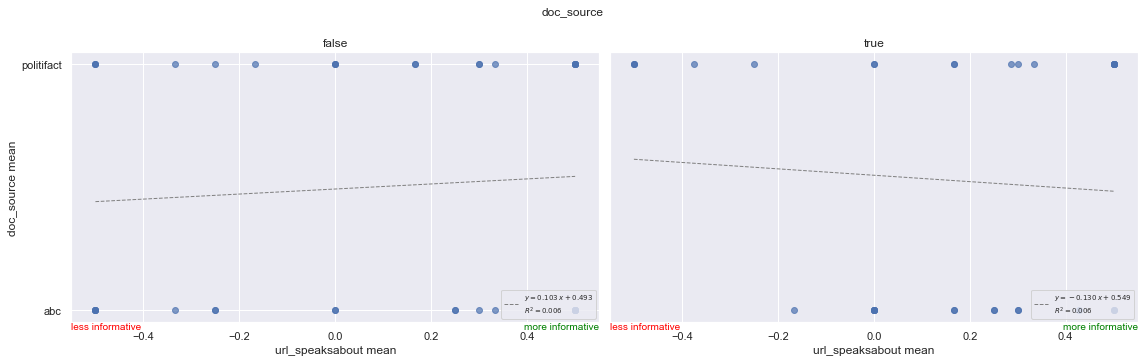

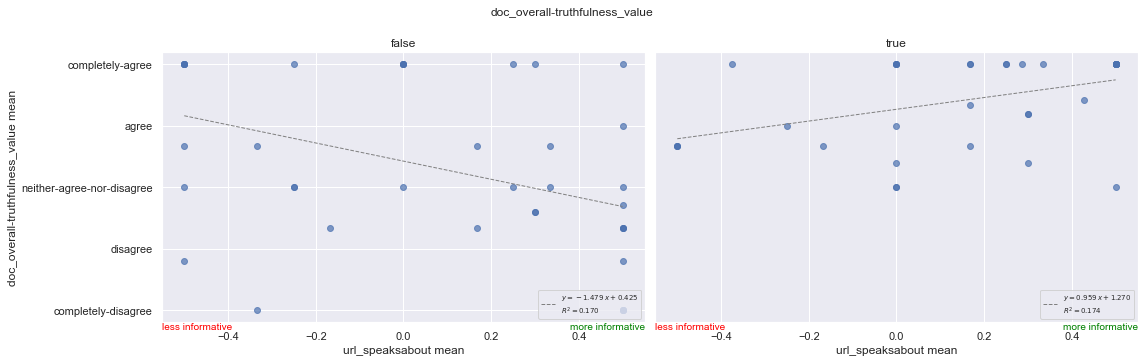

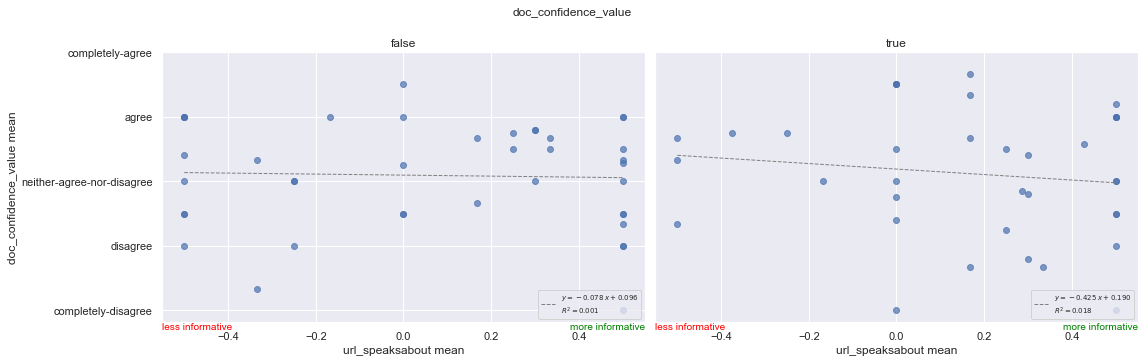

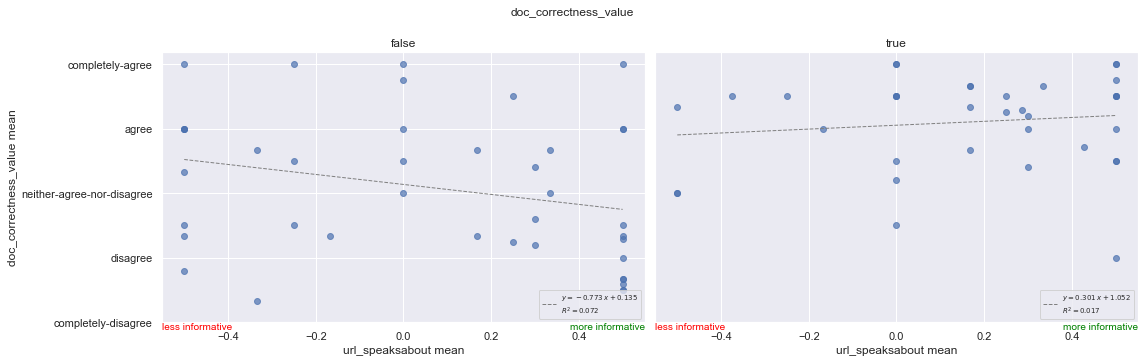

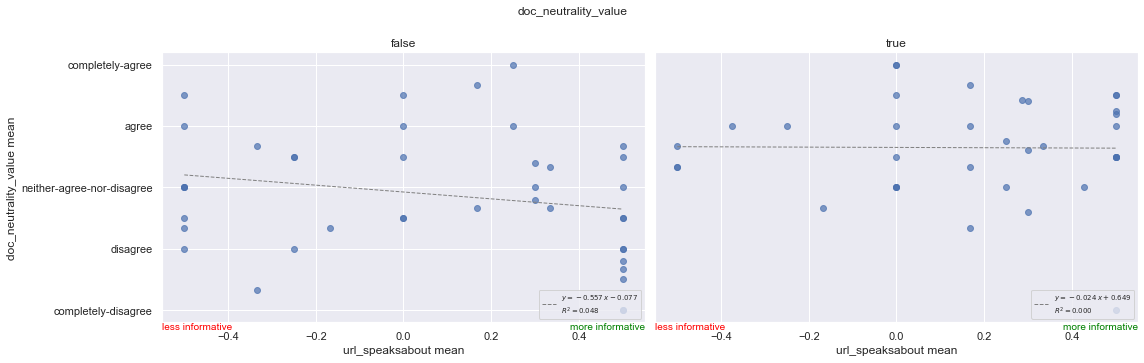

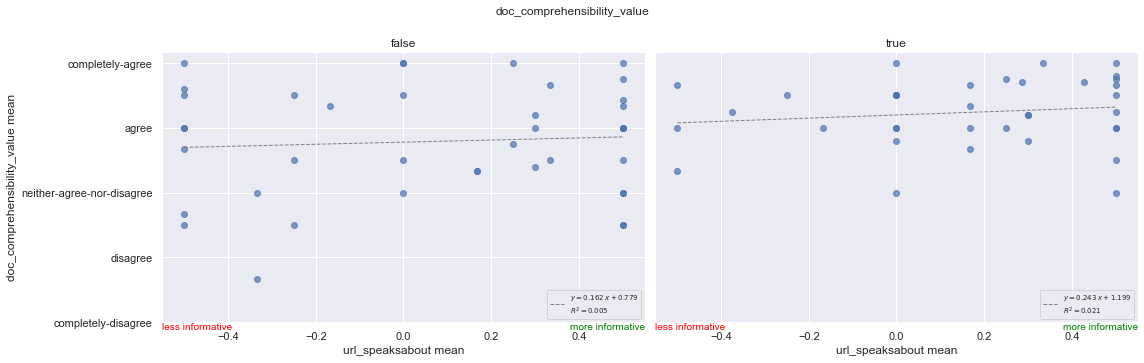

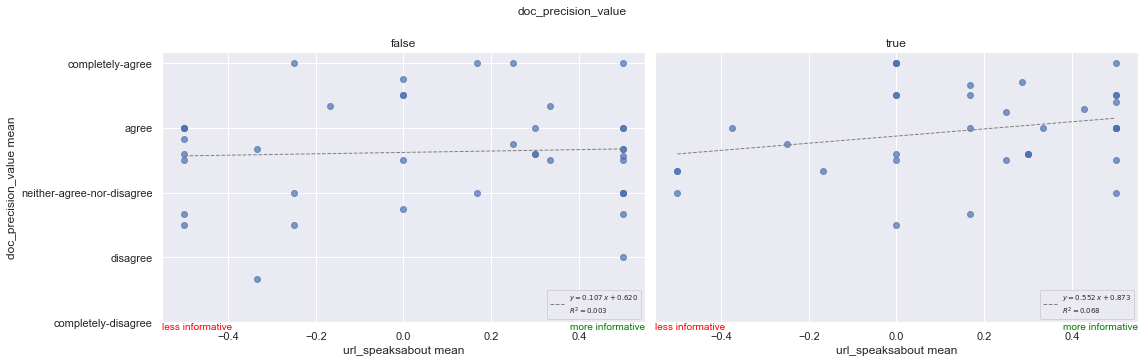

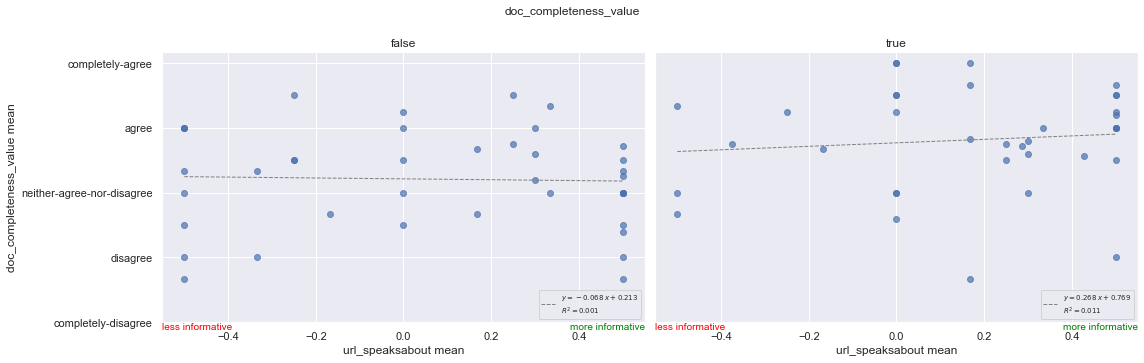

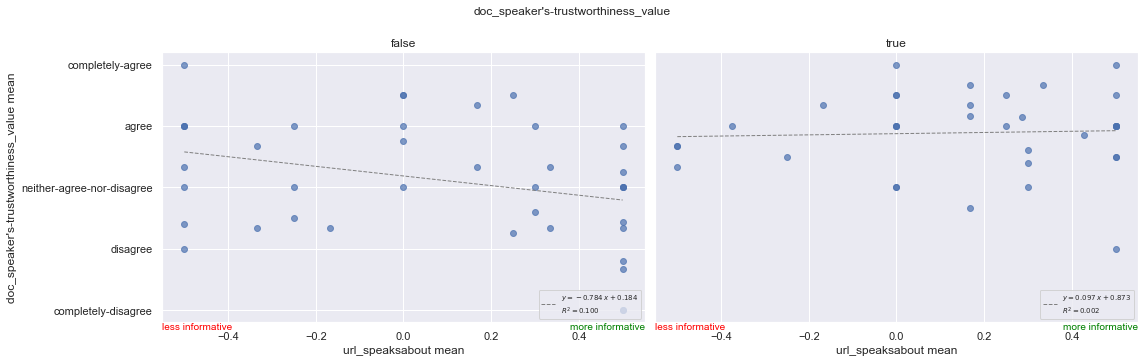

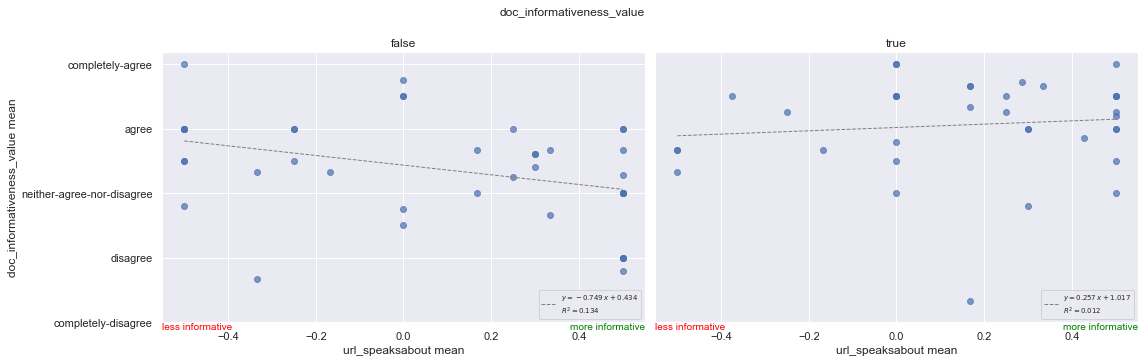

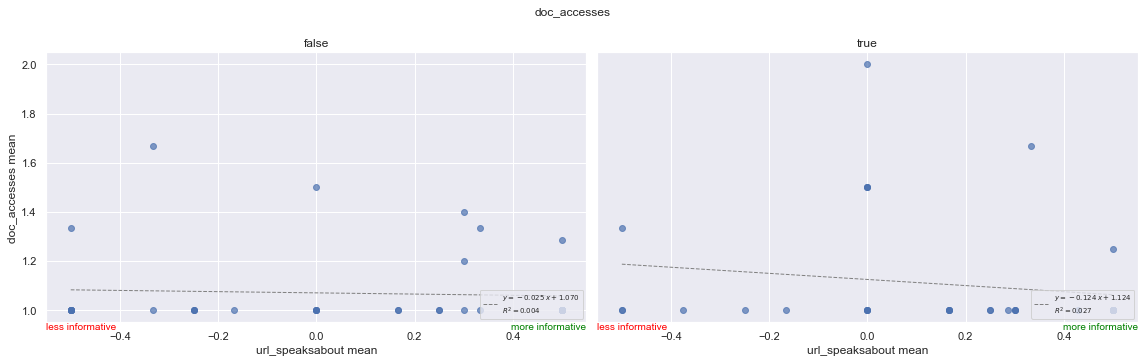

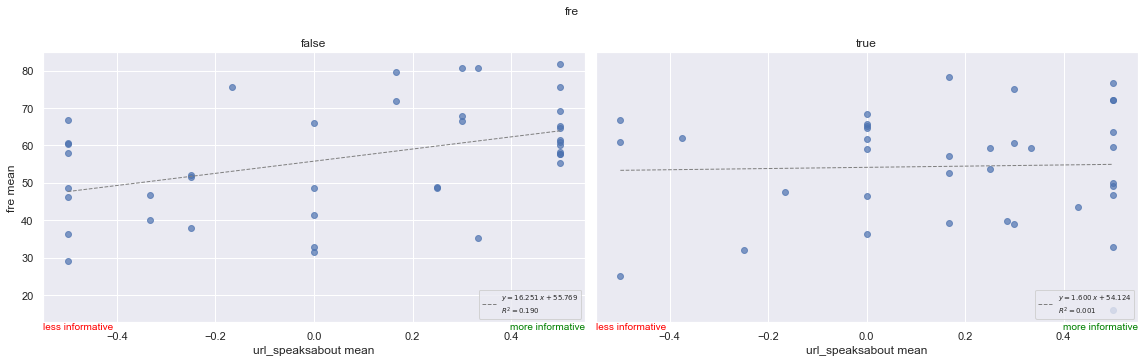

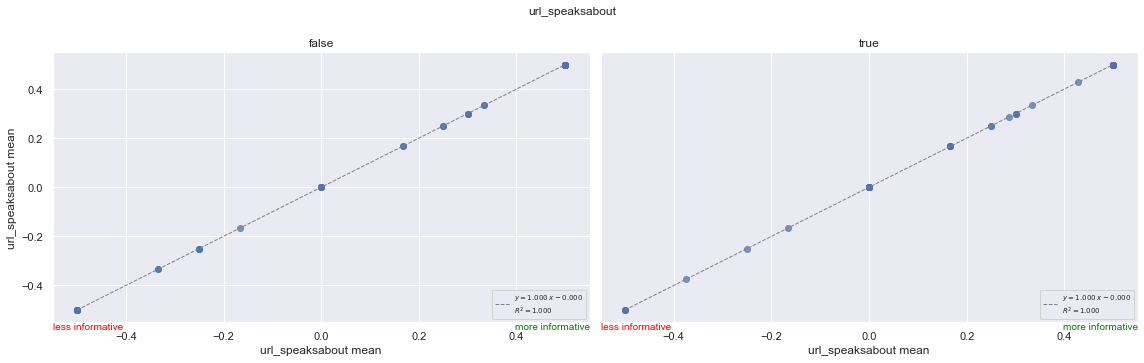

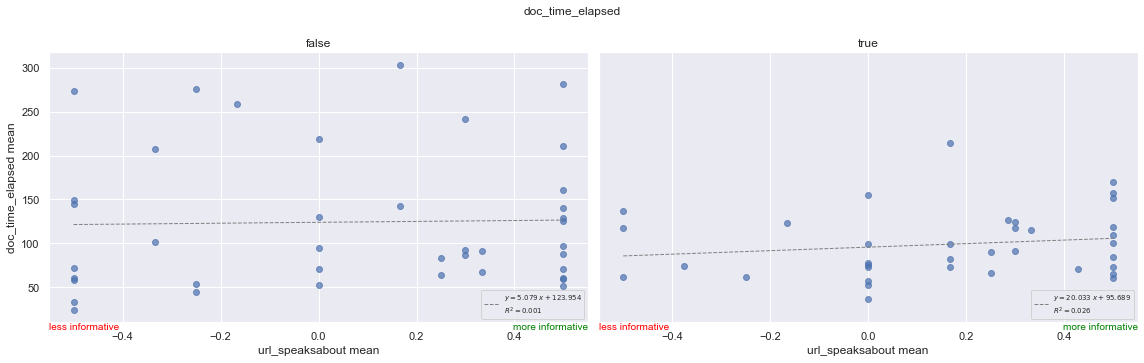

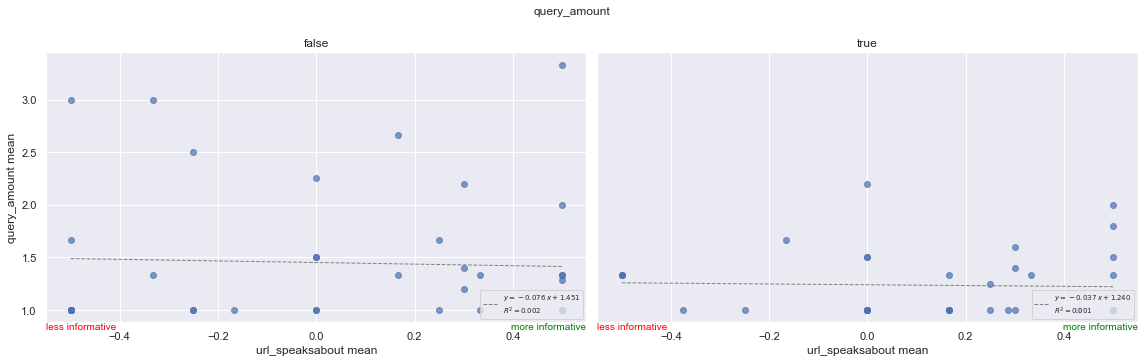

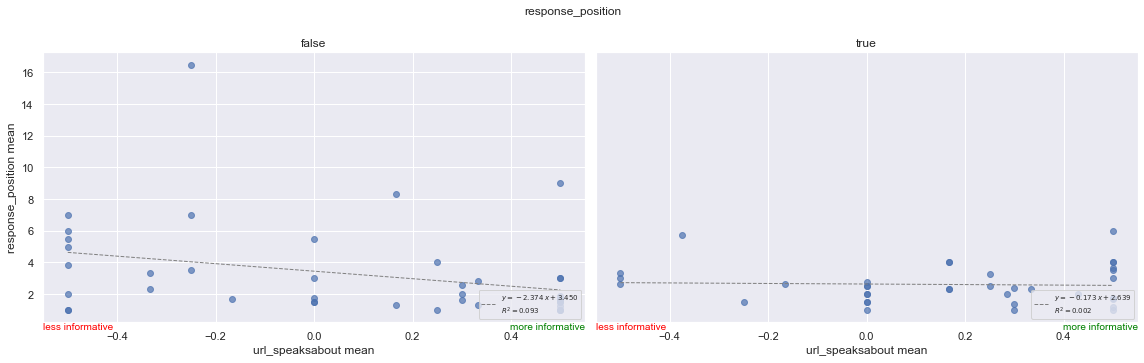

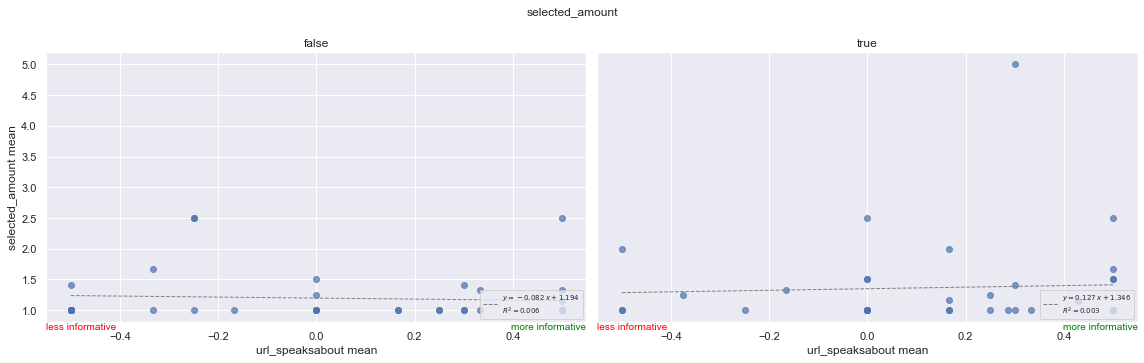

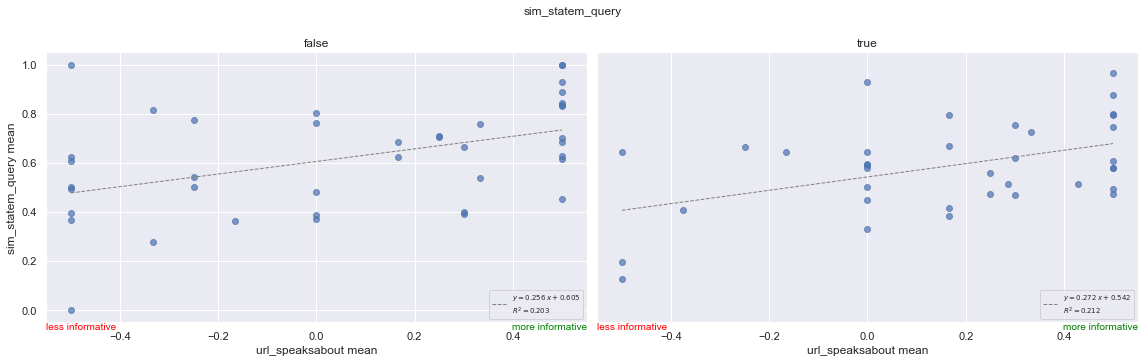

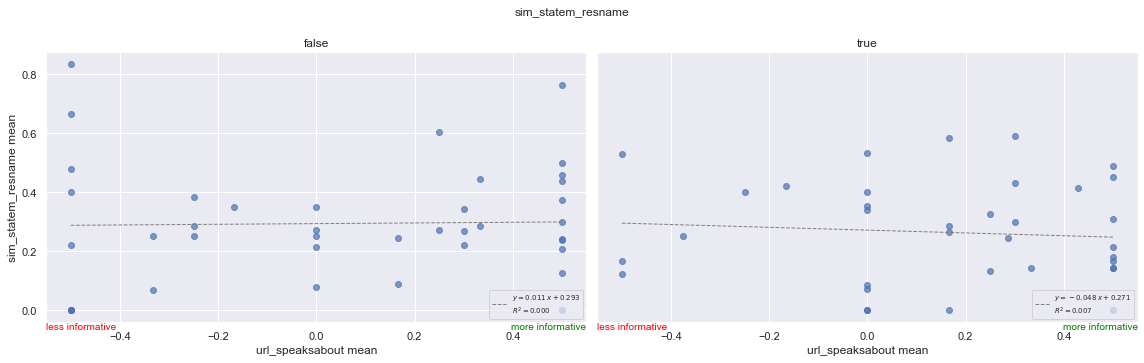

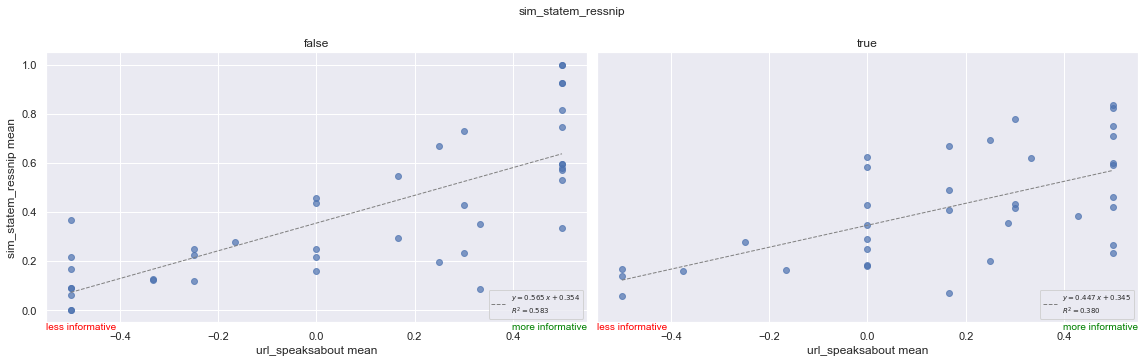

In [22]:
d = pd.read_csv("../Dati/all_rows.csv")

d['type']=d['type'].map(lambda x: x.split('_')[1])

transf_data(d, transf_cols)
data=d[columns+['doc_statement','type','fre', 'url_speaksabout']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url'], axis=1)

data=data.groupby(['type', 'doc_statement'], as_index = False).mean().sort_values(by=['type','url_speaksabout'])


cols=data.columns.values
cols = cols[ ~np.isin(cols, ['type','doc_statement']) ]
left, width = 0, 1
bottom, height = 0, 1
right = left + width
top = bottom + height
for c in cols:
        fig, axs = plt.subplots(1,2,figsize=(16, 5),  sharey=True)
        axs[1].get_yaxis().set_visible(False)
        for t,ax in zip(data.type.unique(), axs.flatten()):
                x=data.loc[data.type==t,'url_speaksabout']
                y=data.loc[data.type==t,c]
                z = np.polyfit(x, y, 1)
                y_hat = np.poly1d(z)(x)
                
                text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
                ax.plot(x, y_hat, c="gray", lw=1, label=text, linestyle='dashed')
                ax.legend(loc='lower right', fontsize=7)
                
                ax.scatter(data.loc[data.type==t,'url_speaksabout'], data.loc[data.type==t,c], alpha=.7)
                ax.set_title(t)
                ax.set_xlabel('url_speaksabout mean')
                ax.set_ylabel(f'{c} mean')

                if c in transf_cols.keys():
                        min=int(np.trunc(data[c].min()))
                        max=int(np.ceil(data[c].max()))
                        ax.set_yticks(range(min,max+1))
                        ax.set_yticklabels(transf_cols[c][min:max+1])
                elif (c.endswith('_value') and c.startswith('doc_')):
                        min=int(np.trunc(data[c].min()))
                        max=int(np.ceil(data[c].max()))
                        ax.set_yticks(range(-2,3))
                        ax.set_yticklabels([
                                        'completely-disagree',
                                        'disagree',
                                        'neither-agree-nor-disagree',
                                        'agree',
                                        'completely-agree'
                                        ])

                sx='less informative'
                dx='more informative'
                color_sx='red'
                color_dx='green'
                        
                ax.text(left, bottom, sx,
                        horizontalalignment='left',
                        verticalalignment='top',
                        color=color_sx,
                        transform=ax.transAxes)
                ax.text(right, bottom, dx,
                        horizontalalignment='right',
                        verticalalignment='top',
                        color=color_dx,
                        transform=ax.transAxes)


        fig.suptitle(f"{c}", y=1)
        fig.tight_layout()
        pathlib.Path(f"../Dati/trend_plots_url").mkdir(parents=True, exist_ok=True) 
        fig.savefig(f'../Dati/trend_plots_url/trend_{c}_url.png',  bbox_inches='tight')

<ipython-input-35-20f5368658bb>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1,figsize=(16, 5))


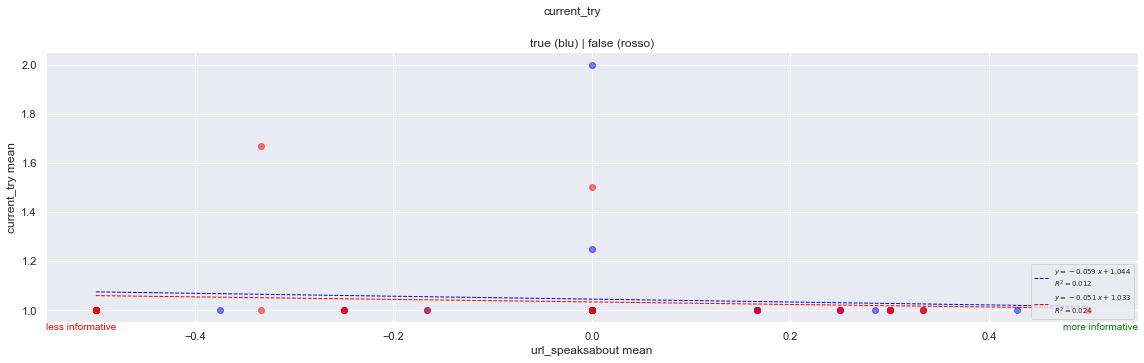

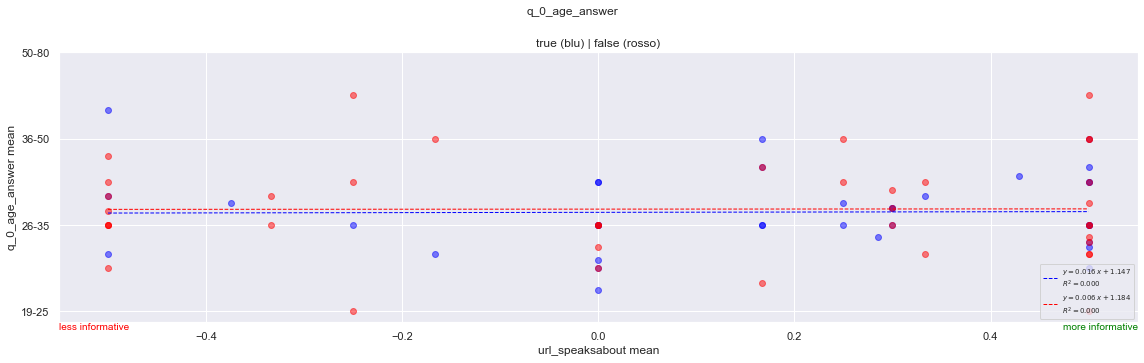

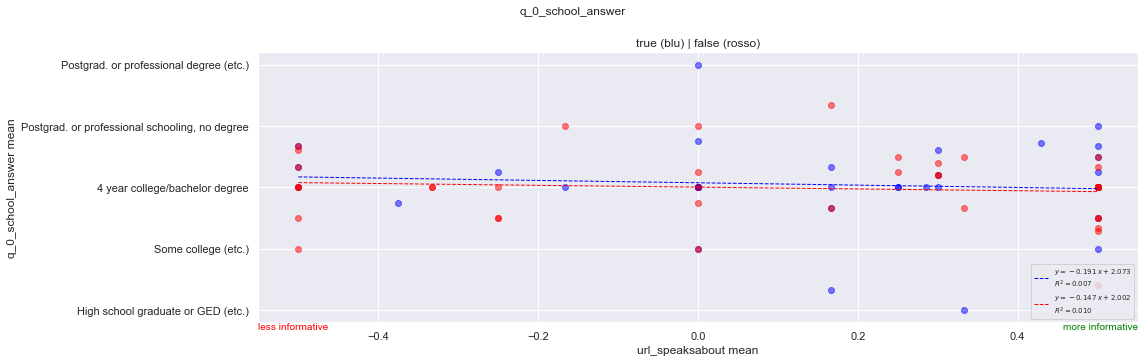

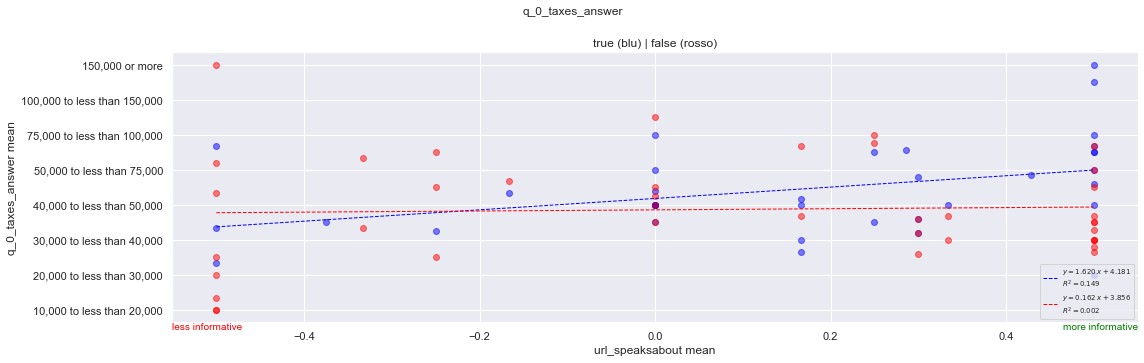

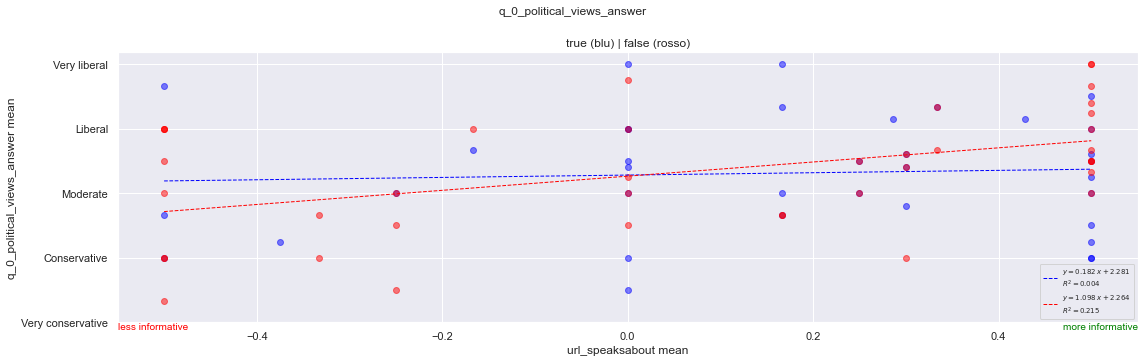

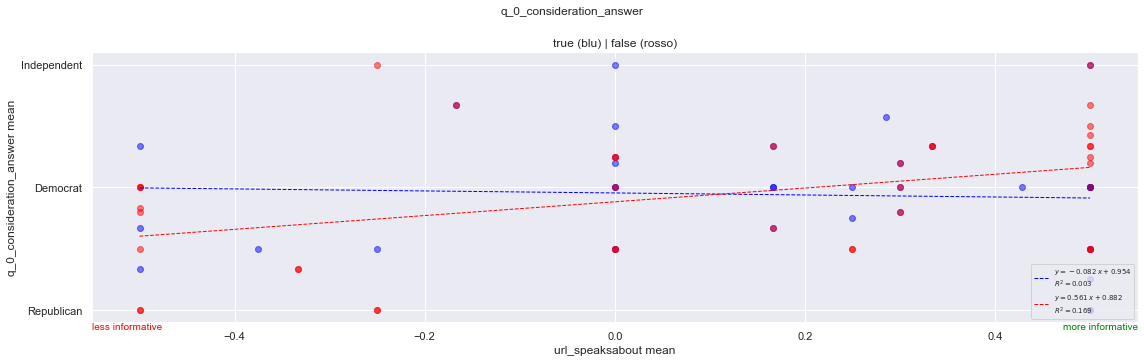

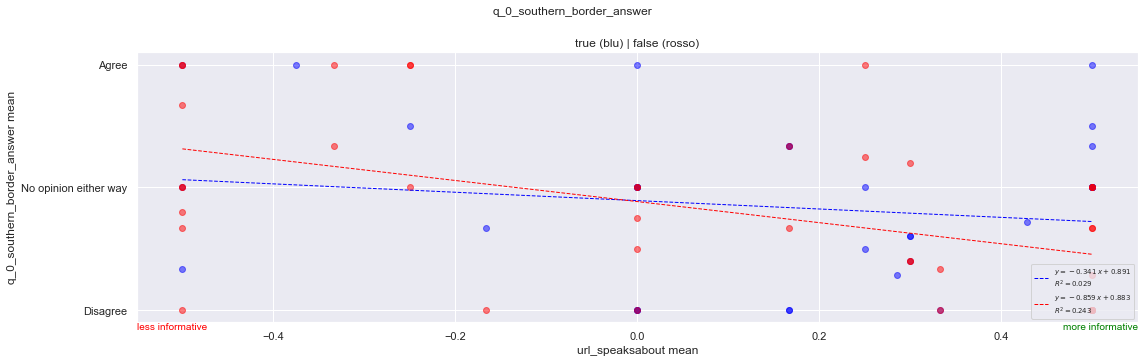

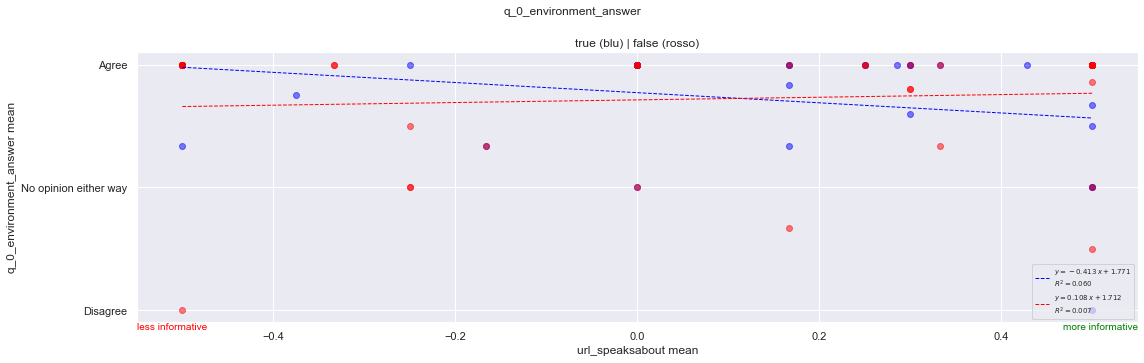

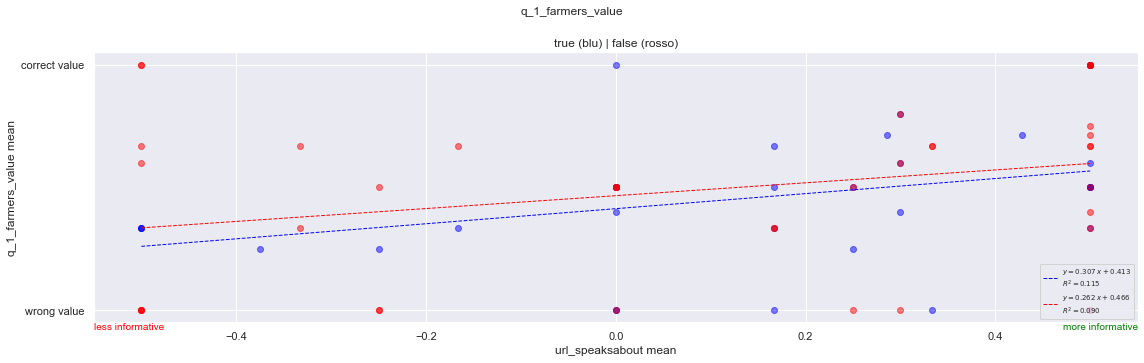

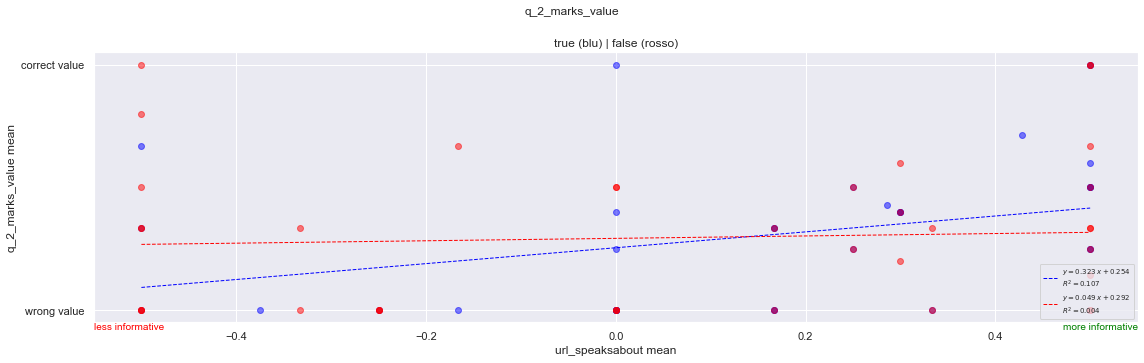

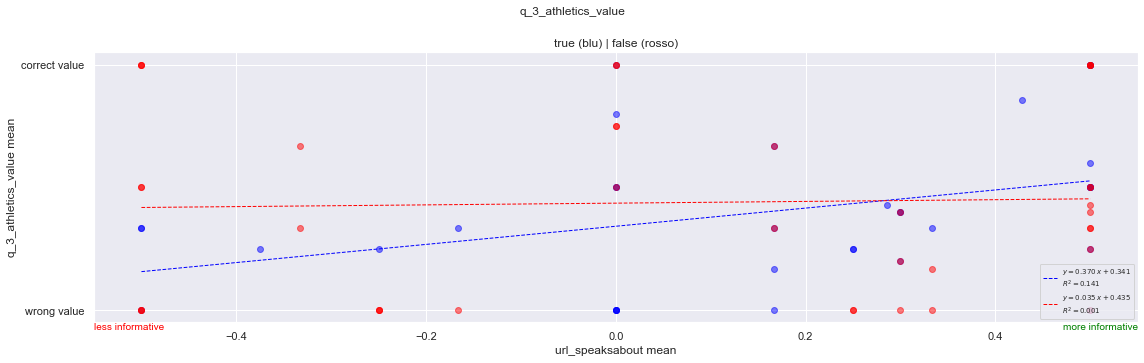

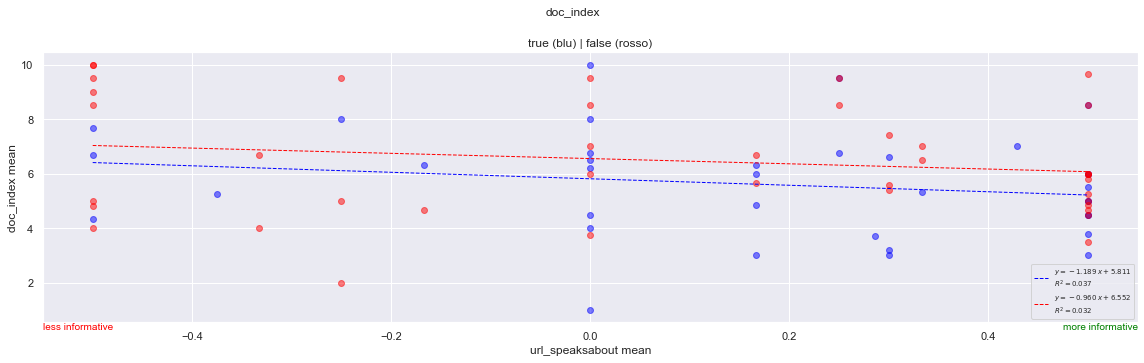

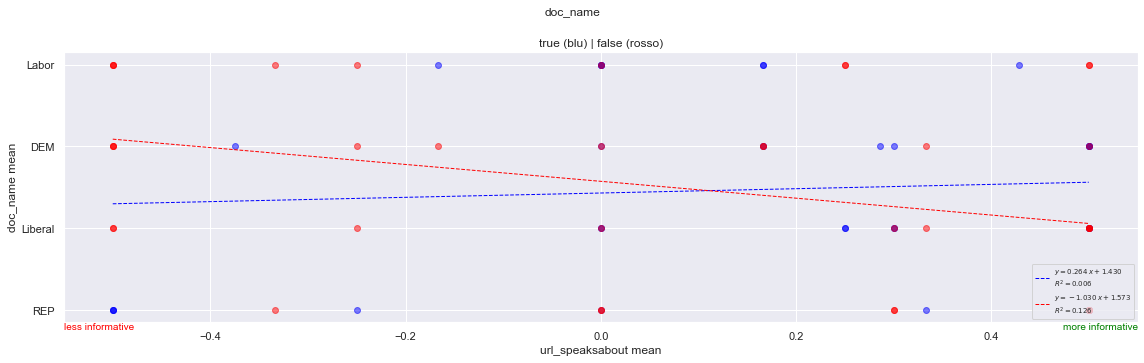

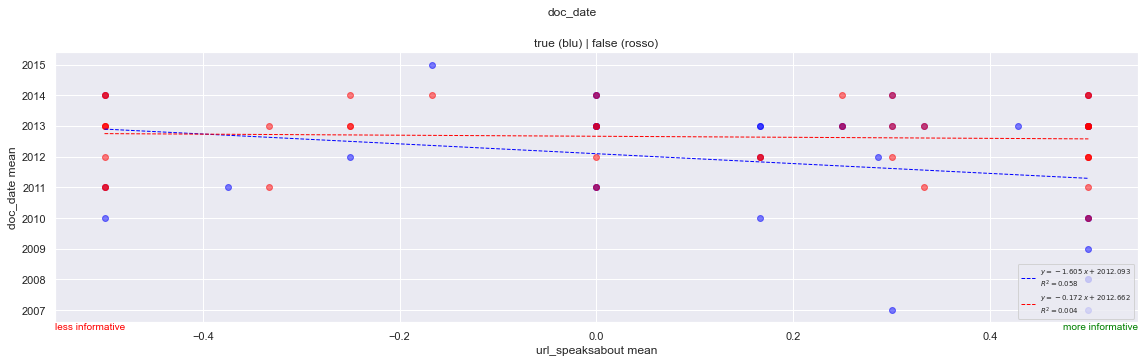

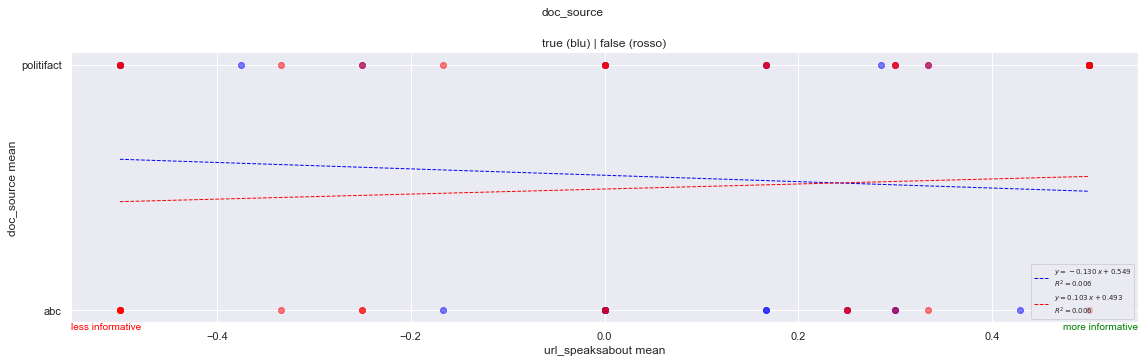

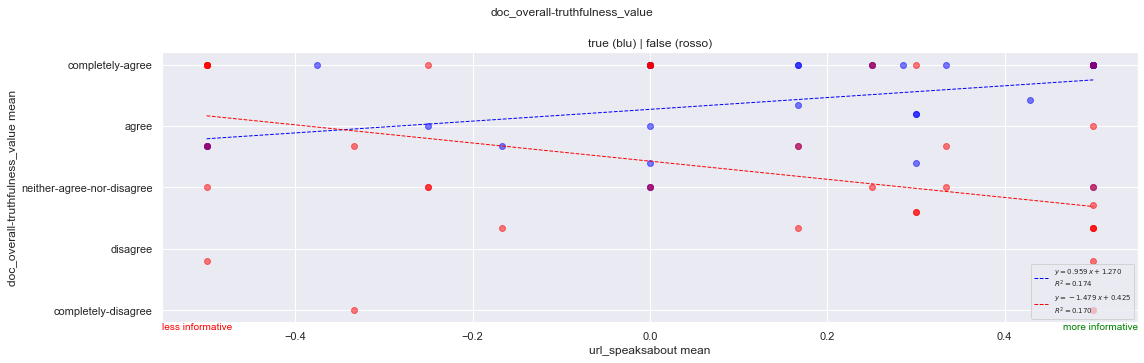

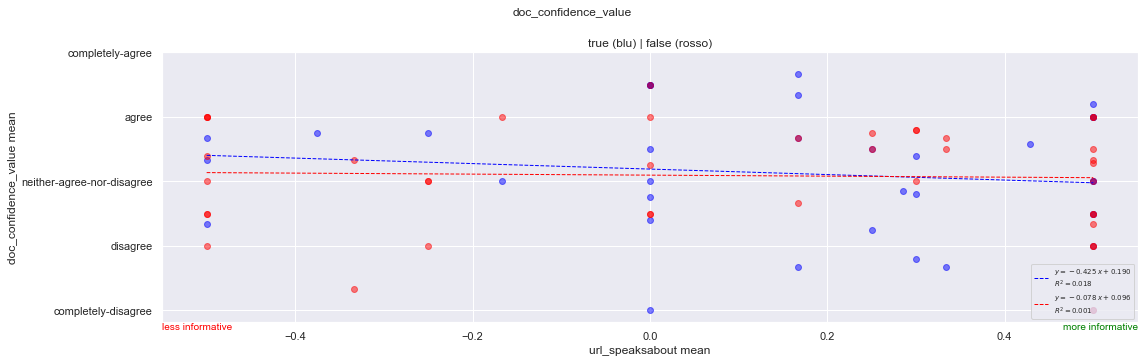

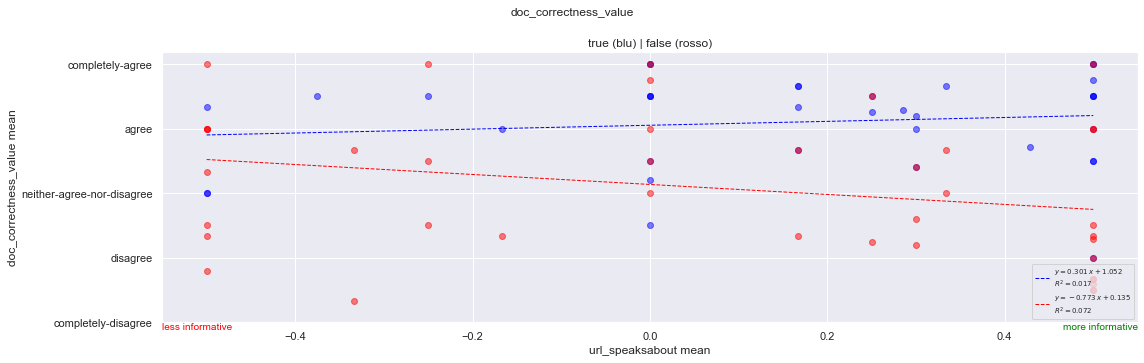

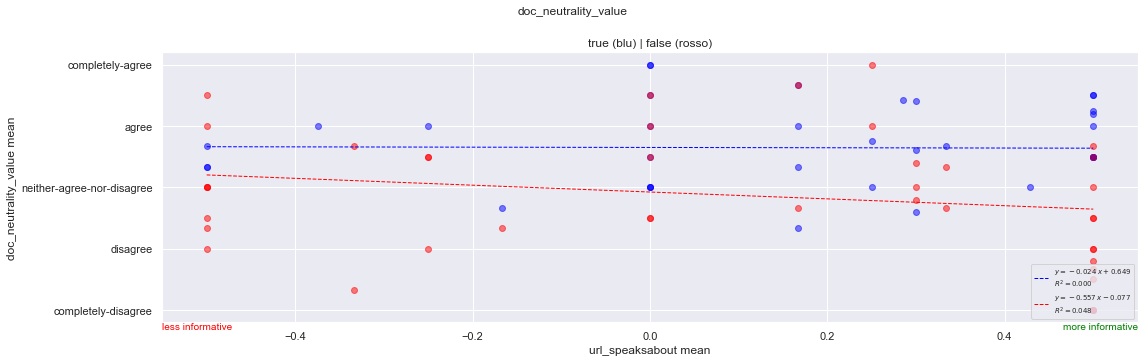

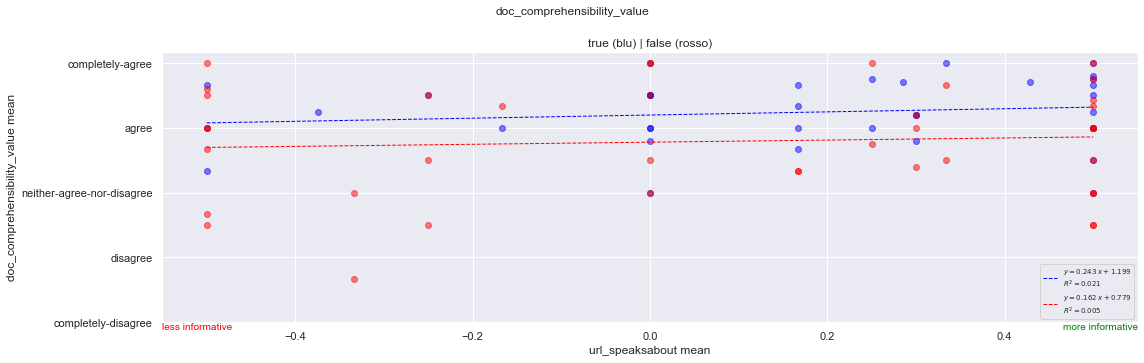

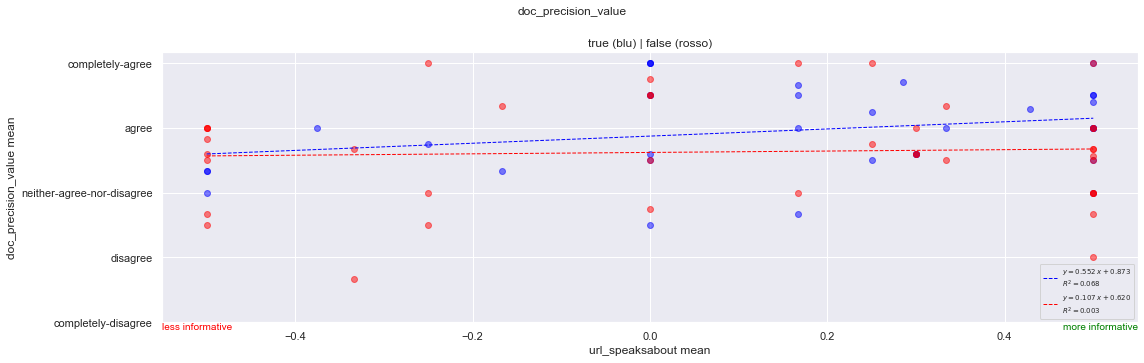

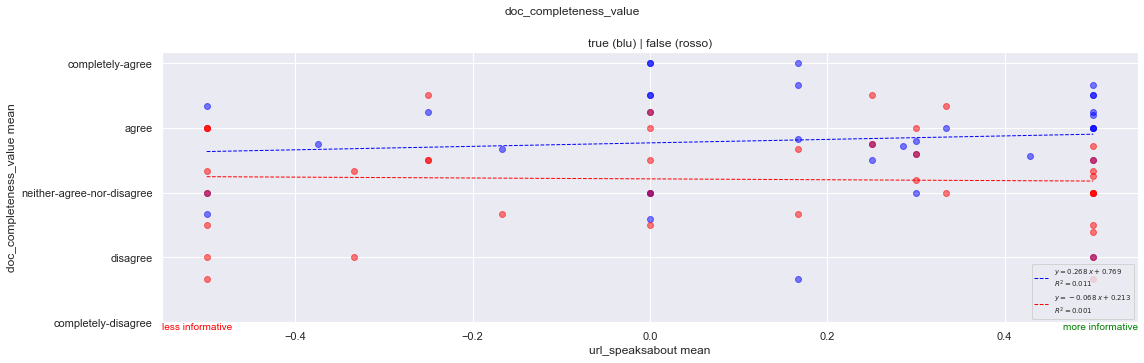

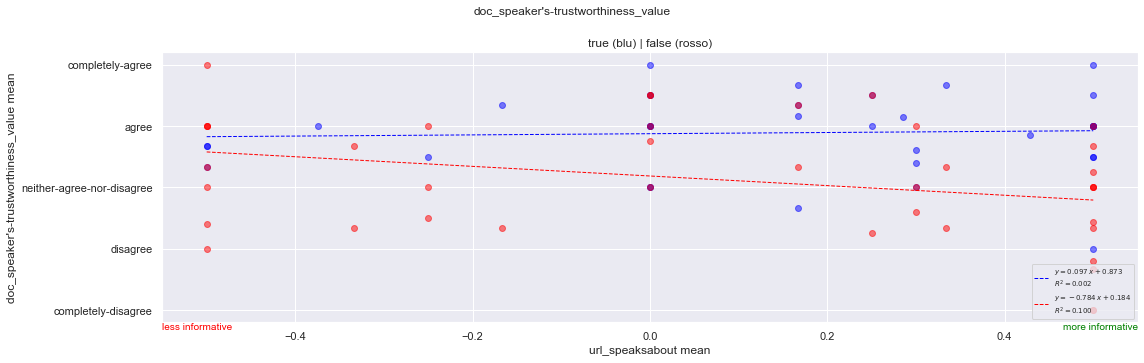

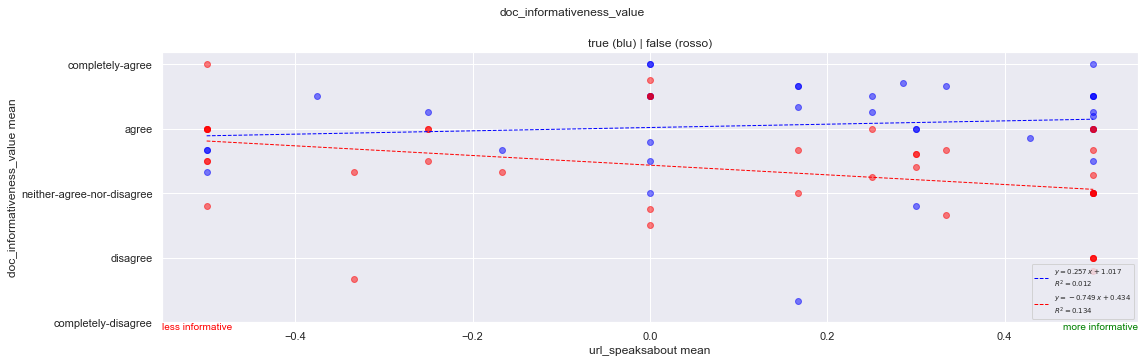

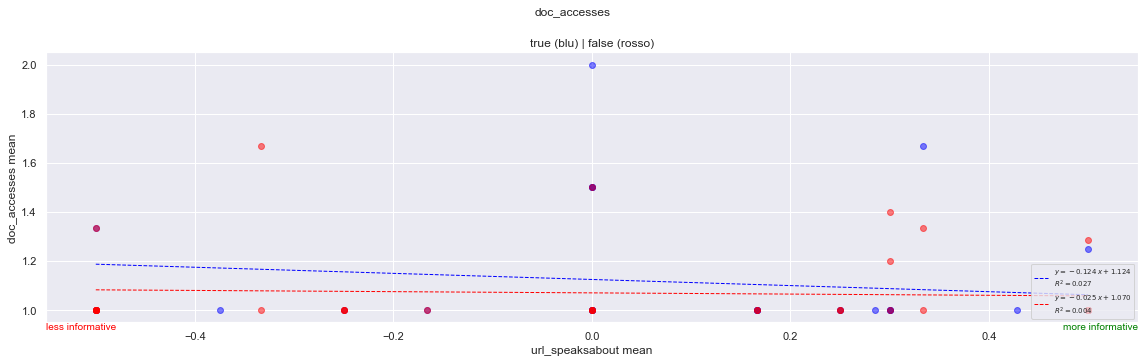

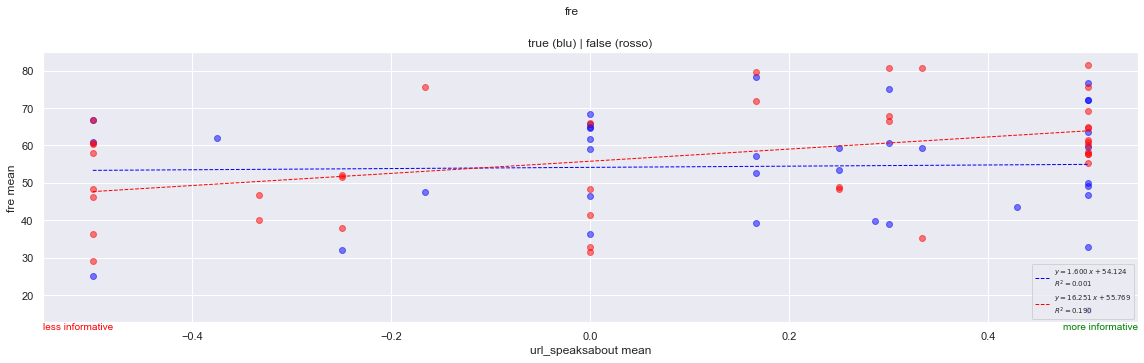

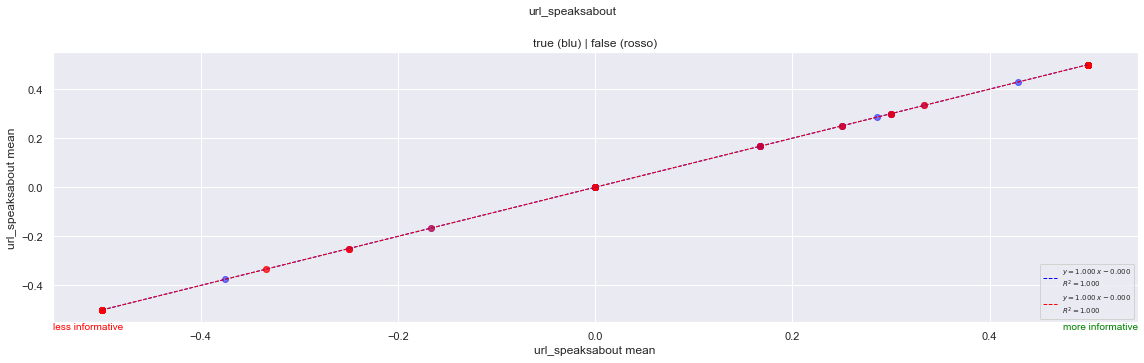

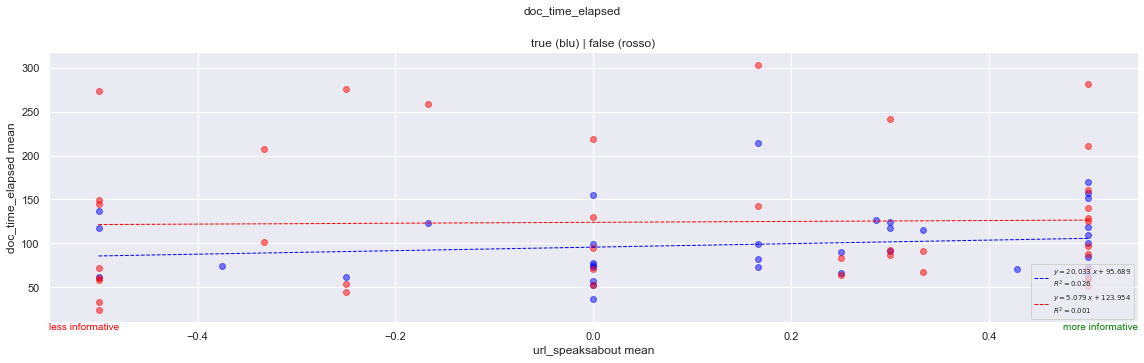

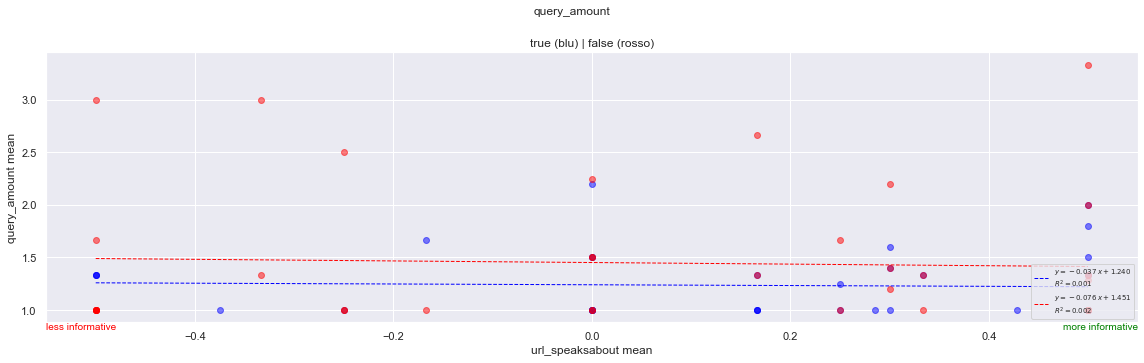

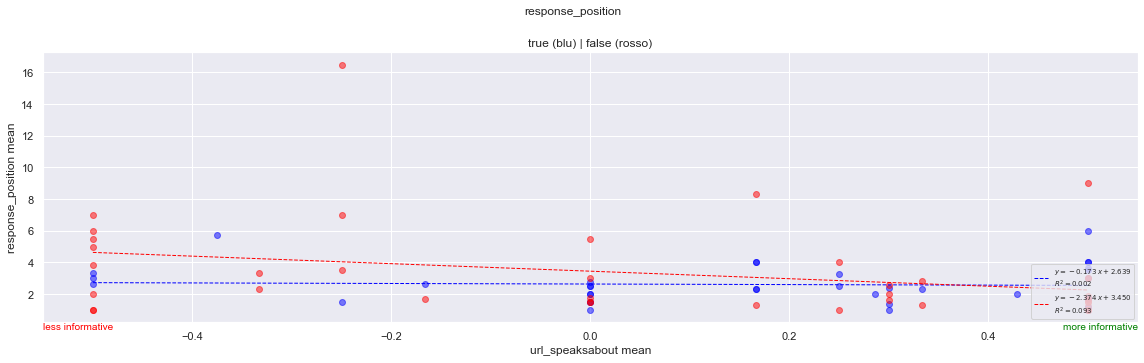

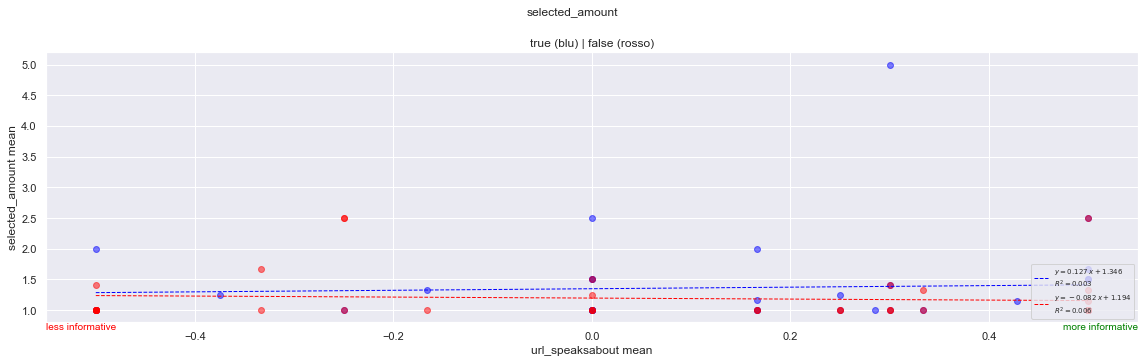

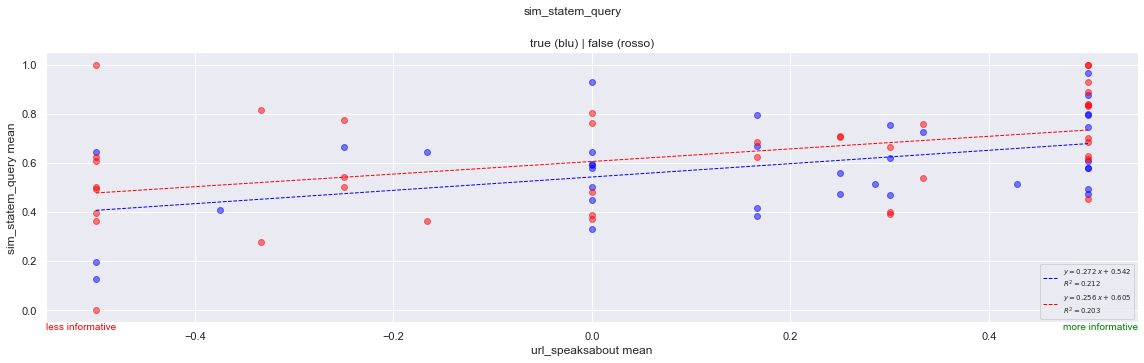

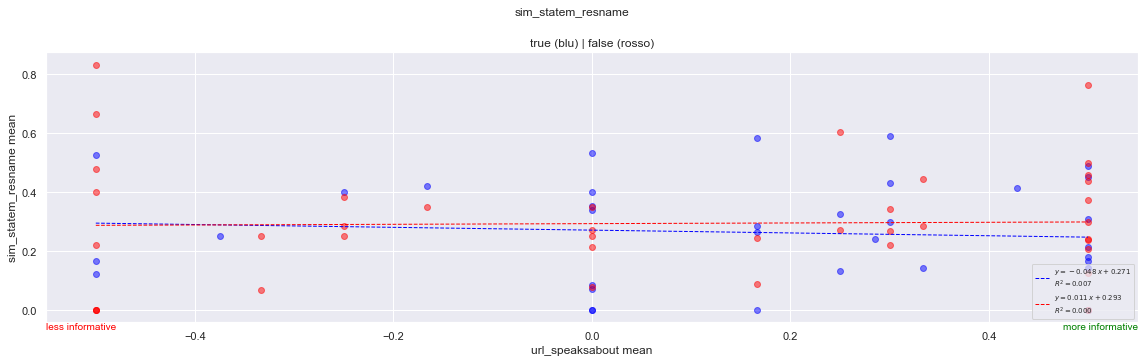

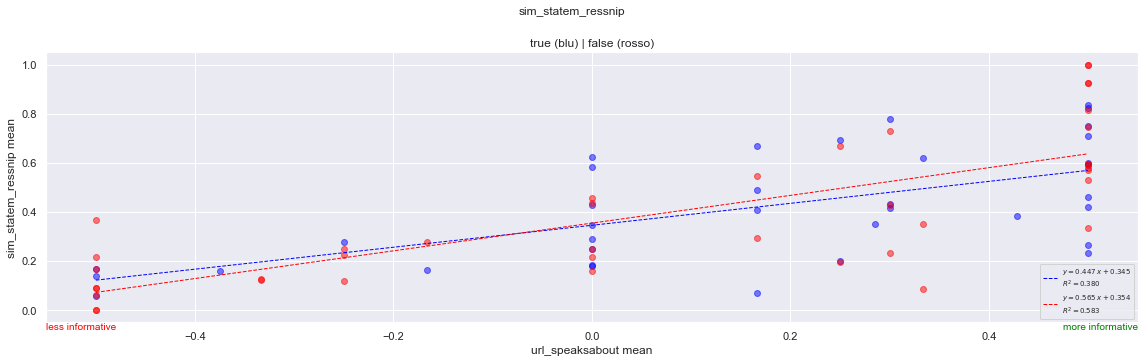

In [35]:
d = pd.read_csv("../Dati/all_rows.csv")

d['type']=d['type'].map(lambda x: x.split('_')[1])

transf_data(d, transf_cols)
data=d[columns+['doc_statement','type','fre', 'url_speaksabout']+columns_other].drop(['doc_claimant', 'doc_overall-truthfulness_url'], axis=1)

data=data.groupby(['type', 'doc_statement'], as_index = False).mean().sort_values(by=['type','url_speaksabout'])


cols=data.columns.values
cols = cols[ ~np.isin(cols, ['type','doc_statement']) ]
left, width = 0, 1
bottom, height = 0, 1
right = left + width
top = bottom + height
for c in cols:
        fig, ax = plt.subplots(1,1,figsize=(16, 5))

        x_t=data.loc[data.type=='true','url_speaksabout']
        y_t=data.loc[data.type=='true',c]
        z_t = np.polyfit(x_t, y_t, 1)
        y_t_hat = np.poly1d(z_t)(x_t)
        
        x_f=data.loc[data.type=='false','url_speaksabout']
        y_f=data.loc[data.type=='false',c]
        z_f = np.polyfit(x_f, y_f, 1)
        y_f_hat = np.poly1d(z_f)(x_f)
        
        text_t = f"$y={z_t[0]:0.3f}\;x{z_t[1]:+0.3f}$\n$R^2 = {r2_score(y_t,y_t_hat):0.3f}$"
        text_f = f"$y={z_f[0]:0.3f}\;x{z_f[1]:+0.3f}$\n$R^2 = {r2_score(y_f,y_f_hat):0.3f}$"
        ax.plot(x_t, y_t_hat, c="blue", lw=1, label=text_t, linestyle='dashed')
        ax.plot(x_f, y_f_hat, c="red", lw=1, label=text_f, linestyle='dashed')
        ax.legend(loc='lower right', fontsize=7)
        
        ax.scatter(data.loc[data.type=='true','url_speaksabout'], data.loc[data.type=='true',c], c='blue',alpha=.5)
        ax.scatter(data.loc[data.type=='false','url_speaksabout'], data.loc[data.type=='false',c], c='red',alpha=.5)
        ax.set_title("true (blu) | false (rosso)")
        ax.set_xlabel('url_speaksabout mean')
        ax.set_ylabel(f'{c} mean')

        if c in transf_cols.keys():
                min=int(np.trunc(data[c].min()))
                max=int(np.ceil(data[c].max()))
                ax.set_yticks(range(min,max+1))
                ax.set_yticklabels(transf_cols[c][min:max+1])
        elif (c.endswith('_value') and c.startswith('doc_')):
                min=int(np.trunc(data[c].min()))
                max=int(np.ceil(data[c].max()))
                ax.set_yticks(range(-2,3))
                ax.set_yticklabels([
                                'completely-disagree',
                                'disagree',
                                'neither-agree-nor-disagree',
                                'agree',
                                'completely-agree'
                                ])

        sx='less informative'
        dx='more informative'
        color_sx='red'
        color_dx='green'
                
        ax.text(left, bottom, sx,
                horizontalalignment='left',
                verticalalignment='top',
                color=color_sx,
                transform=ax.transAxes)
        ax.text(right, bottom, dx,
                horizontalalignment='right',
                verticalalignment='top',
                color=color_dx,
                transform=ax.transAxes)


        fig.suptitle(f"{c}", y=1)
        fig.tight_layout()
        pathlib.Path(f"../Dati/trend_plots_url").mkdir(parents=True, exist_ok=True) 
        fig.savefig(f'../Dati/trend_plots_url/trend_{c}_url.png',  bbox_inches='tight')

In [36]:
create_collage(20000, 1000, 17,2, [f"../Dati/trend_plots_url/trend_{c}_url.png" for c in  cols], '../Dati/pics/trends_url_collage.png')

0 0 0
1 0 502
2 1178 0
3 1178 502
4 2356 0
5 2356 502
6 3534 0
7 3534 502
8 4712 0
9 4712 502
10 5890 0
11 5890 502
12 7068 0
13 7068 502
14 8246 0
15 8246 502
16 9424 0
17 9424 502
18 10602 0
19 10602 502
20 11780 0
21 11780 502
22 12958 0
23 12958 502
24 14136 0
25 14136 502
26 15314 0
27 15314 502
28 16492 0
29 16492 502
30 17670 0
31 17670 502
32 18848 0
33 18848 502


## Dist. freq.

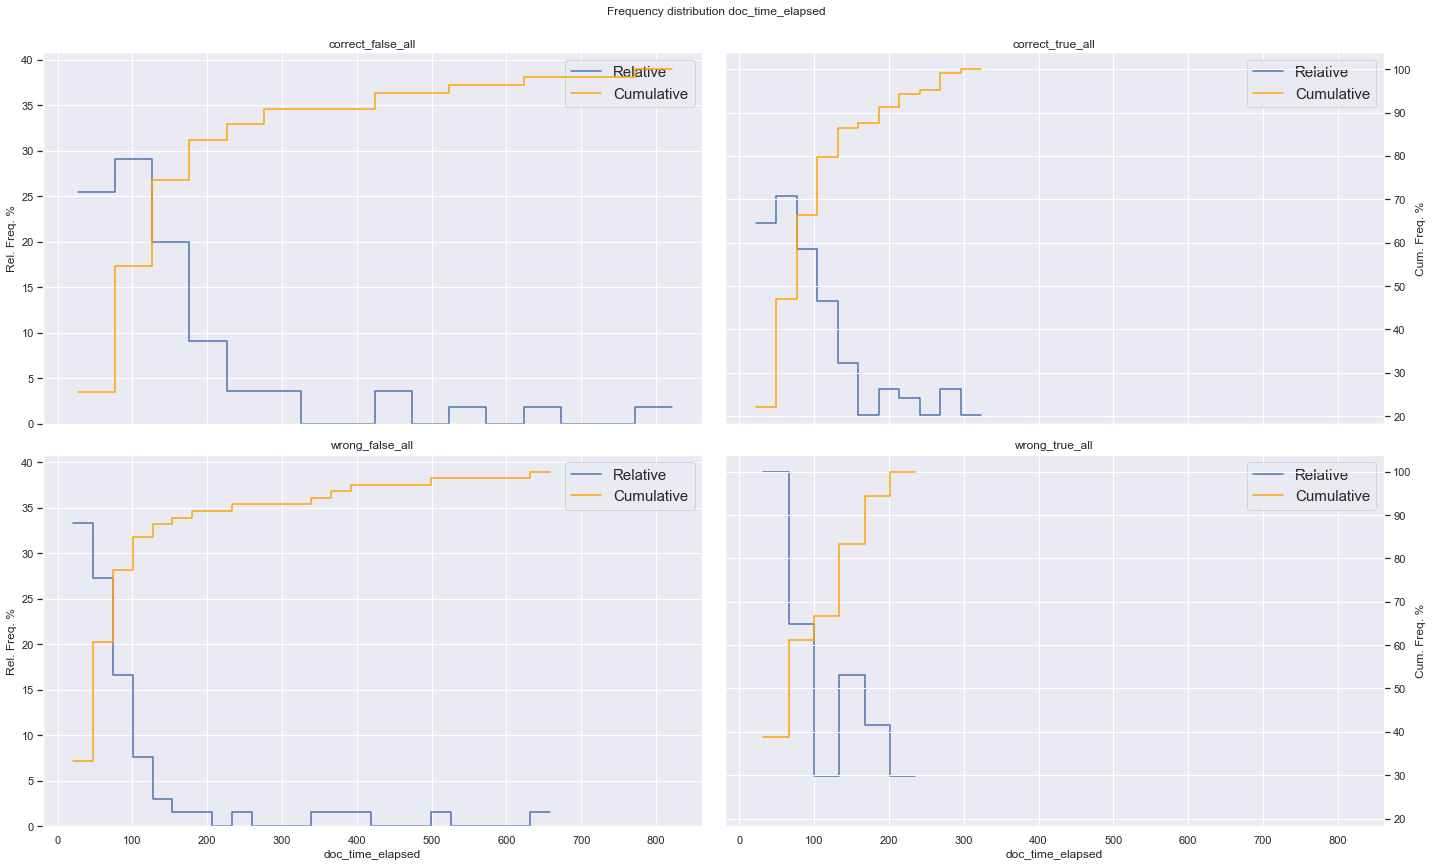

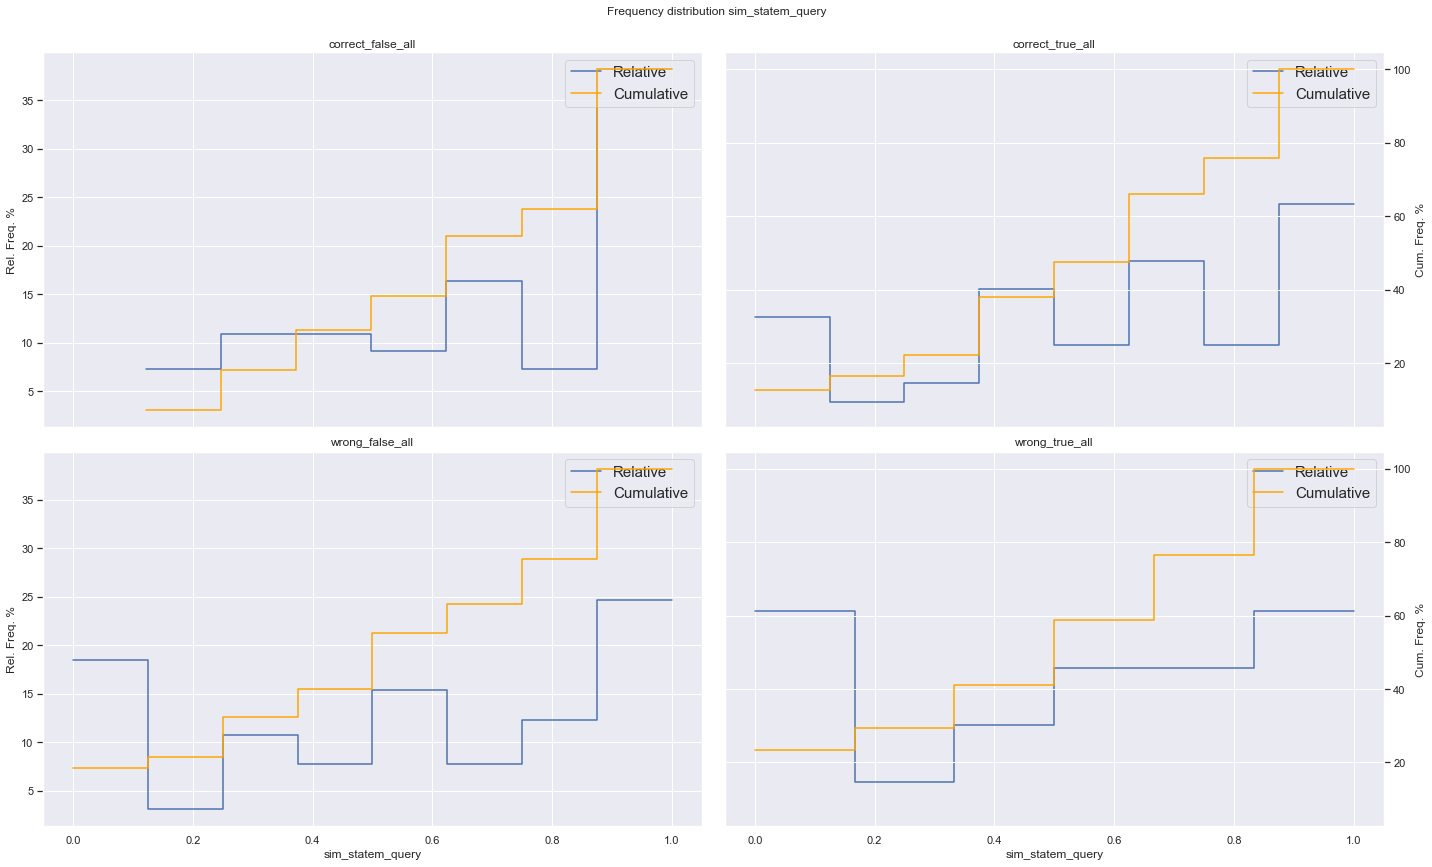

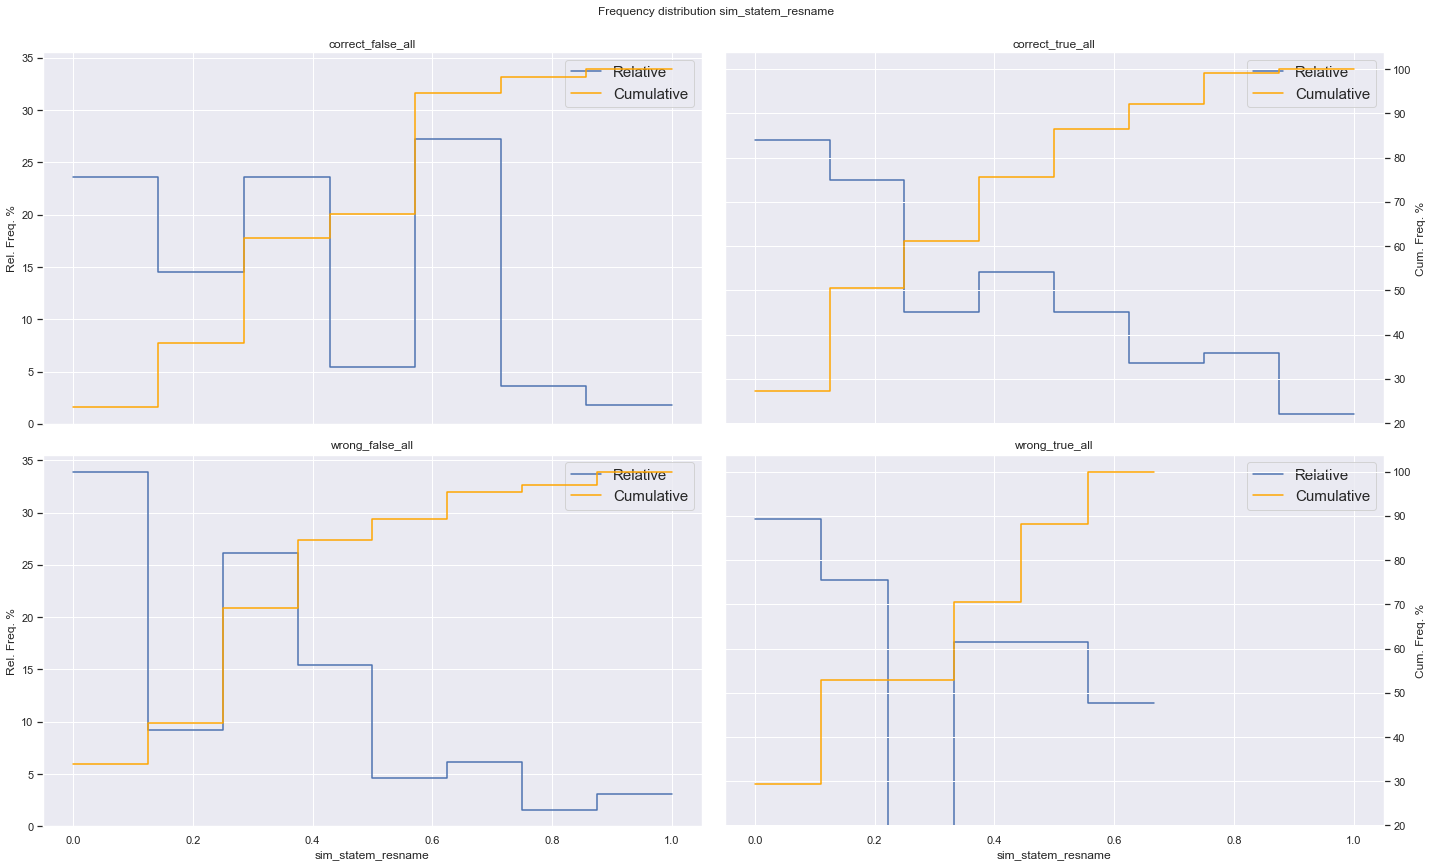

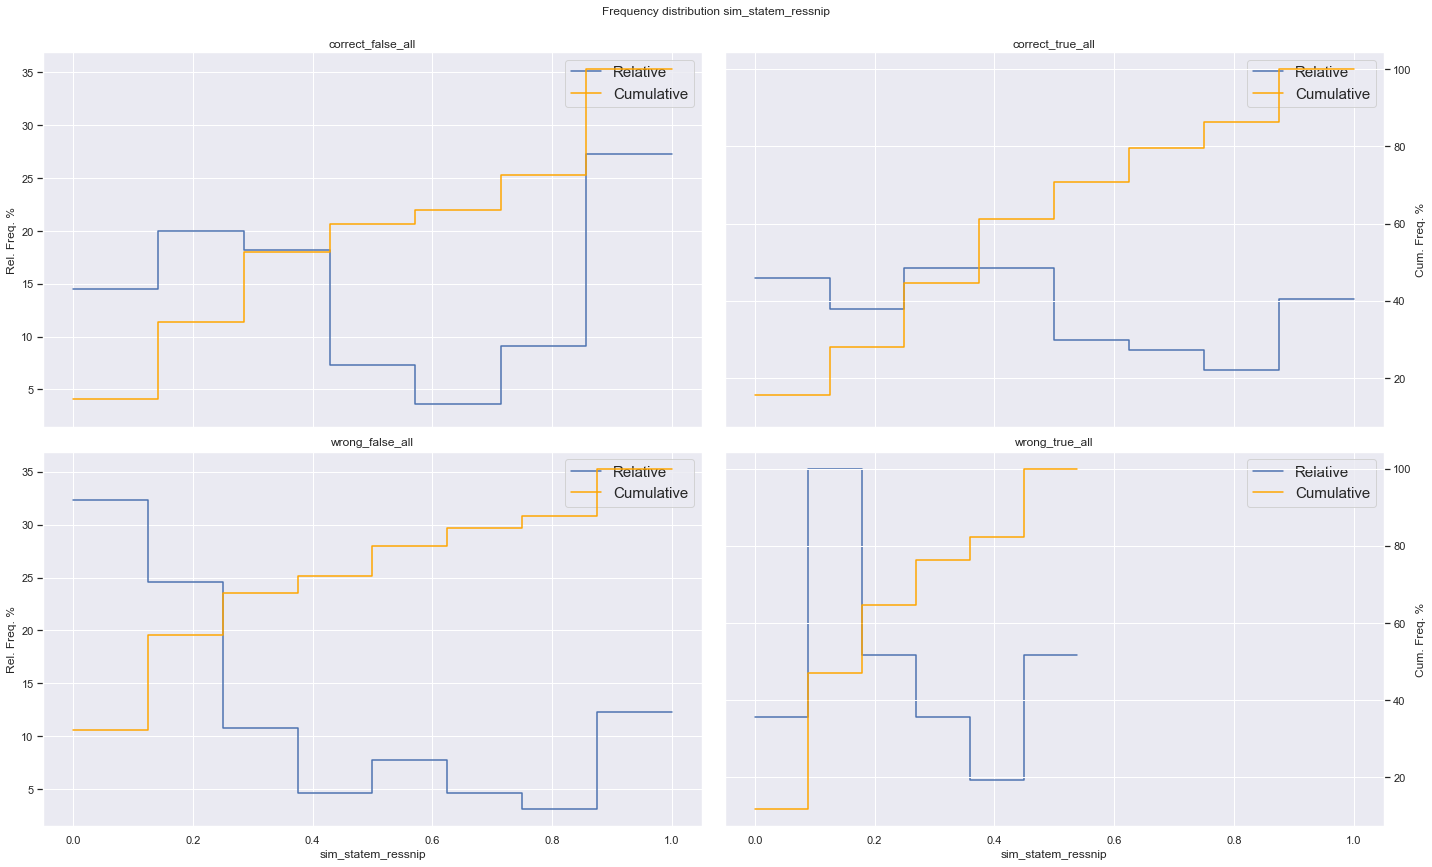

In [18]:
cols=['doc_time_elapsed',
 'sim_statem_query',
 'sim_statem_resname',
 'sim_statem_ressnip']

statements=pd.read_csv('../Dati/all_rows.csv')
statements=statements.loc[statements['type'].map(lambda x: x.endswith('_all')), ['type']+cols]
for c in cols:
    fig, axs = plt.subplots(2,2,figsize=(20, 12), sharey=True, sharex=True)
    twins=[ax.twinx() for ax in axs.flatten()]
    twins[0].get_shared_y_axes().join(twins[0], twins[1],twins[2],twins[3])
    twins[0].get_yaxis().set_visible(False)
    twins[2].get_yaxis().set_visible(False)
    axs.ravel()[1].get_yaxis().set_visible(False)
    axs.ravel()[3].get_yaxis().set_visible(False)
    for t,ax,ax2 in zip(statements.type.unique(), axs.flatten(), twins):
        
        sns.histplot(data=statements.loc[statements.type==t], x=c,  stat='percent',element="step", fill=False, ax=ax, label='Relative')
        sns.histplot(
            data=statements.loc[statements.type==t], x=c,  stat='percent',element="step", fill=False,
            cumulative=True, ax=ax2, color='orange'
        )
        ax.set_ylabel("Rel. Freq. %")
        ax2.set_ylabel("Cum. Freq. %")
        
        ax.plot(np.nan, color='orange', label = 'Cumulative')
        ax.legend(loc=1, prop={'size': 15})
        ax.set_title(t)
        

    fig.suptitle(f"Frequency distribution {c}", y=1)
    fig.tight_layout()
        
    pathlib.Path(f"../Dati/dist_freq").mkdir(parents=True, exist_ok=True) 
    fig.savefig(f'../Dati/dist_freq/freq_{c}.png',  bbox_inches='tight')

In [19]:
create_collage(3000, 1800, 2,2, [f"../Dati/dist_freq/freq_{c}.png" for c in  cols], '../Dati/pics/freq_collage.png')

0 0 0
1 0 902
2 1502 0
3 1502 902


## Media overall-truthfulness tutti, per dimensione

In [61]:
from itertools import combinations

multi = pd.read_csv("../Dati/multidimensional.csv")
multi['doc_name']=multi['doc_name'].map(lambda x: x.split('_')[0])
multi['q_1_farmers_value']=multi['q_1_farmers_value'].map(lambda x: 'correct value' if x==3 else 'wrong value')
multi['q_2_marks_value']=multi['q_2_marks_value'].map(lambda x: 'correct value' if x==9 else 'wrong value')
multi['q_3_athletics_value']=multi['q_3_athletics_value'].map(lambda x: 'correct value' if x==4 else 'wrong value')
multi['q_0_school_answer']=multi['q_0_school_answer'].map(shorten_school)
multi['sim_statem_query']=multi['sim_statem_query'].map(lambda x: 'low' if x<0.34 else ('mid' if x<0.67 else 'high'))

r= pd.read_csv("../Dati/all_rows.csv")
r=r[r['type'].apply(lambda x: x.endswith('_all'))]
r['sim_statem_query']=r['sim_statem_query'].map(lambda x: 'low' if x<0.34 else ('mid' if x<0.67 else 'high'))


cols=['current_try' ,'q_0_age_answer', 'q_0_school_answer', 'q_0_taxes_answer',
 'q_0_political_views_answer' ,'q_0_consideration_answer',
 'q_0_southern_border_answer', 'q_0_environment_answer', 'q_1_farmers_value',
 'q_2_marks_value' ,'q_3_athletics_value' ,'doc_index', 'doc_name',
  'doc_date' ,'doc_source','doc_accesses','query_amount','response_position','selected_amount','sim_statem_query']


df_mean=pd.DataFrame(columns=['dimension','value','mean','size'])
df_sig_all=pd.DataFrame(columns=['dimension','value_1','value_2','mean_1','mean_2','pval_res','pval_bonf', 'significant_005','significant_bonf'])
df_sig_dims=pd.DataFrame(columns=['dimension','value_1','value_2','pval_res','pval_bonf', 'significant_005','significant_bonf'])

def swap(x):
        if x.mean_1>x.mean_2:
            x.mean_1, x.mean_2 = x.mean_2, x.mean_1
            x.value_1, x.value_2 = x.value_2, x.value_1
        return x
    
for c in cols:
    d1=multi[[c,'doc_overall-truthfulness_value']].copy()
    d2=r[[c,'doc_overall-truthfulness_value']].copy()
    m=d1.groupby(c)['doc_overall-truthfulness_value'].agg(['mean','size']).reset_index().rename(columns={c:'value'})
    m.insert(0, 'dimension', c)
    df_mean=pd.concat([df_mean, m])
    
    vals1=list(m.value)
    combs1=list(combinations(vals1, 2))
    vals2=list(r[c].dropna().unique())
    combs2=list(combinations(vals2, 2))
    alpha_bonferroni1 = 0.05/len(combs1)
    alpha_bonferroni2 = 0.05/len(combs2)
    s1=pd.DataFrame(combs1,columns=['value_1','value_2'])
    s2=pd.DataFrame(combs2,columns=['value_1','value_2'])
    s1.insert(0, 'dimension', c)
    s2.insert(0, 'dimension', c)
    s1['mean_1']=s1['value_1'].map(lambda x: m.loc[(m.dimension==c) & (m.value==x), 'mean'].values[0]).values
    s1['mean_2']=s1['value_2'].map(lambda x: m.loc[(m.dimension==c) & (m.value==x), 'mean'].values[0]).values

    s1=s1.apply(swap, axis=1)
    
    test1=s1.apply(lambda x: mannwhitneyu(
                d1.loc[d1[c]==x.value_1 , 'doc_overall-truthfulness_value'],
                d1.loc[d1[c]==x.value_2, 'doc_overall-truthfulness_value']
        )[1], axis=1)
    test2=s2.apply(lambda x: mannwhitneyu(
                d2.loc[d2[c]==x.value_1 , 'doc_overall-truthfulness_value'],
                d2.loc[d2[c]==x.value_2, 'doc_overall-truthfulness_value']
        )[1], axis=1)
    
    s1['pval_res']=  test1
    s1['pval_bonf']= alpha_bonferroni1
    s1['significant_005']= s1.apply(lambda x: 'yes' if x['pval_res']<=0.05 else 'no' ,axis=1) 
    s1['significant_bonf']= s1.apply(lambda x: 'yes' if x['pval_res']<=x['pval_bonf'] else 'no' ,axis=1) 
    
    s2['pval_res']=  test2
    s2['pval_bonf']= alpha_bonferroni2
    s2['significant_005']= s2.apply(lambda x: 'yes' if x['pval_res']<=0.05 else 'no' ,axis=1) 
    s2['significant_bonf']= s2.apply(lambda x: 'yes' if x['pval_res']<=x['pval_bonf'] else 'no' ,axis=1)
    
    df_sig_all=pd.concat([df_sig_all, s1])
    df_sig_dims=pd.concat([df_sig_dims, s2])

df_mean.to_csv('../Dati/groupby_mean.csv',index=False)
pathlib.Path(f"../Dati/sig_analysis").mkdir(parents=True, exist_ok=True) 
df_sig_all.to_csv('../Dati/sig_analysis/groupby_mean_sig.csv',index=False)
df_sig_dims.to_csv('../Dati/sig_analysis/groupby_dimensions_sig.csv',index=False)

# Test significatività

In [62]:
from itertools import combinations

## Significatività dimensioni categorie

In [63]:
r= pd.read_csv("../Dati/all_rows.csv")
r=r[r['type'].apply(lambda x: x.endswith('_all'))]
transf_data(r, transf_cols)

cols=['current_try','q_0_age_answer','q_0_school_answer','q_0_taxes_answer','q_0_political_views_answer','q_0_consideration_answer',
      'q_0_southern_border_answer','q_0_environment_answer','q_1_farmers_value','q_2_marks_value','q_3_athletics_value',
      'doc_index','doc_name','doc_date','doc_source','doc_overall-truthfulness_value','doc_confidence_value','doc_correctness_value',
      'doc_neutrality_value','doc_comprehensibility_value','doc_precision_value','doc_completeness_value',
      "doc_speaker's-trustworthiness_value",'doc_informativeness_value','doc_accesses','doc_time_elapsed','query_amount',
      'response_position','selected_amount','sim_statem_query','sim_statem_resname','sim_statem_ressnip','url_speaksabout','fre']

df_sig_mann=pd.DataFrame(columns=['dimension','value_1','value_2','pval_res','pval_bonf', 'significant_005','significant_bonf'])
df_sig_ks=pd.DataFrame(columns=['dimension','value_1','value_2','pval_res','pval_bonf', 'significant_005','significant_bonf'])

for c in cols:

    vals=list(r.type.unique())
    combs=list(combinations(vals, 2))
    alpha_bonferroni = 0.05/len(combs)
    
    s_mann=pd.DataFrame(combs,columns=['value_1','value_2'])
    s_mann.insert(0, 'dimension', c)
    s_ks=pd.DataFrame(combs,columns=['value_1','value_2'])
    s_ks.insert(0, 'dimension', c)
    
    def test_mann(x):
        d1=r.loc[(r.type==x.value_1) & (r[c].notnull())].copy()
        d2=r.loc[(r.type==x.value_2) & (r[c].notnull())].copy()
        
        if c in ['doc_name','doc_date', 'doc_source','fre']:
            d1= d1.drop_duplicates(['doc_statement'])
            d2= d2.drop_duplicates(['doc_statement'])
        
        return  mannwhitneyu(d1[c],d2[c])[1]
    
    def test_ks(x):
        d1=r.loc[(r.type==x.value_1) & (r[c].notnull())].copy()
        d2=r.loc[(r.type==x.value_2) & (r[c].notnull())].copy()
        
        if c in ['doc_name','doc_date', 'doc_source','fre']:
            d1= d1.drop_duplicates(['doc_statement'])
            d2= d2.drop_duplicates(['doc_statement'])
        
        return  ks_2samp(d1[c],d2[c])[1]
    
    test_mann=s_mann.apply(test_mann, axis=1)
    test_ks=s_ks.apply(test_ks, axis=1)
    
    s_mann['pval_res']=  test_mann
    s_mann['pval_bonf']= alpha_bonferroni
    s_mann['significant_005']= s_mann.apply(lambda x: 'yes' if x['pval_res']<=0.05 else 'no' ,axis=1) 
    s_mann['significant_bonf']= s_mann.apply(lambda x: 'yes' if x['pval_res']<=x['pval_bonf'] else 'no' ,axis=1)
    
    s_ks['pval_res']=  test_ks
    s_ks['pval_bonf']= alpha_bonferroni
    s_ks['significant_005']= s_ks.apply(lambda x: 'yes' if x['pval_res']<=0.05 else 'no' ,axis=1) 
    s_ks['significant_bonf']= s_ks.apply(lambda x: 'yes' if x['pval_res']<=x['pval_bonf'] else 'no' ,axis=1) 
    
    df_sig_mann=pd.concat([df_sig_mann, s_mann])
    df_sig_ks=pd.concat([df_sig_ks, s_ks])
    
pathlib.Path(f"../Dati/sig_analysis").mkdir(parents=True, exist_ok=True) 
df_sig_mann.to_csv('../Dati/sig_analysis/groupby_categories_sig_mann.csv',index=False)
df_sig_ks.to_csv('../Dati/sig_analysis/groupby_categories_sig_ks.csv',index=False)

In [67]:
r= pd.read_csv("../Dati/all_rows.csv")
ratio= pd.read_csv("../Dati/all_ratio.csv")
r=r[r['type'].apply(lambda x: x.endswith('_all'))]
r['doc_overall-truthfulness_url']=r['doc_overall-truthfulness_url'].map(lambda x: x.split("/")[2])
r['doc_name']=r['doc_name'].map(lambda x: x.split("_")[0])

df_sig=pd.DataFrame(columns=['dimension','type','pval_res','pval_bonf','significant_005','significant_bonf'])
alpha_bonferroni = 0.05/4

cols=ratio.type.unique()
for c in cols:
    for t in r.type.unique():
        suffix=t.split('_')[1]
        expected=ratio.loc[(ratio.file==f'{suffix}_all') & (ratio.type==c)].rename(columns={'rate':'rate_exp'})
        expected['rate_exp']=expected['rate_exp']*100
        if(expected['rate_exp'].sum() < 100):
            expected=pd.concat([expected, pd.DataFrame([(f'{suffix}_all',t,'NA', 100-expected['rate_exp'].sum())],columns=['file','type','value','rate_exp'])])
        observed=r.loc[(r.type==t)].value_counts(c,normalize=True, dropna=False)
        observed=pd.DataFrame(zip(observed.index,observed*100), columns=['value', 'rate_obs'])
        observed['value']=observed['value'].fillna('NA')
        expected['value']=expected['value'].astype('str')
        observed['value']=observed['value'].astype('str')
        join=pd.merge(expected, observed, on='value', how='left')
        join['rate_obs']=join['rate_obs'].fillna(0)
        test=chisquare(f_obs=join.rate_obs, f_exp=join.rate_exp)[1]
        sig_005='yes' if test<=0.05 else 'no'
        sig_bonf='yes' if test<=alpha_bonferroni else 'no'
        s=pd.DataFrame([(c,t,test, alpha_bonferroni,sig_005,sig_bonf)],columns=['dimension','type','pval_res','pval_bonf','significant_005','significant_bonf'])
        df_sig=pd.concat([df_sig, s])

pathlib.Path(f"../Dati/sig_analysis").mkdir(parents=True, exist_ok=True) 
df_sig.to_csv('../Dati/sig_analysis/groupby_categories_sig_chi.csv',index=False)

In [ ]:
r= pd.read_csv("../Dati/all_rows.csv")
ratio= pd.read_csv("../Dati/all_ratio.csv")
r=r[r['type'].apply(lambda x: x.endswith('_all'))]
r['doc_overall-truthfulness_url']=r['doc_overall-truthfulness_url'].map(lambda x: x.split("/")[2])
r['doc_name']=r['doc_name'].map(lambda x: x.split("_")[0])

df_sig=pd.DataFrame(columns=['dimension','type_1','type_2','significant_005','significant_bonf','pval_res','pval_bonf'])

# cols=ratio.type.unique()
cols=['query_amount']
for c in cols:
    vals=list(r.type.unique())
    combs=list(combinations(vals, 2))
    alpha_bonferroni = 0.05/len(combs)
    s=pd.DataFrame([combs[5]],columns=['type_1','type_2'])
    s.insert(0, 'dimension', c)

    # test=s.apply(lambda x: mannwhitneyu(
    #                     r.loc[(r.type==x.value_1) & (r[c].notnull()), c],
    #                     r.loc[(r.type==x.value_2) & (r[c].notnull()), c]
    #     )[1], axis=1)
    
    def chitest(x):
        exp=r.loc[r.type==x.type_1].value_counts(c,normalize=True, dropna=False)*100
        obs=r.loc[r.type==x.type_2].value_counts(c,normalize=True, dropna=False)*100
        exp=pd.DataFrame(zip(exp.index,exp), columns=['value', 'rate_exp'])
        obs=pd.DataFrame(zip(obs.index,obs), columns=['value', 'rate_obs'])
        exp['value']=exp['value'].fillna('NA')
        obs['value']=obs['value'].fillna('NA')
        exp['value']=exp['value'].astype('str')
        obs['value']=obs['value'].astype('str')
        join=pd.merge(exp, obs, on='value', how='outer')
        join['rate_obs']=join['rate_obs'].fillna(0)
        join['rate_exp']=join['rate_exp'].fillna(0)
        print(x.type_1)
        print(x.type_2)
        # print('exp:')
        # print(exp)
        # print('obs:')
        # print(obs)
        # print('join:')
        print(join)
        # print('---------------------------------')
        print(chisquare(f_obs=join.rate_obs, f_exp=join.rate_exp)[1])
        print(chisquare(f_exp=join.rate_obs, f_obs=join.rate_exp)[1])
        print(min(chisquare(f_obs=join.rate_obs, f_exp=join.rate_exp)[1], chisquare(f_exp=join.rate_obs, f_obs=join.rate_exp)[1]))
        return min(chisquare(f_obs=join.rate_obs, f_exp=join.rate_exp)[1], chisquare(f_exp=join.rate_obs, f_obs=join.rate_exp)[1])

    test=s.apply(chitest , axis=1)
    
    # s['pval_res']=  test
    # s['pval_bonf']= alpha_bonferroni
    # s['significant_005']= s.apply(lambda x: 'yes' if x['pval_res']<=0.05 else 'no' ,axis=1) 
    # s['significant_bonf']= s.apply(lambda x: 'yes' if x['pval_res']<=x['pval_bonf'] else 'no' ,axis=1) 
    
    # df_sig=pd.concat([df_sig, s])
    
    
    
    # for t in r.type.unique():
    #     if(expected['rate_exp'].sum() < 100):
    #         expected=pd.concat([expected, pd.DataFrame([(f'{suffix}_all',t,'NA', 100-expected['rate_exp'].sum())],columns=['file','type','value','rate_exp'])])
    #     observed=r.loc[(r.type==t)].value_counts(c,normalize=True, dropna=False)
    #     observed=pd.DataFrame(zip(observed.index,observed*100), columns=['value', 'rate_obs'])
    #     observed['value']=observed['value'].fillna('NA')
    #     expected['value']=expected['value'].astype('str')
    #     observed['value']=observed['value'].astype('str')
    #     join=pd.merge(expected, observed, on='value', how='left')
    #     join['rate_obs']=join['rate_obs'].fillna(0)
    #     test=chisquare(f_obs=join.rate_obs, f_exp=join.rate_exp)[1]
    #     sig_005='yes' if test<=0.05 else 'no'
    #     sig_bonf='yes' if test<=alpha_bonferroni else 'no'
    #     s=pd.DataFrame([(c,t,sig_005,sig_bonf,test, alpha_bonferroni)],columns=['dimension','type','significant_005','significant_bonf','pval_res','pval_bonf'])
    #     df_sig=pd.concat([df_sig, s])

# pathlib.Path(f"../Dati/sig_analysis").mkdir(parents=True, exist_ok=True) 
# df_sig.to_csv('../Dati/sig_analysis/groupby_categories_sig_chi.csv',index=False)

In [ ]:
r= pd.read_csv("../Dati/all_rows.csv")
ratio= pd.read_csv("../Dati/all_ratio.csv")
r=r[r['type'].apply(lambda x: x.endswith('_all'))]
transf_data(r, transf_cols)
r['doc_overall-truthfulness_url']=r['doc_overall-truthfulness_url'].map(lambda x: x.split("/")[2])
# r['doc_name']=r['doc_name'].map(lambda x: x.split("_")[0])

df_sig=pd.DataFrame(columns=['dimension','type_1','type_2','significant_005','significant_bonf','pval_res','pval_bonf'])

# cols=ratio.type.unique()
cols=['sim_statem_query']
for c in cols:
    vals=list(r.type.unique())
    combs=list(combinations(vals, 2))
    alpha_bonferroni = 0.05/len(combs)
    s=pd.DataFrame(combs,columns=['type_1','type_2'])
    s.insert(0, 'dimension', c)

    # test=s.apply(lambda x: mannwhitneyu(
    #                     r.loc[(r.type==x.value_1) & (r[c].notnull()), c],
    #                     r.loc[(r.type==x.value_2) & (r[c].notnull()), c]
    #     )[1], axis=1)
    
    def chitest(x):
        exp=r.loc[r.type==x.type_1,c]
        obs=r.loc[r.type==x.type_2,c]
        # exp=pd.DataFrame(zip(exp.index,exp), columns=['value', 'rate_exp'])
        # obs=pd.DataFrame(zip(obs.index,obs), columns=['value', 'rate_obs'])
        # exp['value']=exp['value'].fillna('NA')
        # obs['value']=obs['value'].fillna('NA')
        # exp['value']=exp['value'].astype('str')
        # obs['value']=obs['value'].astype('str')
        # join=pd.merge(exp, obs, on='value', how='outer')
        # join['rate_obs']=join['rate_obs'].fillna(0)
        # join['rate_exp']=join['rate_exp'].fillna(0)
        print(x.type_1)
        print(x.type_2)
        # print(exp)
        # print(obs)
        print(ks_2samp(exp,obs)[1])
        # print('exp:')
        # print(exp)
        # print('obs:')
        # print(obs)
        # print('join:')
        # print(join)
        print('---------------------------------')
        # print(chisquare(f_obs=join.rate_obs, f_exp=join.rate_exp)[1])
        # print(chisquare(f_exp=join.rate_obs, f_obs=join.rate_exp)[1])
        # print(min(chisquare(f_obs=join.rate_obs, f_exp=join.rate_exp)[1], chisquare(f_exp=join.rate_obs, f_obs=join.rate_exp)[1]))
        return 1#min(chisquare(f_obs=join.rate_obs, f_exp=join.rate_exp)[1], chisquare(f_exp=join.rate_obs, f_obs=join.rate_exp)[1])

    test=s.apply(chitest , axis=1)
    
    # s['pval_res']=  test
    # s['pval_bonf']= alpha_bonferroni
    # s['significant_005']= s.apply(lambda x: 'yes' if x['pval_res']<=0.05 else 'no' ,axis=1) 
    # s['significant_bonf']= s.apply(lambda x: 'yes' if x['pval_res']<=x['pval_bonf'] else 'no' ,axis=1) 
    
    # df_sig=pd.concat([df_sig, s])


# pathlib.Path(f"../Dati/sig_analysis").mkdir(parents=True, exist_ok=True) 
# df_sig.to_csv('../Dati/sig_analysis/groupby_categories_sig_chi.csv',index=False)

In [68]:
false_labs=['negative','pants-on-fire']
true_labs=['positive','true']

d = pd.read_csv("../Dati/multidimensional.csv")
d=d.loc[d['doc_name']!='DEM_BARELYTRUE_doc7']

d['q_1_farmers_value']=d['q_1_farmers_value'].map(lambda x: 'correct value' if x==3 else 'wrong value')
d['q_2_marks_value']=d['q_2_marks_value'].map(lambda x: 'correct value' if x==9 else 'wrong value')
d['q_3_athletics_value']=d['q_3_athletics_value'].map(lambda x: 'correct value' if x==4 else 'wrong value')
d['q_0_school_answer']=d['q_0_school_answer'].map(shorten_school)

d=d.loc[(d['doc_ground_truth_abc_label']==false_labs[0]) | 
        (d['doc_ground_truth_abc_label']==true_labs[0]) |
        (d['doc_ground_truth_politifact_label']==false_labs[1])|
        (d['doc_ground_truth_politifact_label']==true_labs[1])]

d.loc[(d['doc_ground_truth_abc_label']==false_labs[0]) | (d['doc_ground_truth_politifact_label']==false_labs[1]),'type']='false'
d.loc[(d['doc_ground_truth_abc_label']==true_labs[0]) | (d['doc_ground_truth_politifact_label']==true_labs[1]),'type']='true'

transf_data(d, transf_cols)
d=d.drop_duplicates(['doc_statement'])
d=d[['type','fre']]
print(f"pval fre true false: {mannwhitneyu(d.loc[d.type=='false','fre'],d.loc[d.type=='true','fre'],)[1]}")
print(f"fre mean false: {d.loc[d.type=='false','fre'].mean()}")
print(f"fre mean true: {d.loc[d.type=='true','fre'].mean()}")

pval fre true false: 0.6545091931811244
fre mean false: 56.91324999999999
fre mean true: 54.84075
